# 1. Input Data Generation

This notebook implements a **choice space reduction** strategy for hierarchical data generation:
- **T5W3 (Small scale)**: 2 skills, simplified constraints, guaranteed feasibility
- **T10W5 (Medium scale)**: 3 skills, moderate complexity
- **T20W10 (Large scale)**: 4 skills, full complexity

Core concept: **Reduce choice space to improve matching probability while maintaining natural randomness variance**

In [212]:
# Import required libraries
import random
import json
import numpy as np
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import os
from pathlib import Path
from collections import Counter


## 1.1 Hierarchical Configuration System

Core Design Principles

**Choice Space Reduction Strategy**:
- **Small scale** (T5W3): Small skill sets to improve matching probability
- **Medium scale** (T10W5): Progressive complexity growth
- **Large scale** (T20W10): Maintain original complexity

Parameter Mapping

| Config | Skills | Task Types | Worker Skills | Max Predecessors | Duration | Unavailable Rate |
|--------|--------|------------|---------------|------------------|----------|------------------|
| Small | 2 | 2 | 2-2 | 1 | 1-3 periods | 5% |
| Medium | 3 | 3 | 2-3 | 1 | 1-4 periods | 8% |
| Large | 4 | 3 | 2-4 | 2 | 1-5 periods | 10% |


In [213]:
# Hierarchical configuration class for automatic parameter selection
class ScaledDataGeneratorConfig:
    """Hierarchical data generation configuration - scale-optimized parameter space"""
    
    def __init__(self, scale_type: str = "auto"):
        self.scale_type = scale_type
        self._setup_base_params()
        
    def _setup_base_params(self):
        """Base parameters common across all scales"""
        # Time settings
        self.TOTAL_PERIODS = 20
        self.PERIOD_LENGTH = 4 * 60  # 4 hours = 240 minutes
        
        # Skill and task type ranges
        self.TASK_SKILL_NUM_MIN = 1
        self.TASK_SKILL_NUM_MAX = 2
        self.TASK_SKILL_LEVEL_MIN = 1
        self.TASK_SKILL_LEVEL_MAX = 3
        
        self.WORKER_MIN_SKILLS = 2
        self.WORKER_MIN_SKILL_LEVEL = 1
        self.WORKER_MAX_LEVEL = 5
        
        # Constraint settings
        self.PREDECESSOR_MIN = 0
        self.BUFFER_MAX = 1
        self.WORKER_MIN_UTILISATION_PERCENT_UPPER_BOUND = 15
        self.WORKER_MAX_UTILISATION_PERCENT_LOWER_BOUND = 80
    
    def get_config_for_scale(self, num_tasks: int, num_workers: int) -> Dict:
        """Return appropriate configuration based on task and worker count"""
        
        # Auto-detect scale
        if num_tasks <= 5:
            scale = "small"
        elif num_tasks <= 10:
            scale = "medium"
        else:
            scale = "large"
            
        if self.scale_type != "auto":
            scale = self.scale_type
            
        # Scale-specific configurations
        if scale == "small":
            config = {
                "AVAILABLE_SKILLS": ["skill_1", "skill_2"],
                "AVAILABLE_TASK_TYPES": ["type_1", "type_2"],
                "WORKER_MAX_SKILLS": 2,
                "PREDECESSOR_MAX": 1,
                "DURATION_P_MAX": 3,
                "PRIORITY_RANGE": 3,
                "UNAVAILABLE_PROBABILITY": 0.05,
                
                "scale_name": "Small (T5W3)",
                "complexity_level": "Simplified constraints, guaranteed feasibility"
            }
        elif scale == "medium":
            config = {
                "AVAILABLE_SKILLS": ["skill_1", "skill_2", "skill_3"],
                "AVAILABLE_TASK_TYPES": ["type_1", "type_2", "type_3"],
                "WORKER_MAX_SKILLS": 3,
                "PREDECESSOR_MAX": 1,
                "DURATION_P_MAX": 4,
                "PRIORITY_RANGE": 4,
                "UNAVAILABLE_PROBABILITY": 0.08,
                
                "scale_name": "Medium (T10W5)",
                "complexity_level": "Moderate complexity"
            }
        else:  # large
            config = {
                "AVAILABLE_SKILLS": ["skill_1", "skill_2", "skill_3", "skill_4"],
                "AVAILABLE_TASK_TYPES": ["type_1", "type_2", "type_3"],
                "WORKER_MAX_SKILLS": 4,
                "PREDECESSOR_MAX": 2,
                "DURATION_P_MAX": 5,
                "PRIORITY_RANGE": 5,
                "UNAVAILABLE_PROBABILITY": 0.1,
                
                "scale_name": "Large (T20W10)",
                "complexity_level": "Full complexity"
            }
        
        # Merge base parameters
        for key, value in self.__dict__.items():
            if not key.startswith('_') and key not in config:
                config[key] = value
                
        return config

# Test configuration system
config_manager = ScaledDataGeneratorConfig()

print("Hierarchical configuration system created")
print("\nConfiguration test:")

for tasks, workers in [(5, 3), (10, 5), (20, 10)]:
    cfg = config_manager.get_config_for_scale(tasks, workers)
    print(f"\n{cfg['scale_name']}:")
    print(f"   Skills: {cfg['AVAILABLE_SKILLS']}")
    print(f"   Task types: {cfg['AVAILABLE_TASK_TYPES']}")
    print(f"   Complexity: {cfg['complexity_level']}")
    print(f"   Max predecessors: {cfg['PREDECESSOR_MAX']}, Max duration: {cfg['DURATION_P_MAX']}")


Hierarchical configuration system created

Configuration test:

Small (T5W3):
   Skills: ['skill_1', 'skill_2']
   Task types: ['type_1', 'type_2']
   Complexity: Simplified constraints, guaranteed feasibility
   Max predecessors: 1, Max duration: 3

Medium (T10W5):
   Skills: ['skill_1', 'skill_2', 'skill_3']
   Task types: ['type_1', 'type_2', 'type_3']
   Complexity: Moderate complexity
   Max predecessors: 1, Max duration: 4

Large (T20W10):
   Skills: ['skill_1', 'skill_2', 'skill_3', 'skill_4']
   Task types: ['type_1', 'type_2', 'type_3']
   Complexity: Full complexity
   Max predecessors: 2, Max duration: 5


## 1.2 Complexity Calculator

Three Core Metrics

1. **Skill Coverage**: Proportion of task skill requirements that workers can satisfy (0-1)
2. **Capacity Utilization**: Required work time / Available work time (>1 indicates overload)  
3. **Skill Buffer**: Average excess of worker skill levels over task requirements (higher = easier)


In [214]:
# Complexity calculator for dataset difficulty assessment
class ComplexityMetrics:
    """Calculate three key complexity metrics for datasets"""
    
    @staticmethod
    def calculate_skill_coverage(tasks: List[Dict], workers: List[Dict]) -> float:
        """Calculate skill coverage: proportion of task requirements workers can satisfy"""
        task_skill_requirements = set()
        worker_available_skills = set()
        
        # Collect task skill requirements
        for task in tasks:
            for skill, level in task['skills'].items():
                task_skill_requirements.add((skill, level))
        
        # Collect worker capabilities (workers can satisfy all levels <= their own)
        for worker in workers:
            for skill, worker_level in worker['skills'].items():
                for req_level in range(1, worker_level + 1):
                    worker_available_skills.add((skill, req_level))
        
        if not task_skill_requirements:
            return 1.0
        
        covered_requirements = task_skill_requirements.intersection(worker_available_skills)
        coverage = len(covered_requirements) / len(task_skill_requirements)
        
        return coverage
    
    @staticmethod
    def calculate_capacity_utilization(tasks: List[Dict], workers: List[Dict], total_periods: int) -> float:
        """Calculate capacity utilization: required work time / available work time"""
        # Calculate total task duration
        total_task_duration = sum(task['duration'] for task in tasks)
        
        # Calculate total worker capacity
        total_worker_capacity = 0
        for worker in workers:
            available_periods = total_periods - len(worker['unavailable'])
            worker_capacity = available_periods * (4 * 60)  # 4 hours per period, in minutes
            total_worker_capacity += worker_capacity
        
        if total_worker_capacity == 0:
            return float('inf')
        
        utilization = total_task_duration / total_worker_capacity
        return utilization
    
    @staticmethod  
    def calculate_skill_buffer(tasks: List[Dict], workers: List[Dict]) -> float:
        """Calculate skill buffer: average excess of worker skill levels over task requirements"""
        total_buffer = 0
        requirement_count = 0
        
        for task in tasks:
            for skill, required_level in task['skills'].items():
                # Find capable workers for this skill requirement
                capable_worker_levels = []
                for worker in workers:
                    if skill in worker['skills'] and worker['skills'][skill] >= required_level:
                        capable_worker_levels.append(worker['skills'][skill])
                
                if capable_worker_levels:
                    # Calculate buffer between highest available level and requirement
                    max_available_level = max(capable_worker_levels)
                    buffer = max_available_level - required_level
                    total_buffer += buffer
                    requirement_count += 1
        
        if requirement_count == 0:
            return 0.0
        
        average_buffer = total_buffer / requirement_count
        return average_buffer
    
    @classmethod
    def analyze_dataset(cls, dataset: Dict) -> Dict:
        """Calculate all complexity metrics for a dataset"""
        tasks = dataset['tasks']
        workers = dataset['workers']
        periods = dataset['periods']
        
        metrics = {
            "skill_coverage": cls.calculate_skill_coverage(tasks, workers),
            "capacity_utilization": cls.calculate_capacity_utilization(tasks, workers, len(periods)),
            "skill_buffer": cls.calculate_skill_buffer(tasks, workers)
        }
        
        return metrics
    
    @staticmethod
    def classify_complexity(metrics: Dict) -> str:
        """Classify dataset complexity based on three metrics"""
        sc = metrics["skill_coverage"] 
        cu = metrics["capacity_utilization"]
        sb = metrics["skill_buffer"]
        
        if sc >= 0.8 and cu <= 0.7 and sb >= 1.0:
            return "Easy"
        elif sc >= 0.6 and cu <= 0.9 and sb >= 0.5:
            return "Medium"
        else:
            return "Hard"

print("Complexity calculator defined")
print("Three core metrics:")
print("   Skill Coverage: proportion of requirements satisfiable (0-1, higher = more feasible)")
print("   Capacity Utilization: work demand/capacity ratio (>1 indicates potential infeasibility)")  
print("   Skill Buffer: average skill excess over requirements (higher = easier)")


Complexity calculator defined
Three core metrics:
   Skill Coverage: proportion of requirements satisfiable (0-1, higher = more feasible)
   Capacity Utilization: work demand/capacity ratio (>1 indicates potential infeasibility)
   Skill Buffer: average skill excess over requirements (higher = easier)


## 1.3 Hierarchical Random Data Generator

Core Features

1. **Preserves Satalia Algorithm**: Uses same biased_random_choice and generation logic
2. **Adaptive Configuration**: Automatically selects appropriate parameter space based on data scale
3. **Natural Randomness**: Maintains full randomness within reduced choice space
4. **Reproducibility**: Deterministic generation based on seeds


In [215]:
# Hierarchical random data generator combining Satalia algorithm with layered configuration
class ScaledRandomDataGenerator:
    """Hierarchical random data generator with scale-adaptive Satalia algorithm"""
    
    def __init__(self, config_manager: ScaledDataGeneratorConfig):
        self.config_manager = config_manager
    
    def biased_random_choice(self, low: int, high: int, exponent: float = 10.0) -> int:
        """
        Core Satalia randomization method using power distribution
        
        Biases deadlines toward earlier periods, reflecting realistic project behavior
        Higher exponent increases bias toward low values
        """
        random_value = 1 - np.random.power(exponent)
        result = int(low + (high - low) * random_value)
        return result
    
    def generate_task_skills(self, config: Dict) -> Dict[str, int]:
        """Generate random skill requirements for task using hierarchical configuration"""
        # Select random number of skills from reduced skill set
        num_skills = random.randint(config['TASK_SKILL_NUM_MIN'], config['TASK_SKILL_NUM_MAX'])
        selected_skills = random.sample(config['AVAILABLE_SKILLS'], num_skills)
        
        # Assign requirement level (1-3) for each skill
        skills = {
            skill: random.randint(config['TASK_SKILL_LEVEL_MIN'], config['TASK_SKILL_LEVEL_MAX'])
            for skill in selected_skills
        }
        return skills
    
    def generate_predecessors(self, task_id: int, config: Dict) -> List[int]:
        """Generate random predecessor dependencies using hierarchical complexity"""
        available_predecessors = list(range(1, task_id))  # Can only depend on lower ID tasks
        if not available_predecessors:
            return []
        
        # Use hierarchical maximum predecessor count
        max_predecessors = min(config['PREDECESSOR_MAX'], len(available_predecessors))
        predecessors_count = random.randint(config['PREDECESSOR_MIN'], max_predecessors)
        predecessors = random.sample(available_predecessors, predecessors_count)
        return predecessors
    
    def generate_deadline(self, deadlines: Dict[int, int], duration_multiplier: int, 
                         predecessors: List[int], config: Dict) -> int:
        """Generate task deadline considering predecessor constraints using Satalia logic"""
        if predecessors:
            # With predecessors: deadline = max(predecessor deadlines) + duration + random buffer
            max_pred_deadline = max(deadlines[pred] for pred in predecessors)
            deadline = max_pred_deadline + duration_multiplier + random.randint(1, config['BUFFER_MAX'])
        else:
            # Without predecessors: use early-biased random deadline
            random_buffer = random.randint(1, config['BUFFER_MAX'])
            deadline = self.biased_random_choice(
                duration_multiplier + random_buffer, 
                config['TOTAL_PERIODS']
            )
        return deadline
    
    def generate_task(self, task_id: int, deadlines: Dict[int, int], config: Dict) -> Dict:
        """Generate single random task using complete hierarchical Satalia algorithm"""
        # Generate predecessor tasks
        predecessors = self.generate_predecessors(task_id, config)
        
        # Generate duration using hierarchical maximum period count
        duration_multiplier = random.randint(1, config['DURATION_P_MAX'])
        duration = config['PERIOD_LENGTH'] * duration_multiplier  # Convert to minutes
        
        # Generate deadline
        deadline = self.generate_deadline(deadlines, duration_multiplier, predecessors, config)
        
        # Handle impossible deadlines using Satalia approach
        if deadline > config['TOTAL_PERIODS']:
            predecessors = []  # Clear predecessor constraints
            random_buffer = random.randint(1, config['BUFFER_MAX'])
            deadline = self.biased_random_choice(
                duration_multiplier + random_buffer,
                config['TOTAL_PERIODS']
            )
        
        # Update deadline record
        deadlines[task_id] = deadline
        
        # Build task object
        task = {
            "id": task_id,
            "task_type": random.choice(config['AVAILABLE_TASK_TYPES']),
            "priority": random.randint(1, config['PRIORITY_RANGE']),
            "skills": self.generate_task_skills(config),
            "duration": duration,
            "predecessors": predecessors,
            "deadline": deadline
        }
        return task
    
    def generate_worker(self, worker_id: int, config: Dict) -> Dict:
        """Generate single random worker using hierarchical configuration"""
        # Random preferences from hierarchical task types
        num_preferences = random.randint(1, len(config['AVAILABLE_TASK_TYPES']))
        preferences = random.sample(config['AVAILABLE_TASK_TYPES'], num_preferences)
        
        # Random skills using hierarchical skill count and set
        num_skills = random.randint(config['WORKER_MIN_SKILLS'], config['WORKER_MAX_SKILLS'])
        skills = {
            skill: random.randint(config['WORKER_MIN_SKILL_LEVEL'], config['WORKER_MAX_LEVEL'])
            for skill in random.sample(config['AVAILABLE_SKILLS'], num_skills)
        }
        
        # Random unavailable periods using hierarchical probability
        unavailable = []
        if random.random() < config['UNAVAILABLE_PROBABILITY']:
            start_period = random.randint(1, config['TOTAL_PERIODS'] - 1)
            unavailable = [start_period, start_period + 1]
        
        # Random utilization boundaries
        min_util = random.randint(0, config['WORKER_MIN_UTILISATION_PERCENT_UPPER_BOUND'])
        max_util = random.randint(config['WORKER_MAX_UTILISATION_PERCENT_LOWER_BOUND'], 100)
        
        # Build worker object
        worker = {
            "id": worker_id,
            "preference": preferences,
            "skills": skills,
            "min_utilisation": min_util / 100,  # Convert to decimal
            "max_utilisation": max_util / 100,  # Convert to decimal
            "unavailable": unavailable
        }
        return worker
    
    def generate_periods(self, config: Dict) -> List[Dict]:
        """Generate period data"""
        periods = []
        for period_id in range(1, config['TOTAL_PERIODS'] + 1):
            periods.append({
                "index": period_id,  # Use 'index' field per Satalia schema
                "duration": config['PERIOD_LENGTH']
            })
        return periods
    
    def generate_dataset(self, num_tasks: int, num_workers: int, seed: Optional[int] = None) -> Dict:
        """Generate complete hierarchical random dataset"""
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
        
        # Get appropriate scale configuration
        config = self.config_manager.get_config_for_scale(num_tasks, num_workers)
        
        # Generate tasks
        tasks = []
        deadlines = {}  # Track deadlines for predecessor constraint handling
        for task_id in range(1, num_tasks + 1):
            task = self.generate_task(task_id, deadlines, config)
            tasks.append(task)
        
        # Generate workers
        workers = []
        for worker_id in range(1, num_workers + 1):
            worker = self.generate_worker(worker_id, config)
            workers.append(worker)
        
        # Generate periods
        periods = self.generate_periods(config)
        
        # Build complete dataset
        dataset = {
            "tasks": tasks,
            "workers": workers,
            "periods": periods
        }
        
        return dataset, config

print("Hierarchical random data generator defined")
print("Core features:")
print("   - Preserves Satalia's biased_random_choice (power distribution)")
print("   - Automatically selects parameter space based on scale")
print("   - Dynamically handles infeasible predecessor constraints")
print("   - Hierarchically optimized complexity control")


Hierarchical random data generator defined
Core features:
   - Preserves Satalia's biased_random_choice (power distribution)
   - Automatically selects parameter space based on scale
   - Dynamically handles infeasible predecessor constraints
   - Hierarchically optimized complexity control


## 1.4 Demonstration and Testing

Test data generation effectiveness across different scales


In [216]:
# Demonstrate hierarchical data generation effectiveness
config_manager = ScaledDataGeneratorConfig()
generator = ScaledRandomDataGenerator(config_manager)
complexity_calc = ComplexityMetrics()

print("Hierarchical data generation demonstration")
print("=" * 60)

# Test three scales
test_configs = [
    (5, 3, "T5W3 Small scale"),
    (10, 5, "T10W5 Medium scale"), 
    (20, 10, "T20W10 Large scale")
]

for num_tasks, num_workers, scale_name in test_configs:
    print(f"\n{scale_name} test:")
    print("-" * 40)
    
    # Generate dataset
    dataset, config = generator.generate_dataset(num_tasks, num_workers, seed=42)
    
    # Calculate complexity metrics
    metrics = complexity_calc.analyze_dataset(dataset)
    complexity_label = complexity_calc.classify_complexity(metrics)
    
    # Display configuration info
    print(f"Configuration used: {config['scale_name']}")
    print(f"   Skill set: {config['AVAILABLE_SKILLS']}")
    print(f"   Task types: {config['AVAILABLE_TASK_TYPES']}")
    print(f"   Max predecessors: {config['PREDECESSOR_MAX']}, Max duration: {config['DURATION_P_MAX']} periods")
    print(f"   Unavailable probability: {config['UNAVAILABLE_PROBABILITY']*100:.0f}%")
    
    # Display generation results
    print(f"\nGeneration results:")
    print(f"   Tasks: {len(dataset['tasks'])}, Workers: {len(dataset['workers'])}")
    
    # Display complexity analysis
    print(f"\nComplexity analysis:")
    print(f"   Skill coverage: {metrics['skill_coverage']:.3f}")
    print(f"   Capacity utilization: {metrics['capacity_utilization']:.3f}")
    print(f"   Skill buffer: {metrics['skill_buffer']:.3f}")
    print(f"   Complexity classification: {complexity_label}")
    
    # Quick feasibility check
    print(f"\nFeasibility analysis:")
    feasible_tasks = 0
    for task in dataset['tasks']:
        task_feasible = False
        for worker in dataset['workers']:
            can_do = True
            for skill, req_level in task['skills'].items():
                if skill not in worker['skills'] or worker['skills'][skill] < req_level:
                    can_do = False
                    break
            if can_do:
                task_feasible = True
                break
        if task_feasible:
            feasible_tasks += 1
    
    feasibility_rate = feasible_tasks / len(dataset['tasks'])
    print(f"   Executable task ratio: {feasibility_rate:.1%} ({feasible_tasks}/{len(dataset['tasks'])})")
    
    if feasibility_rate >= 0.8:
        print("   High feasibility - most tasks have suitable workers")
    elif feasibility_rate >= 0.6:
        print("   Medium feasibility - some tasks may be difficult to assign")
    else:
        print("   Low feasibility - significant skill gaps exist")

print("\n" + "=" * 60)
print("Hierarchical generation system test completed")
print("Observation: smaller scale yields higher feasibility while maintaining variance")


Hierarchical data generation demonstration

T5W3 Small scale test:
----------------------------------------
Configuration used: Small (T5W3)
   Skill set: ['skill_1', 'skill_2']
   Task types: ['type_1', 'type_2']
   Max predecessors: 1, Max duration: 3 periods
   Unavailable probability: 5%

Generation results:
   Tasks: 5, Workers: 3

Complexity analysis:
   Skill coverage: 1.000
   Capacity utilization: 0.183
   Skill buffer: 2.250
   Complexity classification: Easy

Feasibility analysis:
   Executable task ratio: 100.0% (5/5)
   High feasibility - most tasks have suitable workers

T10W5 Medium scale test:
----------------------------------------
Configuration used: Medium (T10W5)
   Skill set: ['skill_1', 'skill_2', 'skill_3']
   Task types: ['type_1', 'type_2', 'type_3']
   Max predecessors: 1, Max duration: 4 periods
   Unavailable probability: 8%

Generation results:
   Tasks: 10, Workers: 5

Complexity analysis:
   Skill coverage: 1.000
   Capacity utilization: 0.210
   Skill b

## 1.5 Batch Data Generator

Experimental Dataset Generation

Generate large numbers of datasets for LLM experiments, ensuring:
- **Variance Control**: Each dataset uses different seed but remains reproducible
- **Complexity Analysis**: Automatic calculation and recording of complexity metrics  
- **Complete Metadata**: Generation parameters, complexity measures, file paths


In [217]:
# Batch data generator for large-scale experiments
class ScaledBatchGenerator:
    """Hierarchical batch dataset generator for large-scale LLM experiments"""
    
    def __init__(self, output_dir: str = "2_Input_data"):
        self.config_manager = ScaledDataGeneratorConfig()
        self.generator = ScaledRandomDataGenerator(self.config_manager)
        self.complexity_calculator = ComplexityMetrics()
        
        # Create hierarchical directory structure
        self.output_dir = Path(output_dir)
        self.inputdata_dir = self.output_dir / "Inputdata"  # Clean input data
        self.metadata_dir = self.output_dir / "Metadata"    # Metadata and summaries
        
        # Ensure directories exist
        self.output_dir.mkdir(exist_ok=True)
        self.inputdata_dir.mkdir(exist_ok=True)
        self.metadata_dir.mkdir(exist_ok=True)
        
        print(f"Hierarchical batch generator initialized")
        print(f"Base directory: {self.output_dir}")
        print(f"Input data: {self.inputdata_dir}")
        print(f"Metadata: {self.metadata_dir}")
    
    def generate_single_with_analysis(self, 
                                    num_tasks: int, 
                                    num_workers: int, 
                                    dataset_id: int,
                                    base_seed: Optional[int] = None) -> Tuple[Dict, Dict, Dict]:
        """
        Generate single dataset with complexity analysis
        
        Args:
            num_tasks: Number of tasks
            num_workers: Number of workers
            dataset_id: Dataset ID for seed calculation
            base_seed: Base seed (default 42)
            
        Returns:
            (dataset, complexity_metrics, metadata)
        """
        # Ensure each dataset has different but reproducible seed: base_seed + dataset_id * 1000
        seed = (base_seed or 42) + dataset_id * 1000
        
        # Generate dataset
        dataset, config = self.generator.generate_dataset(num_tasks, num_workers, seed)
        
        # Calculate complexity metrics
        complexity_metrics = self.complexity_calculator.analyze_dataset(dataset)
        
        # Generate metadata
        metadata = {
            "generation_timestamp": datetime.now().isoformat(),
            "num_tasks": num_tasks,
            "num_workers": num_workers,
            "dataset_id": dataset_id,
            "seed_used": seed,
            "base_seed": base_seed,
            "complexity_metrics": complexity_metrics,
            "complexity_classification": self.complexity_calculator.classify_complexity(complexity_metrics),
            "config_used": {
                "scale_name": config['scale_name'],
                "available_skills": config['AVAILABLE_SKILLS'],
                "available_task_types": config['AVAILABLE_TASK_TYPES'],
                "complexity_level": config['complexity_level']
            }
        }
        
        return dataset, complexity_metrics, metadata
    
    def save_dataset(self, dataset: Dict, metadata: Dict, filename_prefix: str):
        """Save dataset and metadata to separate directories"""
        # Save main dataset to Inputdata directory (clean input data for solving)
        dataset_filename = f"{filename_prefix}.json"
        dataset_path = self.inputdata_dir / dataset_filename
        with open(dataset_path, 'w') as f:
            json.dump(dataset, f, indent=2)
        
        # Save metadata to Metadata directory (complexity metrics, generation info)
        metadata_filename = f"{filename_prefix}_metadata.json"
        metadata_path = self.metadata_dir / metadata_filename
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        return dataset_path, metadata_path
    
    def generate_experiment_batch(self, 
                                num_tasks: int, 
                                num_workers: int, 
                                dataset_count: int = 20,
                                base_seed: Optional[int] = None,
                                show_progress: bool = True) -> List[Dict]:
        """
        Generate batch datasets for experiments
        
        Args:
            num_tasks: Number of tasks per dataset
            num_workers: Number of workers per dataset
            dataset_count: Number of datasets to generate
            base_seed: Base seed for reproducibility
            show_progress: Whether to display progress
            
        Returns:
            List of batch summary information
        """
        if show_progress:
            print(f"Starting batch generation: T{num_tasks}W{num_workers} x{dataset_count} datasets")
            print(f"Output directory: {self.output_dir}")
            print(f"Base seed: {base_seed or 42}")
        
        batch_summary = []
        complexity_stats = {"skill_coverage": [], "capacity_utilization": [], "skill_buffer": []}
        complexity_classifications = []
        
        for i in range(1, dataset_count + 1):
            if show_progress:
                print(f"   Generating dataset {i:2d}/{dataset_count}...", end=' ')
            
            # Generate dataset
            dataset, complexity_metrics, metadata = self.generate_single_with_analysis(
                num_tasks, num_workers, i, base_seed
            )
            
            # Save files with unified naming format
            filename_prefix = f"input_data_T{num_tasks}W{num_workers}_{i:02d}"
            dataset_path, metadata_path = self.save_dataset(dataset, metadata, filename_prefix)
            
            # Collect statistics
            for metric, value in complexity_metrics.items():
                complexity_stats[metric].append(value)
            complexity_classifications.append(metadata['complexity_classification'])
            
            # Create summary record
            summary = {
                "dataset_id": i,
                "filename": filename_prefix + ".json",
                "complexity_metrics": complexity_metrics,
                "complexity_classification": metadata['complexity_classification'],
                "seed_used": metadata["seed_used"],
                "file_paths": {
                    "dataset": str(dataset_path),
                    "metadata": str(metadata_path)
                }
            }
            batch_summary.append(summary)
            
            if show_progress:
                # Display complexity metrics
                print(f"[{complexity_metrics['skill_coverage']:.2f}/{complexity_metrics['capacity_utilization']:.2f}/{complexity_metrics['skill_buffer']:.2f}] {metadata['complexity_classification']}")
        
        # Save batch summary to Metadata directory
        batch_summary_filename = f"batch_summary_T{num_tasks}W{num_workers}.json"
        batch_summary_path = self.metadata_dir / batch_summary_filename
        with open(batch_summary_path, 'w') as f:
            json.dump(batch_summary, f, indent=2)
        
        if show_progress:
            # Print statistical summary
            print(f"\nBatch statistics summary:")
            for metric, values in complexity_stats.items():
                mean_val = np.mean(values)
                std_val = np.std(values)
                min_val = min(values)
                max_val = max(values)
                print(f"   {metric:20s}: {mean_val:.3f} ± {std_val:.3f} (range: {min_val:.3f}-{max_val:.3f})")
            
            # Complexity classification distribution
            classification_counts = Counter(complexity_classifications)
            print(f"\nComplexity classification distribution:")
            for classification, count in classification_counts.items():
                percentage = count / len(complexity_classifications) * 100
                print(f"   {classification}: {count} datasets ({percentage:.1f}%)")
            
            print(f"\nBatch generation completed! Summary saved to: {batch_summary_path}")
        
        return batch_summary

print("Hierarchical batch generator defined")
print("Supported features:")
print("   - Automatic hierarchical configuration selection")
print("   - Complexity metric calculation and classification")
print("   - Complete metadata recording")
print("   - Reproducible seed management")


Hierarchical batch generator defined
Supported features:
   - Automatic hierarchical configuration selection
   - Complexity metric calculation and classification
   - Complete metadata recording
   - Reproducible seed management


## 1.6 Execution


In [218]:
batch_gen_main = ScaledBatchGenerator(output_dir="2_Input_data")

Hierarchical batch generator initialized
Base directory: 2_Input_data
Input data: 2_Input_data/Inputdata
Metadata: 2_Input_data/Metadata


In [ ]:
# T5W3 batch1
t5w3_summary = batch_gen_main.generate_experiment_batch(
    num_tasks=5, 
    num_workers=3, 
    dataset_count=20,  # 20 datasets for actual experiments
    base_seed=1000
)

Starting batch generation: T5W3 x20 datasets
Output directory: 2_Input_data
Base seed: 1000
   Generating dataset  1/20... [1.00/0.15/3.25] Easy
   Generating dataset  2/20... [1.00/0.17/1.38] Easy
   Generating dataset  3/20... [1.00/0.17/2.57] Easy
   Generating dataset  4/20... [1.00/0.15/2.00] Easy
   Generating dataset  5/20... [1.00/0.15/1.75] Easy
   Generating dataset  6/20... [1.00/0.17/2.17] Easy
   Generating dataset  7/20... [1.00/0.20/2.75] Easy
   Generating dataset  8/20... [1.00/0.13/1.50] Easy
   Generating dataset  9/20... [0.80/0.17/1.00] Easy
   Generating dataset 10/20... [1.00/0.17/2.62] Easy
   Generating dataset 11/20... [1.00/0.16/3.00] Easy
   Generating dataset 12/20... [1.00/0.17/1.30] Easy
   Generating dataset 13/20... [1.00/0.12/2.14] Easy
   Generating dataset 14/20... [1.00/0.19/2.33] Easy
   Generating dataset 15/20... [1.00/0.20/1.75] Easy
   Generating dataset 16/20... [0.75/0.17/0.80] Medium
   Generating dataset 17/20... [0.67/0.15/2.50] Medium
   

In [114]:
# T5W3 batch2
t5w3_summary = batch_gen_main.generate_experiment_batch(
    num_tasks=5, 
    num_workers=3, 
    dataset_count=20,  # 20 datasets for actual experiments
    base_seed=1001
)

Starting batch generation: T5W3 x20 datasets
Output directory: 2_Input_data
Base seed: 1001
   Generating dataset  1/20... [1.00/0.22/0.83] Medium
   Generating dataset  2/20... [1.00/0.18/2.86] Easy
   Generating dataset  3/20... [1.00/0.17/2.11] Easy
   Generating dataset  4/20... [1.00/0.22/1.57] Easy
   Generating dataset  5/20... [1.00/0.22/3.25] Easy
   Generating dataset  6/20... [1.00/0.13/2.83] Easy
   Generating dataset  7/20... [1.00/0.15/3.11] Easy
   Generating dataset  8/20... [1.00/0.18/1.25] Easy
   Generating dataset  9/20... [1.00/0.19/2.86] Easy
   Generating dataset 10/20... [1.00/0.12/1.83] Easy
   Generating dataset 11/20... [1.00/0.19/3.33] Easy
   Generating dataset 12/20... [1.00/0.22/2.56] Easy
   Generating dataset 13/20... [1.00/0.18/2.40] Easy
   Generating dataset 14/20... [1.00/0.17/2.38] Easy
   Generating dataset 15/20... [1.00/0.22/2.50] Easy
   Generating dataset 16/20... [1.00/0.17/1.12] Easy
   Generating dataset 17/20... [1.00/0.12/2.43] Easy
   Ge

In [181]:
# T10W5 batch
t10w5_summary = batch_gen_main.generate_experiment_batch(
    num_tasks=10, 
    num_workers=5, 
    dataset_count=20, 
    base_seed=2000
)

Starting batch generation: T10W5 x20 datasets
Output directory: 2_Input_data
Base seed: 2000
   Generating dataset  1/20... [1.00/0.26/2.13] Easy
   Generating dataset  2/20... [1.00/0.29/1.33] Easy
   Generating dataset  3/20... [1.00/0.21/2.36] Easy
   Generating dataset  4/20... [1.00/0.24/2.44] Easy
   Generating dataset  5/20... [1.00/0.22/2.38] Easy
   Generating dataset  6/20... [1.00/0.29/2.69] Easy
   Generating dataset  7/20... [1.00/0.26/1.88] Easy
   Generating dataset  8/20... [1.00/0.29/2.85] Easy
   Generating dataset  9/20... [1.00/0.24/2.73] Easy
   Generating dataset 10/20... [1.00/0.22/3.07] Easy
   Generating dataset 11/20... [1.00/0.28/3.00] Easy
   Generating dataset 12/20... [1.00/0.28/3.07] Easy
   Generating dataset 13/20... [0.86/0.21/2.91] Easy
   Generating dataset 14/20... [1.00/0.28/2.54] Easy
   Generating dataset 15/20... [1.00/0.33/3.00] Easy
   Generating dataset 16/20... [1.00/0.26/3.08] Easy
   Generating dataset 17/20... [1.00/0.25/1.56] Easy
   Gen

In [219]:
# T20W10 batch
t20w10_summary = batch_gen_main.generate_experiment_batch(
    num_tasks=20, 
    num_workers=10, 
    dataset_count=20, 
    base_seed=3000
)

Starting batch generation: T20W10 x20 datasets
Output directory: 2_Input_data
Base seed: 3000
   Generating dataset  1/20... [1.00/0.33/2.61] Easy
   Generating dataset  2/20... [1.00/0.33/2.53] Easy
   Generating dataset  3/20... [1.00/0.28/2.64] Easy
   Generating dataset  4/20... [1.00/0.34/3.00] Easy
   Generating dataset  5/20... [1.00/0.37/2.60] Easy
   Generating dataset  6/20... [1.00/0.27/2.93] Easy
   Generating dataset  7/20... [1.00/0.31/2.81] Easy
   Generating dataset  8/20... [1.00/0.33/3.03] Easy
   Generating dataset  9/20... [1.00/0.32/2.97] Easy
   Generating dataset 10/20... [1.00/0.28/2.71] Easy
   Generating dataset 11/20... [1.00/0.29/3.13] Easy
   Generating dataset 12/20... [1.00/0.27/2.64] Easy
   Generating dataset 13/20... [1.00/0.29/2.69] Easy
   Generating dataset 14/20... [1.00/0.33/2.07] Easy
   Generating dataset 15/20... [1.00/0.30/3.07] Easy
   Generating dataset 16/20... [1.00/0.30/3.12] Easy
   Generating dataset 17/20... [1.00/0.28/2.46] Easy
   Ge

# 2. Satalia Solving System (Baseline Model)

Solving Configuration
- **Model Type**: FullPeriodModel  
- **Objective Function**: MaxPriorityAssignment
- **Output Format**: JSON (compliant with solution_schema.json)
- **Timeout Setting**: 5 minutes per dataset
- **Failure Strategy**: Continue processing other datasets

## 2.1 Julia Solving Script Generation


Create simplified Julia script based on main.jl (Satalia model) with command line argument support


## 2.2 Python Batch Solver

Batch solving system based on subprocess calls to Julia scripts


## 2.3 Solving Demonstration and Batch Usage


# 3. LLM Experiment

Core Design Concepts

1. **Configuration-Driven Universal System**
- Single codebase with manual configuration switching for prompt and output path changes
- Support for two-stage experiments: T5W3 prompt comparison → optimal prompt extension

2. **Two-Stage Prompt Strategy**
- **Stage 1**: Strategy analysis (natural language reasoning)
- **Stage 2**: JSON generation (based on Stage 1 insights)
- Uses `previous_response_id` to connect two stages

3. **Experimental Phase Management**
- **Phase 1**: T5W3 × Two Prompts (comparison experiment)
- **Phase 2**: T10W5 × Optimal Prompt (extension experiment)  
- **Phase 3**: T20W10 × Optimal Prompt (large-scale validation)

4. **Fault Tolerance and Recovery**
- Automatic retry mechanism
- Progress tracking and checkpoint recovery
- Detailed error logging


## 3.1 Two-stage Prompt

In [2]:
# LLM experiment system - imports and configuration
import os
import json
import time
import glob
from typing import Dict, List, Optional, Tuple
from pathlib import Path
from datetime import datetime
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Experiment configuration (modify to switch experiments)
EXPERIMENT_CONFIG = {
    # Manual configuration area
    "prompt_name": "promptA",
    "stage1_prompt_file": "1_Prompt/prompt_fullperiod_A_stage1.txt",
    "stage2_prompt_file": "1_Prompt/prompt_fullperiod_A_stage2.txt",
    "output_dir": "4_LLM_Experiment/T20W10_promptA",
    "dataset_pattern": "2_Input_data/Inputdata/input_data_T20W10_*.json",
    
    # Fixed configuration
    "model": "o3-2025-04-16",
    "max_retries": 3,
    "retry_delay": 2.0,
    "timeout_seconds": 300
}

# JSON output schema
OUTPUT_SCHEMA = {
    "type": "object",
    "properties": {
        "worker_task_period_assignments": {
            "type": "array",
            "items": {
                "type": "array",
                "minItems": 4,
                "maxItems": 4,
                "items": {"type": "number"}
            }
        }
    },
    "required": ["worker_task_period_assignments"],
    "additionalProperties": False
}

print("LLM experiment system configured")
print(f"Current config: {EXPERIMENT_CONFIG['prompt_name']} prompt")
print(f"Output directory: {EXPERIMENT_CONFIG['output_dir']}")
print(f"Dataset range: {EXPERIMENT_CONFIG['dataset_pattern']}")
print(f"Model: {EXPERIMENT_CONFIG['model']}")


LLM experiment system configured
Current config: promptA prompt
Output directory: 4_LLM_Experiment/T20W10_promptA
Dataset range: 2_Input_data/Inputdata/input_data_T20W10_*.json
Model: o3-2025-04-16


In [3]:
# Batch processing and main workflow
class UniversalLLMExperiment:
    """Universal LLM experiment system - config-driven with two-stage prompts"""
    
    def __init__(self, config: Dict):
        self.config = config
        self.output_dir = Path(config["output_dir"])
        self.setup_directories()
        
        # Load prompt files
        self.stage1_prompt = self.load_prompt(config["stage1_prompt_file"])
        self.stage2_prompt = self.load_prompt(config["stage2_prompt_file"])
        
        # Progress tracking
        self.progress_file = self.output_dir / "experiment_progress.json"
        self.progress = self.load_progress()
        
        print(f"LLM experiment system initialized")
        print(f"Output directory: {self.output_dir}")
        print(f"Prompt: {config['prompt_name']}")
        
    def setup_directories(self):
        """Create output directory structure"""
        directories = ["strategies", "solutions", "logs"]
        for dir_name in directories:
            (self.output_dir / dir_name).mkdir(parents=True, exist_ok=True)
            
    def load_prompt(self, file_path: str) -> str:
        """Load prompt file"""
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                return f.read()
        except FileNotFoundError:
            raise FileNotFoundError(f"Prompt file not found: {file_path}")
            
    def load_progress(self) -> Dict:
        """Load experiment progress"""
        if self.progress_file.exists():
            with open(self.progress_file, 'r') as f:
                return json.load(f)
        return {"completed": {}, "failed": {}}
        
    def save_progress(self):
        """Save experiment progress"""
        with open(self.progress_file, 'w') as f:
            json.dump(self.progress, f, indent=2)
            
    def is_completed(self, dataset_id: str) -> bool:
        """Check if dataset is completed"""
        return dataset_id in self.progress["completed"]
        
    def robust_llm_call(self, call_func, call_name: str, max_retries: int = None):
        """LLM call with retry mechanism"""
        if max_retries is None:
            max_retries = self.config["max_retries"]
            
        for attempt in range(max_retries):
            try:
                return call_func()
            except Exception as e:
                if attempt == max_retries - 1:
                    raise e
                print(f"   {call_name} attempt {attempt+1} failed: {str(e)[:100]}")
                time.sleep(self.config["retry_delay"] * (2 ** attempt))  # Exponential backoff
        
    def llm_stage1_strategy(self, dataset: Dict, dataset_id: str) -> Dict:
        """Stage 1: Generate strategy analysis"""
        input_data_str = json.dumps(dataset, indent=2)
        stage1_full_prompt = f"{self.stage1_prompt}\n\nHere is the input data:\n{input_data_str}"
        
        def make_call():
            return client.responses.create(
                model=self.config["model"],
                input=[
                    {
                        "role": "system",
                        "content": "You are a planning assistant for task allocation. First, analyze the constraints and propose a strategy."
                    },
                    {
                        "role": "user",
                        "content": stage1_full_prompt
                    }
                ]
            )
        
        response = self.robust_llm_call(make_call, "Stage1 strategy generation")
        
        # Save strategy text
        strategy_text = response.output_text
        strategy_file = self.output_dir / "strategies" / f"strategy_{dataset_id}.txt"
        with open(strategy_file, 'w', encoding='utf-8') as f:
            f.write(strategy_text)
            
        return {
            "response_id": response.id,
            "strategy_text": strategy_text,
            "strategy_file": str(strategy_file)
        }
        
    def llm_stage2_solution(self, stage1_result: Dict, dataset_id: str) -> Dict:
        """Stage 2: Generate JSON solution based on strategy"""
        
        def make_call():
            return client.responses.create(
                model=self.config["model"],
                previous_response_id=stage1_result["response_id"],
                input=[
                    {
                        "role": "user",
                        "content": self.stage2_prompt
                    }
                ],
                text={
                    "format": {
                        "type": "json_schema",
                        "name": "worker_schedule_response",
                        "schema": OUTPUT_SCHEMA,
                        "strict": True
                    }
                }
            )
        
        response = self.robust_llm_call(make_call, "Stage2 solution generation")
        
        # Parse JSON result
        solution_json = json.loads(response.output[1].content[0].text)
        
        # Save solution
        solution_file = self.output_dir / "solutions" / f"solution_{dataset_id}.json"
        with open(solution_file, 'w') as f:
            json.dump(solution_json, f, indent=2)
            
        return {
            "solution_data": solution_json,
            "solution_file": str(solution_file),
            "raw_response": response.output[1].content[0].text
        }
    
    def load_datasets(self) -> List[Tuple[str, Dict]]:
        """Load datasets"""
        dataset_files = glob.glob(self.config["dataset_pattern"])
        datasets = []
        
        for file_path in dataset_files:
            dataset_id = Path(file_path).stem  # Remove .json suffix
            
            try:
                with open(file_path, 'r') as f:
                    dataset = json.load(f)
                datasets.append((dataset_id, dataset))
            except Exception as e:
                print(f"   Cannot load dataset {file_path}: {e}")
                
        return datasets
    
    def process_single_dataset(self, dataset_id: str, dataset: Dict) -> Dict:
        """Process single dataset"""
        start_time = time.time()
        
        try:
            # Stage 1: Strategy generation
            print(f"   Stage 1: Strategy analysis...")
            stage1_result = self.llm_stage1_strategy(dataset, dataset_id)
            
            # Stage 2: JSON generation
            print(f"   Stage 2: Solution generation...")
            stage2_result = self.llm_stage2_solution(stage1_result, dataset_id)
            
            # Record success
            total_time = time.time() - start_time
            result = {
                "dataset_id": dataset_id,
                "status": "SUCCESS",
                "processing_time": total_time,
                "stage1_result": stage1_result,
                "stage2_result": stage2_result,
                "timestamp": datetime.now().isoformat()
            }
            
            # Update progress
            self.progress["completed"][dataset_id] = result
            self.save_progress()
            
            print(f"   Completed ({total_time:.1f}s)")
            return result
            
        except Exception as e:
            # Record failure
            total_time = time.time() - start_time
            error_result = {
                "dataset_id": dataset_id,
                "status": "FAILED",
                "error_message": str(e),
                "processing_time": total_time,
                "timestamp": datetime.now().isoformat()
            }
            
            self.progress["failed"][dataset_id] = error_result
            self.save_progress()
            
            print(f"   Failed: {str(e)[:100]}")
            return error_result
    
    def run_batch_experiment(self, resume: bool = True) -> Dict:
        """Run batch experiment"""
        print(f"Starting LLM batch experiment")
        print(f"Output directory: {self.output_dir}")
        print(f"Using prompt: {self.config['prompt_name']}")
        print(f"Model: {self.config['model']}")
        
        # Load datasets
        datasets = self.load_datasets()
        print(f"Found {len(datasets)} datasets")
        
        if not datasets:
            print("No datasets found, please check dataset_pattern configuration")
            return {"status": "NO_DATASETS"}
        
        # Filter completed datasets
        if resume:
            remaining_datasets = [(did, data) for did, data in datasets 
                                if not self.is_completed(did)]
            print(f"Resume checkpoint: {len(datasets) - len(remaining_datasets)} completed")
            print(f"To process: {len(remaining_datasets)} datasets")
        else:
            remaining_datasets = datasets
            print(f"Processing all datasets: {len(remaining_datasets)} datasets")
        
        if not remaining_datasets:
            print("All datasets completed!")
            return {"status": "ALL_COMPLETED"}
        
        # Batch processing
        batch_results = []
        success_count = 0
        
        for i, (dataset_id, dataset) in enumerate(remaining_datasets, 1):
            print(f"\n[{i:2d}/{len(remaining_datasets)}] Processing: {dataset_id}")
            
            result = self.process_single_dataset(dataset_id, dataset)
            batch_results.append(result)
            
            if result["status"] == "SUCCESS":
                success_count += 1
        
        # Generate batch summary
        total_datasets = len(datasets)
        total_completed = len(self.progress["completed"])
        total_failed = len(self.progress["failed"])
        
        batch_summary = {
            "experiment_config": self.config,
            "total_datasets": total_datasets,
            "completed_count": total_completed,
            "failed_count": total_failed,
            "success_rate": total_completed / total_datasets if total_datasets > 0 else 0,
            "batch_results": batch_results,
            "timestamp": datetime.now().isoformat()
        }
        
        # Save batch summary
        summary_file = self.output_dir / "batch_experiment_summary.json"
        with open(summary_file, 'w') as f:
            json.dump(batch_summary, f, indent=2)
        
        print(f"\nBatch experiment completed!")
        print(f"   Success: {total_completed}/{total_datasets} ({total_completed/total_datasets*100:.1f}%)")
        print(f"   Failed: {total_failed}/{total_datasets} ({total_failed/total_datasets*100:.1f}%)")
        print(f"Summary saved: {summary_file}")
        
        return batch_summary

print("LLM experiment system fully defined")
print("Main features:")
print("   - Configuration-driven prompt switching")
print("   - Two-stage LLM processing workflow")
print("   - Checkpoint recovery and progress tracking")
print("   - Automatic retry and error handling")
print("   - Detailed result recording")


LLM experiment system fully defined
Main features:
   - Configuration-driven prompt switching
   - Two-stage LLM processing workflow
   - Checkpoint recovery and progress tracking
   - Automatic retry and error handling
   - Detailed result recording


In [4]:
# LLM experiment demonstration

# Display current configuration
print("Current experiment configuration:")
for key, value in EXPERIMENT_CONFIG.items():
    print(f"   {key}: {value}")

print(f"\nPrerequisites:")
print(f"1. Prompt files: {EXPERIMENT_CONFIG['stage1_prompt_file']}")
print(f"2. Dataset: {EXPERIMENT_CONFIG['dataset_pattern']}")
print(f"3. OpenAI API Key configured")

print(f"\nOutput locations:")
print(f"   Strategy files: {EXPERIMENT_CONFIG['output_dir']}/strategies/")
print(f"   Solutions: {EXPERIMENT_CONFIG['output_dir']}/solutions/")
print(f"   Summary: {EXPERIMENT_CONFIG['output_dir']}/batch_experiment_summary.json")


Current experiment configuration:
   prompt_name: promptA
   stage1_prompt_file: 1_Prompt/prompt_fullperiod_A_stage1.txt
   stage2_prompt_file: 1_Prompt/prompt_fullperiod_A_stage2.txt
   output_dir: 4_LLM_Experiment/T20W10_promptA
   dataset_pattern: 2_Input_data/Inputdata/input_data_T20W10_*.json
   model: o3-2025-04-16
   max_retries: 3
   retry_delay: 2.0
   timeout_seconds: 300

Prerequisites:
1. Prompt files: 1_Prompt/prompt_fullperiod_A_stage1.txt
2. Dataset: 2_Input_data/Inputdata/input_data_T20W10_*.json
3. OpenAI API Key configured

Output locations:
   Strategy files: 4_LLM_Experiment/T20W10_promptA/strategies/
   Solutions: 4_LLM_Experiment/T20W10_promptA/solutions/
   Summary: 4_LLM_Experiment/T20W10_promptA/batch_experiment_summary.json


In [5]:
experiment = UniversalLLMExperiment(EXPERIMENT_CONFIG)
result = experiment.run_batch_experiment()

LLM experiment system initialized
Output directory: 4_LLM_Experiment/T20W10_promptA
Prompt: promptA
Starting LLM batch experiment
Output directory: 4_LLM_Experiment/T20W10_promptA
Using prompt: promptA
Model: o3-2025-04-16
Found 20 datasets
Resume checkpoint: 7 completed
To process: 13 datasets

[ 1/13] Processing: input_data_T20W10_02
   Stage 1: Strategy analysis...
   Stage 2: Solution generation...
   Completed (630.1s)

[ 2/13] Processing: input_data_T20W10_14
   Stage 1: Strategy analysis...
   Stage 2: Solution generation...
   Completed (216.8s)

[ 3/13] Processing: input_data_T20W10_15
   Stage 1: Strategy analysis...
   Stage 2: Solution generation...
   Completed (277.5s)

[ 4/13] Processing: input_data_T20W10_03
   Stage 1: Strategy analysis...
   Stage 2: Solution generation...
   Completed (287.7s)

[ 5/13] Processing: input_data_T20W10_19
   Stage 1: Strategy analysis...
   Stage 2: Solution generation...
   Completed (297.6s)

[ 6/13] Processing: input_data_T20W10_20
  

# 4. LLM Solution Schema Converter

After LLM experiments, convert LLM outputs to solution_schema.json format for:
- Comparison with Satalia results
- Solution validity checking using validation tools
- Unified performance analysis

Conversion Pipeline:
1. Read LLM raw output (`worker_task_period_assignments`)
2. Load corresponding input data file
3. Calculate 4 metrics using Full Period Model algorithm
4. Generate complete JSON format compliant with schema

Calculation algorithms strictly follow verified implementation from @my_project_old.ipynb


## 4.1 Schema Calculation Functions
Reuse verified calculation logic from my_project_old.ipynb


In [6]:
# LLM Solution Schema Converter - calculation functions
import json
import time
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime

# Reuse verified calculation functions from my_project_old.ipynb
def load_input_data(file_path: str) -> Dict:
    """Load and parse Satalia input data"""
    with open(file_path, 'r') as f:
        return json.load(f)

def parse_llm_output(llm_solution_file: str) -> List[List]:
    """Parse LLM output to get worker_task_period_assignments"""
    with open(llm_solution_file, 'r') as f:
        data = json.load(f)
    return data['worker_task_period_assignments']

def calculate_priority_assignment_full_period(input_data: Dict, assignments: List[List]) -> int:
    """
    EXACT Full Period Model Algorithm: Priority Assignment
    Julia code (line 139): priority_assignment = sum((H - input.p[i]) * y[i, k] for (i, k) ∈ y_indices)
    
    Where:
    - H = 1 + maximum(input.p)  
    - y[i, k] = 1 if task i assigned to worker k, 0 otherwise
    """
    # Calculate H exactly as in Julia code (line 138)
    H = 1 + max(task['priority'] for task in input_data['tasks'])
    
    # Build task-worker assignments (y[i,k] variables)
    task_worker_assignments = set()
    for assignment in assignments:
        worker_id, task_id, period_id, duration = assignment
        task_worker_assignments.add((task_id, worker_id))
    
    # Calculate sum((H - input.p[i]) * y[i, k])
    priority_value = 0
    tasks_dict = {task['id']: task for task in input_data['tasks']}
    
    for task_id, worker_id in task_worker_assignments:
        task_priority = tasks_dict[task_id]['priority']
        priority_value += (H - task_priority)  # y[i,k] = 1 for assigned pairs
    
    return priority_value

def calculate_early_priority_assignment_full_period(input_data: Dict, assignments: List[List]) -> int:
    """
    EXACT Full Period Model Algorithm: Early Priority Assignment
    Julia code (line 287-297): get_objective_value(model::FullPeriodModel, ::MaxEarlyPriorityAssignment)
    
    Algorithm:
    1. Find completion time for each task (max period)
    2. Calculate sum((H - input.p[i]) * (length(input.P) + 1 - u[i]))
    """
    # Calculate H and P exactly as in Julia code
    H = 1 + max(task['priority'] for task in input_data['tasks'])
    P = len(input_data['periods'])
    
    # Find completion time for each task (u[i] variable)
    completion_times = {}
    for assignment in assignments:
        worker_id, task_id, period_id, duration = assignment
        completion_times[task_id] = max(completion_times.get(task_id, 1), period_id)
    
    # Calculate sum((H - input.p[i]) * (length(input.P) + 1 - u[i]))
    early_priority_value = 0
    tasks_dict = {task['id']: task for task in input_data['tasks']}
    
    for task_id, completion_time in completion_times.items():
        task_priority = tasks_dict[task_id]['priority']
        early_priority_value += (H - task_priority) * (P + 1 - completion_time)
    
    return early_priority_value

def calculate_worker_preference_full_period(input_data: Dict, assignments: List[List]) -> int:
    """
    EXACT Full Period Model Algorithm: Worker Preference
    Julia code (line 143-145): worker_preference = sum((input.f[i, k] * y[i, k]) for (i, k) ∈ y_indices)
    
    Where:
    - f[i, k] = 1 if worker k prefers task i, 0 otherwise
    - y[i, k] = 1 if task i assigned to worker k, 0 otherwise
    """
    # Build preference matrix f[i, k] exactly as in Julia code (line 85-86)
    workers_dict = {worker['id']: worker for worker in input_data['workers']}
    tasks_dict = {task['id']: task for task in input_data['tasks']}
    
    # Calculate sum((input.f[i, k] * y[i, k]))
    worker_preference_value = 0
    task_worker_assignments = set()
    
    for assignment in assignments:
        worker_id, task_id, period_id, duration = assignment
        task_worker_assignments.add((task_id, worker_id))
    
    for task_id, worker_id in task_worker_assignments:
        task_type = tasks_dict[task_id]['task_type']
        worker_preferences = workers_dict[worker_id]['preference']
        
        # f[i, k] = 1 if worker k prefers task i, 0 otherwise
        if task_type in worker_preferences:
            worker_preference_value += 1  # f[i,k] * y[i,k] = 1 * 1 = 1
    
    return worker_preference_value

def calculate_maximal_workload_full_period(input_data: Dict, assignments: List[List]) -> float:
    """
    EXACT Full Period Model Algorithm: Maximal Workload
    Julia code (line 257-262): get_maximal_workload(model::FullPeriodModel)
    
    Algorithm: maximum(sum(x[i, k, p]) / length(input.Ak[k]) for k ∈ input.W)
    Where x[i, k, p] = 1 if task i assigned to worker k in period p
    """
    # Count working periods for each worker (sum of x[i, k, p] for each k)
    worker_period_count = {}
    for assignment in assignments:
        worker_id, task_id, period_id, duration = assignment
        worker_period_count[worker_id] = worker_period_count.get(worker_id, 0) + 1
    
    # Calculate workload ratio for each worker
    max_workload = 0.0
    for worker in input_data['workers']:
        worker_id = worker['id']
        # Available periods = total periods - unavailable periods (Ak[k])
        available_periods = len(input_data['periods']) - len(worker['unavailable'])
        working_periods = worker_period_count.get(worker_id, 0)
        
        if available_periods > 0:
            workload_ratio = working_periods / available_periods
            max_workload = max(max_workload, workload_ratio)
    
    return max_workload

def calculate_all_schema_metrics(input_data: Dict, assignments: List[List]) -> Dict:
    """Calculate all schema metrics"""
    return {
        'Worker preference': calculate_worker_preference_full_period(input_data, assignments),
        'Priority assignment': calculate_priority_assignment_full_period(input_data, assignments),
        'Early priority assignment': calculate_early_priority_assignment_full_period(input_data, assignments),
        'Maximal workload': calculate_maximal_workload_full_period(input_data, assignments)
    }

print("Schema calculation functions defined")
print("Using verified algorithms from my_project_old.ipynb")
print("Supports calculation of 4 key metrics:")
print("   - Worker preference: Worker preference matching")
print("   - Priority assignment: Priority assignment")
print("   - Early priority assignment: Early priority assignment")
print("   - Maximal workload: Maximal workload")


Schema calculation functions defined
Using verified algorithms from my_project_old.ipynb
Supports calculation of 4 key metrics:
   - Worker preference: Worker preference matching
   - Priority assignment: Priority assignment
   - Early priority assignment: Early priority assignment
   - Maximal workload: Maximal workload


## 4.2 File Matching and Conversion System


In [7]:
# LLM Solution Schema Converter - conversion system
class LLMToSchemaConverter:
    """LLM output converter to schema format"""
    
    def __init__(self, 
                 input_data_dir: str = "2_Input_data/Inputdata",
                 experiment_base_dir: str = "4_LLM_Experiment",
                 output_base_dir: str = "5_LLM_Solutions_Schema_Format"):
        
        self.input_data_dir = Path(input_data_dir)
        self.experiment_base_dir = Path(experiment_base_dir)
        self.output_base_dir = Path(output_base_dir)
        
        # Ensure output directory exists
        self.output_base_dir.mkdir(exist_ok=True)
        
        print(f"Schema converter initialized")
        print(f"Input data directory: {self.input_data_dir}")
        print(f"Experiment base directory: {self.experiment_base_dir}")
        print(f"Output base directory: {self.output_base_dir}")
    
    def extract_dataset_id(self, llm_solution_filename: str) -> str:
        """
        Extract dataset ID from LLM solution filename
        Example: solution_input_data_T5W3_01.json -> input_data_T5W3_01
        """
        filename = Path(llm_solution_filename).stem  # Remove .json suffix
        if filename.startswith('solution_'):
            return filename[9:]  # Remove 'solution_' prefix
        return filename
    
    def find_input_data_file(self, dataset_id: str) -> Optional[Path]:
        """
        Find corresponding input data file based on dataset ID
        Example: input_data_T5W3_01 -> 2_Input_data/Inputdata/input_data_T5W3_01.json
        """
        input_file = self.input_data_dir / f"{dataset_id}.json"
        if input_file.exists():
            return input_file
        return None
    
    def convert_single_solution(self, llm_solution_file: Path, output_dir: Path) -> Dict:
        """Convert single LLM solution to schema format"""
        try:
            start_time = time.time()
            
            # 1. Extract dataset ID and find corresponding input file
            dataset_id = self.extract_dataset_id(llm_solution_file.name)
            input_file = self.find_input_data_file(dataset_id)
            
            if not input_file:
                return {
                    "status": "failed",
                    "error": f"Cannot find corresponding input data file: {dataset_id}.json",
                    "dataset_id": dataset_id
                }
            
            # 2. Load data
            input_data = load_input_data(str(input_file))
            assignments = parse_llm_output(str(llm_solution_file))
            
            # 3. Calculate schema metrics
            metrics = calculate_all_schema_metrics(input_data, assignments)
            
            # 4. Generate complete schema format JSON
            schema_solution = {
                "Worker preference": metrics["Worker preference"],
                "Priority assignment": metrics["Priority assignment"],
                "Early priority assignment": metrics["Early priority assignment"],
                "Maximal workload": metrics["Maximal workload"],
                "worker_task_period_assignments": assignments
            }
            
            # 5. Save converted file
            output_file = output_dir / llm_solution_file.name
            with open(output_file, 'w') as f:
                json.dump(schema_solution, f, indent=2)
            
            processing_time = time.time() - start_time
            
            return {
                "status": "success",
                "dataset_id": dataset_id,
                "input_file": str(input_file),
                "output_file": str(output_file),
                "metrics": metrics,
                "processing_time": processing_time,
                "assignments_count": len(assignments)
            }
            
        except Exception as e:
            return {
                "status": "failed",
                "dataset_id": dataset_id if 'dataset_id' in locals() else "unknown",
                "error": str(e)
            }
    
    def convert_experiment_batch(self, experiment_name: str) -> Dict:
        """Convert all LLM outputs in entire experiment directory"""
        experiment_dir = self.experiment_base_dir / experiment_name
        solutions_dir = experiment_dir / "solutions"
        
        # Check if experiment directory exists
        if not solutions_dir.exists():
            return {
                "status": "failed",
                "error": f"Experiment directory does not exist: {solutions_dir}"
            }
        
        # Create output directory
        output_dir = self.output_base_dir / experiment_name
        output_dir.mkdir(exist_ok=True)
        
        print(f"Starting experiment conversion: {experiment_name}")
        print(f"Source directory: {solutions_dir}")
        print(f"Output directory: {output_dir}")
        
        # Collect all LLM solution files
        llm_files = list(solutions_dir.glob("solution_*.json"))
        
        if not llm_files:
            return {
                "status": "failed",
                "error": f"No LLM solution files found: {solutions_dir}"
            }
        
        print(f"Found {len(llm_files)} LLM solution files")
        
        # Batch conversion
        conversion_results = []
        success_count = 0
        failed_count = 0
        
        for i, llm_file in enumerate(llm_files, 1):
            print(f"   [{i:2d}/{len(llm_files)}] Converting: {llm_file.name}...", end=' ')
            
            result = self.convert_single_solution(llm_file, output_dir)
            conversion_results.append(result)
            
            if result["status"] == "success":
                success_count += 1
                print(f"SUCCESS {result['processing_time']:.3f}s")
            else:
                failed_count += 1
                print(f"FAILED {result['error'][:50]}...")
        
        # Generate conversion summary
        summary = {
            "conversion_timestamp": datetime.now().isoformat(),
            "experiment_name": experiment_name,
            "total_files": len(llm_files),
            "successful_conversions": success_count,
            "failed_conversions": failed_count,
            "success_rate": success_count / len(llm_files) if llm_files else 0,
            "conversion_details": conversion_results
        }
        
        # Save conversion log
        log_file = output_dir / "conversion_log.json"
        with open(log_file, 'w') as f:
            json.dump(summary, f, indent=2)
        
        # Generate simple text log
        txt_log_file = output_dir / "conversion_log.txt"
        with open(txt_log_file, 'w') as f:
            f.write(f"LLM Schema Conversion Log\n")
            f.write(f"Conversion time: {summary['conversion_timestamp']}\n")
            f.write(f"Experiment name: {experiment_name}\n")
            f.write(f"Total files: {summary['total_files']}\n")
            f.write(f"Successful conversions: {summary['successful_conversions']}\n")
            f.write(f"Failed conversions: {summary['failed_conversions']}\n")
            f.write(f"Success rate: {summary['success_rate']:.1%}\n\n")
            
            f.write("Conversion details:\n")
            for result in conversion_results:
                if result["status"] == "success":
                    f.write(f"SUCCESS {result['dataset_id']}: {result['assignments_count']} assignments\n")
                else:
                    f.write(f"FAILED {result['dataset_id']}: {result['error']}\n")
        
        print(f"\nConversion completed! Success: {success_count}, Failed: {failed_count}")
        print(f"Conversion log: {log_file}")
        print(f"Simple log: {txt_log_file}")
        
        return summary

print("LLM Schema converter fully defined")
print("Main features:")
print("   - Automatic filename matching")
print("   - Batch conversion of LLM outputs")
print("   - Detailed conversion logging")
print("   - Error handling and recovery")


LLM Schema converter fully defined
Main features:
   - Automatic filename matching
   - Batch conversion of LLM outputs
   - Detailed conversion logging
   - Error handling and recovery


## 4.3 Conversion Demonstration and Usage


In [8]:
# Schema conversion demonstration
print("LLM Schema conversion demonstration")
print("=" * 50)

# Initialize converter
converter = LLMToSchemaConverter()

# Check available experiments
available_experiments = []
experiment_base = Path("4_LLM_Experiment")

if experiment_base.exists():
    for exp_dir in experiment_base.iterdir():
        if exp_dir.is_dir() and (exp_dir / "solutions").exists():
            solutions_count = len(list((exp_dir / "solutions").glob("solution_*.json")))
            if solutions_count > 0:
                available_experiments.append((exp_dir.name, solutions_count))

print(f"\nAvailable experiments for conversion:")
for exp_name, count in available_experiments:
    print(f"   {exp_name}: {count} LLM solutions")

if available_experiments:
    print(f"\nStarting conversion of first experiment as demonstration...")
    
    # Convert first experiment
    first_experiment = available_experiments[0][0]
    conversion_result = converter.convert_experiment_batch(first_experiment)
    
    if conversion_result.get("status") != "failed":
        print(f"\nDemonstration conversion completed!")
        print(f"Conversion statistics:")
        print(f"   Total files: {conversion_result['total_files']}")
        print(f"   Success: {conversion_result['successful_conversions']}")
        print(f"   Failed: {conversion_result['failed_conversions']}")
        print(f"   Success rate: {conversion_result['success_rate']:.1%}")
        
        # Show output directory
        output_dir = Path("5_LLM_Solutions_Schema_Format") / first_experiment
        if output_dir.exists():
            schema_files = list(output_dir.glob("solution_*.json"))
            print(f"\nConverted files:")
            print(f"   Directory: {output_dir}")
            print(f"   File count: {len(schema_files)}")
            
            if schema_files:
                print(f"\nView conversion results example:")
                print(f"   Conversion log: {output_dir}/conversion_log.txt")
                print(f"   Sample file: {schema_files[0]}")
                
                # Show preview of first converted file content
                with open(schema_files[0], 'r') as f:
                    sample_data = json.load(f)
                    
                print(f"\nConverted schema format preview:")
                print(f"   Worker preference: {sample_data.get('Worker preference', 'N/A')}")
                print(f"   Priority assignment: {sample_data.get('Priority assignment', 'N/A')}")
                print(f"   Early priority assignment: {sample_data.get('Early priority assignment', 'N/A')}")
                print(f"   Maximal workload: {sample_data.get('Maximal workload', 'N/A')}")
                print(f"   Assignment count: {len(sample_data.get('worker_task_period_assignments', []))}")
        
        print(f"\nBatch convert other experiments:")
        print(f"   converter.convert_experiment_batch('experiment_name')")
        print(f"   Available experiments: {[exp[0] for exp in available_experiments]}")
        
    else:
        print(f"\nDemonstration conversion failed: {conversion_result.get('error', 'Unknown error')}")
        
else:
    print(f"\nNo convertible experiments found")
    print(f"Please run LLM experiments first to generate solutions")


LLM Schema conversion demonstration
Schema converter initialized
Input data directory: 2_Input_data/Inputdata
Experiment base directory: 4_LLM_Experiment
Output base directory: 5_LLM_Solutions_Schema_Format

Available experiments for conversion:
   T20W10_promptA: 20 LLM solutions

Starting conversion of first experiment as demonstration...
Starting experiment conversion: T20W10_promptA
Source directory: 4_LLM_Experiment/T20W10_promptA/solutions
Output directory: 5_LLM_Solutions_Schema_Format/T20W10_promptA
Found 20 LLM solution files
   [ 1/20] Converting: solution_input_data_T20W10_10.json... SUCCESS 0.001s
   [ 2/20] Converting: solution_input_data_T20W10_06.json... SUCCESS 0.001s
   [ 3/20] Converting: solution_input_data_T20W10_07.json... SUCCESS 0.001s
   [ 4/20] Converting: solution_input_data_T20W10_11.json... SUCCESS 0.001s
   [ 5/20] Converting: solution_input_data_T20W10_16.json... SUCCESS 0.001s
   [ 6/20] Converting: solution_input_data_T20W10_20.json... SUCCESS 0.001s
   

# 5. Solution Validation System

Validation system checks solution validity and constraint satisfaction, including:
- **Satalia Solution Validation**: Verify benchmark solutions from official solver
- **LLM Solution Validation**: Verify solutions generated by large language models
- **Constraint Analysis**: Detailed recording of violated constraint types
- **Batch Processing**: Large-scale validation with resume capability

Validation Pipeline:
1. Validate Satalia solutions first to establish trusted baseline
2. Validate LLM solutions to analyze feasibility
3. Generate detailed validation reports and statistical summaries
4. Provide data foundation for subsequent performance comparison analysis


## 5.1 Julia Validator Wrapper


## 5.2 File Matching and Batch Validation System


In [10]:
# Solution Validation System - batch validator
class SolutionValidationSystem:
    """Solution validation system - supports batch validation of Satalia and LLM solutions"""
    
    def __init__(self, base_dir: str = "."):
        self.base_dir = Path(base_dir)
        
        # Create Julia validator and fix environment issues
        self.julia_validator = JuliaValidator()
        self._fix_julia_validator()
        
        # Directory configuration
        self.input_data_dir = self.base_dir / "2_Input_data" / "Inputdata"
        self.satalia_solution_dir = self.base_dir / "3_Satalia_Solutions"
        self.llm_solution_base_dir = self.base_dir / "5_LLM_Solutions_Schema_Format"
        self.validation_results_dir = self.base_dir / "6_Validation_Results"
        
        # Ensure result directories exist
        self.validation_results_dir.mkdir(exist_ok=True)
        (self.validation_results_dir / "satalia").mkdir(exist_ok=True)
        (self.validation_results_dir / "llm").mkdir(exist_ok=True)
        
        print(f"Validation system initialized")
        print(f"Input data directory: {self.input_data_dir}")
        print(f"Satalia solution directory: {self.satalia_solution_dir}")
        print(f"LLM solution base directory: {self.llm_solution_base_dir}")
        print(f"Validation results directory: {self.validation_results_dir}")
    
    def extract_dataset_id(self, filename: str) -> Optional[str]:
        """
        Extract dataset ID from filename
        
        Examples:
            input_data_T5W3_01.json -> T5W3_01
            solution_T5W3_01_FullPeriod_MaxPriority.json -> T5W3_01
            solution_input_data_T5W3_01.json -> T5W3_01
        """
        name = Path(filename).stem
        
        patterns = [
            r"input_data_(T\d+W\d+_\d+)",                    # input_data_T5W3_01
            r"solution_(T\d+W\d+_\d+)_FullPeriod",           # solution_T5W3_01_FullPeriod_MaxPriority  
            r"solution_input_data_(T\d+W\d+_\d+)",           # solution_input_data_T5W3_01
            r"(T\d+W\d+_\d+)"                                # Direct pattern match
        ]
        
        for pattern in patterns:
            match = re.search(pattern, name)
            if match:
                return match.group(1)
        
        return None
    
    def find_matching_files(self, solution_type: str = "satalia") -> List[Tuple[str, str, str]]:
        """
        Find matching input-solution file pairs
        
        Args:
            solution_type: "satalia" or "llm_experiment_name"
            
        Returns:
            List of (dataset_id, input_file, solution_file) tuples
        """
        matching_files = []
        
        if solution_type == "satalia":
            solution_dir = self.satalia_solution_dir
            if not solution_dir.exists():
                print(f"Satalia solution directory does not exist: {solution_dir}")
                return []
                
            solution_files = list(solution_dir.glob("solution_*.json"))
            
        else:
            # LLM experiment solutions
            solution_dir = self.llm_solution_base_dir / solution_type
            if not solution_dir.exists():
                print(f"LLM experiment directory does not exist: {solution_dir}")
                return []
                
            solution_files = list(solution_dir.glob("solution_input_data_*.json"))
        
        print(f"Found {len(solution_files)} solution files")
        
        # Find corresponding input file for each solution file
        for solution_file in solution_files:
            dataset_id = self.extract_dataset_id(solution_file.name)
            if not dataset_id:
                print(f"Cannot extract dataset ID from filename: {solution_file.name}")
                continue
            
            input_file = self.input_data_dir / f"input_data_{dataset_id}.json"
            if not input_file.exists():
                print(f"Cannot find corresponding input file: {input_file}")
                continue
            
            matching_files.append((dataset_id, str(input_file), str(solution_file)))
        
        print(f"Successfully matched {len(matching_files)} file pairs")
        return matching_files
    
    def load_validation_progress(self, progress_file: Path) -> Dict:
        """Load validation progress"""
        if progress_file.exists():
            try:
                with open(progress_file, 'r') as f:
                    return json.load(f)
            except Exception as e:
                print(f"Warning: Failed to load progress file: {e}")
        
        return {
            "completed": [],
            "failed": [],
            "last_update": None
        }
    
    def save_validation_progress(self, progress: Dict, progress_file: Path):
        """Save validation progress"""
        progress["last_update"] = datetime.now().isoformat()
        try:
            with open(progress_file, 'w') as f:
                json.dump(progress, f, indent=2)
        except Exception as e:
            print(f"Warning: Failed to save progress file: {e}")
    
    def format_validation_result(self, dataset_id: str, input_file: str, solution_file: str, 
                                result: ValidationResult, solution_type: str, experiment_name: str = None) -> Dict:
        """Format validation result as standard JSON"""
        return {
            "solution_info": {
                "solution_type": solution_type,
                "experiment_name": experiment_name,
                "dataset_id": dataset_id,
                "input_file": Path(input_file).name,
                "solution_file": Path(solution_file).name
            },
            "validation_result": {
                "is_valid": result.is_valid,
                "num_tasks": result.num_tasks,
                "num_workers": result.num_workers,
                "priority_assignment_obj": result.priority_assignment_obj,
                "validation_timestamp": datetime.now().isoformat()
            },
            "constraint_details": {
                "julia_output": result.julia_output,
                "error_message": result.error_message
            }
        }

    def _fix_julia_validator(self):
        """Fix Julia validator environment issues"""
        original_validate = self.julia_validator.validate_solution
        
        def fixed_validate_solution(input_file: str, solution_file: str):
            """Fixed validate_solution with proper Julia environment"""
            input_path = Path(input_file).resolve()
            solution_path = Path(solution_file).resolve()
            
            # Check file existence
            if not input_path.exists():
                return ValidationResult(
                    is_valid=False, num_tasks=0, num_workers=0, 
                    priority_assignment_obj=None, julia_output="",
                    error_message=f"Input file not found: {input_path}"
                )
            
            if not solution_path.exists():
                return ValidationResult(
                    is_valid=False, num_tasks=0, num_workers=0,
                    priority_assignment_obj=None, julia_output="",
                    error_message=f"Solution file not found: {solution_path}"
                )
            
            try:
                # Fix: Add --project parameter to activate Julia environment
                julia_project_dir = self.julia_validator.julia_script_path.parent / "MultiPeriodTaskAssignment"
                cmd = [
                    'julia', 
                    f'--project={julia_project_dir}',
                    str(self.julia_validator.julia_script_path), 
                    str(input_path), 
                    str(solution_path)
                ]
                
                print(f"   Julia command: julia --project=MultiPeriodTaskAssignment verify.jl ...")
                
                # Execute Julia validation script
                result = subprocess.run(cmd, capture_output=True, text=True, timeout=60, 
                                      cwd=self.julia_validator.julia_script_path.parent)
                
                return self.julia_validator._parse_julia_output(result.stdout, result.stderr, result.returncode)
                
            except subprocess.TimeoutExpired:
                return ValidationResult(
                    is_valid=False, num_tasks=0, num_workers=0,
                    priority_assignment_obj=None, julia_output="",
                    error_message="Julia validation timeout"
                )
            except Exception as e:
                return ValidationResult(
                    is_valid=False, num_tasks=0, num_workers=0,
                    priority_assignment_obj=None, julia_output="",
                    error_message=f"Validation error: {str(e)}"
                )
        
        # Replace validate_solution method
        self.julia_validator.validate_solution = fixed_validate_solution
        print(f"Julia validator environment issues fixed")

print("Batch validation system class definition completed")


Batch validation system class definition completed


## 5.3 Validation Execution and Report Generation


## 5.4 Validation

In [12]:
# Solution validation system demonstration
print("Solution Validation System Demonstration")
print("=" * 60)

# Initialize validation system
try:
    validation_system = SolutionValidationSystem()
    print("\\nValidation system initialized successfully!")
except Exception as e:
    print(f"Validation system initialization failed: {e}")
    validation_system = None

if validation_system:
    # Check available solutions
    print("\\nChecking available solutions...")
    
    # Check Satalia solutions
    satalia_files = validation_system.find_matching_files("satalia")
    print(f"Satalia solutions: {len(satalia_files)} file pairs")
    
    # Check LLM solutions  
    available_llm_experiments = []
    if validation_system and validation_system.llm_solution_base_dir.exists():
        for exp_dir in validation_system.llm_solution_base_dir.iterdir():
            if exp_dir.is_dir():
                llm_files = validation_system.find_matching_files(exp_dir.name)
                if llm_files:
                    available_llm_experiments.append((exp_dir.name, len(llm_files)))
    
    print(f"LLM solutions: {len(available_llm_experiments)} experiments")
    for exp_name, file_count in available_llm_experiments:
        print(f"   {exp_name}: {file_count} file pairs")
    
    # Demonstrate filename matching functionality
    print("\\nDemonstrating filename matching functionality:")
    test_filenames = [
        "input_data_T5W3_01.json",
        "solution_T5W3_01_FullPeriod_MaxPriority.json", 
        "solution_input_data_T5W3_01.json",
        "solution_T10W5_15_FullPeriod_MaxPriority.json"
    ]
    
    for filename in test_filenames:
        dataset_id = validation_system.extract_dataset_id(filename)
        print(f"   {filename} → {dataset_id}")

print(f"\\nUsage Guide:")
print(f"Julia environment issues are automatically fixed, ready to run:")
print(f"1. Validate Satalia solutions (establish baseline)")
print(f"satalia_stats = validation_system.validate_solutions('satalia')")
print(f"")
print(f"2. Validate LLM solutions")  
print(f"llm_stats = validation_system.validate_solutions('T5W3_promptA')")
print(f"")
print(f"3. Generate validation summary")
print(f"summary = validation_system.generate_validation_summary()")
print(f"")
print(f"System will automatically use julia --project=MultiPeriodTaskAssignment to activate correct environment")


Solution Validation System Demonstration
Julia validator initialized successfully
Validation script path: /Users/yang/Documents/Whole/MyUni/MA_UCL/Study/Dissertation_Project/Deepflow/Satalia/delegation-engine-satalia-main/src/verify.jl
Julia validator environment issues fixed
Validation system initialized
Input data directory: 2_Input_data/Inputdata
Satalia solution directory: 3_Satalia_Solutions
LLM solution base directory: 5_LLM_Solutions_Schema_Format
Validation results directory: 6_Validation_Results
\nValidation system initialized successfully!
\nChecking available solutions...
Found 18 solution files
Successfully matched 18 file pairs
Satalia solutions: 18 file pairs
Found 20 solution files
Successfully matched 20 file pairs
LLM solutions: 1 experiments
   T20W10_promptA: 20 file pairs
\nDemonstrating filename matching functionality:
   input_data_T5W3_01.json → T5W3_01
   solution_T5W3_01_FullPeriod_MaxPriority.json → T5W3_01
   solution_input_data_T5W3_01.json → T5W3_01
   solu

In [13]:
# 1. Validate Satalia solutions (establish baseline)
satalia_stats = validation_system.validate_solutions('satalia')

# 2. Validate LLM solutions
llm_stats = validation_system.validate_solutions('T20W10_promptA')

# 3. Generate validation summary
summary = validation_system.generate_validation_summary()

Starting validation of satalia solutions
Found 18 solution files
Successfully matched 18 file pairs
\nValidation progress: 1/18 - T20W10_08
Validating: solution_T20W10_08_FullPeriod_MaxPriority.json
   Julia command: julia --project=MultiPeriodTaskAssignment verify.jl ...
Validation failed: T20W10_08
\nValidation progress: 2/18 - T20W10_07
Validating: solution_T20W10_07_FullPeriod_MaxPriority.json
   Julia command: julia --project=MultiPeriodTaskAssignment verify.jl ...
Validation failed: T20W10_07
\nValidation progress: 3/18 - T20W10_11
Validating: solution_T20W10_11_FullPeriod_MaxPriority.json
   Julia command: julia --project=MultiPeriodTaskAssignment verify.jl ...
Validation failed: T20W10_11
\nValidation progress: 4/18 - T20W10_02
Validating: solution_T20W10_02_FullPeriod_MaxPriority.json
   Julia command: julia --project=MultiPeriodTaskAssignment verify.jl ...
Validation passed: T20W10_02
\nValidation progress: 5/18 - T20W10_14
Validating: solution_T20W10_14_FullPeriod_MaxPriorit

# 6: Performance Analysis System

In [14]:
# Focus: Analysis algorithms and methodologies

import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import json
from collections import defaultdict

class PerformanceAnalyzer:
    """
    Performance analysis engine focused on analysis algorithms
    
    Designed to work with external data collection systems (like Section 7 FileTrackingMatrix)
    """
    
    def __init__(self, validation_results_dir: str = "6_Validation_Results"):
        self.validation_results_dir = Path(validation_results_dir)
        
        # Default weight configuration (customizable)
        self.default_weights = {
            'Worker preference': 0.25,        # Worker preference matching
            'Priority assignment': 0.25,      # Priority assignment optimization  
            'Early priority assignment': 0.25, # Early priority assignment optimization
            'Maximal workload': 0.25          # Maximal workload distribution (lower is better)
        }
        
        # Metric directions (True=higher is better, False=lower is better)
        self.metric_directions = {
            'Worker preference': True,
            'Priority assignment': True, 
            'Early priority assignment': True,
            'Maximal workload': False  # Lower workload is better
        }
        
        print(f"Performance analyzer initialized")
        print(f"Validation results directory: {self.validation_results_dir}")
        print(f"Default weights: {self.default_weights}")
    
    def analyze_metrics_from_data(self, satalia_metrics: Dict[str, Dict], 
                                 llm_metrics: Dict[str, Dict], 
                                 experiment_name: str) -> Dict:
        """
        Analyze metrics data provided by external data collection system
        
        Args:
            satalia_metrics: {dataset_id: {metric_name: value}} format data from Satalia
            llm_metrics: {dataset_id: {metric_name: value}} format data from LLM
            experiment_name: Name of the LLM experiment
            
        Returns:
            Complete analysis results including comparisons and statistics
        """
        print(f"Starting metrics analysis for experiment: {experiment_name}")
        
        # 1. Normalize metrics
        all_metrics = {
            'satalia': satalia_metrics,
            experiment_name: llm_metrics
        }
        normalized_metrics = self.normalize_metrics(all_metrics)
        
        # 2. Calculate statistics
        satalia_stats = self.calculate_statistics(satalia_metrics, "Satalia")
        llm_stats = self.calculate_statistics(llm_metrics, experiment_name)
        
        # 3. Perform comparison analysis
        comparison_results = self.compare_solutions(satalia_metrics, llm_metrics, experiment_name)
        
        # 4. Calculate weighted scores
        weighted_scores = self.calculate_weighted_scores(normalized_metrics)
        
        return {
            'normalized_metrics': normalized_metrics,
            'weighted_scores': weighted_scores,
            'comparison_results': comparison_results,
            'satalia_statistics': satalia_stats,
            'llm_statistics': llm_stats,
            'analysis_config': {
                'weights': self.default_weights,
                'metric_directions': self.metric_directions
            }
        }
    
    def normalize_metrics(self, all_metrics: Dict[str, Dict[str, Dict]]) -> Dict[str, Dict[str, Dict]]:
        """
        Normalize all metrics to [0,1] range using Min-Max normalization
        
        Args:
            all_metrics: {solution_type: {dataset_id: {metric: value}}} format
            
        Returns:
            Normalized metrics data
        """
        print(f"Starting metrics normalization...")
        
        # Collect all metric values for global min/max calculation
        global_metric_values = defaultdict(list)
        
        for solution_type, solution_data in all_metrics.items():
            for dataset_id, metrics in solution_data.items():
                for metric_name, value in metrics.items():
                    if value is not None:
                        global_metric_values[metric_name].append(value)
        
        # Calculate global min/max for each metric
        metric_ranges = {}
        for metric_name, values in global_metric_values.items():
            if values:
                metric_ranges[metric_name] = {
                    'min': min(values),
                    'max': max(values)
                }
                print(f"   {metric_name}: range [{metric_ranges[metric_name]['min']:.3f}, {metric_ranges[metric_name]['max']:.3f}]")
        
        # Normalize data
        normalized_metrics = {}
        
        for solution_type, solution_data in all_metrics.items():
            normalized_metrics[solution_type] = {}
            
            for dataset_id, metrics in solution_data.items():
                normalized_metrics[solution_type][dataset_id] = {}
                
                for metric_name, value in metrics.items():
                    if value is not None and metric_name in metric_ranges:
                        min_val = metric_ranges[metric_name]['min']
                        max_val = metric_ranges[metric_name]['max']
                        
                        # Min-Max normalization
                        if max_val == min_val:
                            normalized_value = 1.0  # Set to 1 if all values are the same
                        else:
                            normalized_value = (value - min_val) / (max_val - min_val)
                        
                        # For "lower is better" metrics, invert the normalized result
                        if not self.metric_directions[metric_name]:
                            normalized_value = 1.0 - normalized_value
                        
                        normalized_metrics[solution_type][dataset_id][metric_name] = normalized_value
                    else:
                        normalized_metrics[solution_type][dataset_id][metric_name] = None
        
        print(f"Metrics normalization completed")
        return normalized_metrics
    
    def calculate_weighted_scores(self, normalized_metrics: Dict[str, Dict[str, Dict]], 
                                 weights: Dict[str, float] = None) -> Dict[str, Dict[str, float]]:
        """
        Calculate weighted comprehensive scores
        
        Args:
            normalized_metrics: Normalized metrics data
            weights: Custom weights, uses default weights if None
            
        Returns:
            {solution_type: {dataset_id: score}} format scores
        """
        if weights is None:
            weights = self.default_weights
        
        # Normalize weights
        total_weight = sum(weights.values())
        normalized_weights = {k: v/total_weight for k, v in weights.items()}
        
        print(f"Using weights: {normalized_weights}")
        
        weighted_scores = {}
        
        for solution_type, solution_data in normalized_metrics.items():
            weighted_scores[solution_type] = {}
            
            for dataset_id, metrics in solution_data.items():
                # Calculate weighted score
                total_score = 0.0
                valid_metrics = 0
                
                for metric_name, weight in normalized_weights.items():
                    if metrics.get(metric_name) is not None:
                        total_score += metrics[metric_name] * weight
                        valid_metrics += 1
                
                # Only calculate score when all metrics are valid
                if valid_metrics == len(normalized_weights):
                    weighted_scores[solution_type][dataset_id] = total_score
                else:
                    weighted_scores[solution_type][dataset_id] = None
        
        print(f"Weighted score calculation completed")
        return weighted_scores
    
    def compare_solutions(self, satalia_metrics: Dict[str, Dict], llm_metrics: Dict[str, Dict], 
                         llm_experiment_name: str) -> Dict:
        """
        Compare Satalia and LLM solution performance
        
        Args:
            satalia_metrics: Satalia metrics data
            llm_metrics: LLM metrics data  
            llm_experiment_name: LLM experiment name
            
        Returns:
            Detailed comparison analysis results
        """
        print(f"Starting comparison analysis: Satalia vs {llm_experiment_name}")
        
        # Find common datasets
        satalia_datasets = set(satalia_metrics.keys())
        llm_datasets = set(llm_metrics.keys())
        common_datasets = satalia_datasets.intersection(llm_datasets)
        
        print(f"Common datasets: {len(common_datasets)}")
        print(f"   Satalia exclusive: {len(satalia_datasets - common_datasets)}")
        print(f"   LLM exclusive: {len(llm_datasets - common_datasets)}")
        
        if not common_datasets:
            return {"error": "No common datasets for comparison"}
        
        # Compare datasets one by one
        dataset_comparisons = {}
        metric_wins = {'satalia': 0, 'llm': 0, 'tie': 0}
        
        for dataset_id in common_datasets:
            satalia_data = satalia_metrics[dataset_id]
            llm_data = llm_metrics[dataset_id]
            
            dataset_comparison = {
                'dataset_id': dataset_id,
                'satalia_metrics': satalia_data,
                'llm_metrics': llm_data,
                'metric_comparisons': {},
                'winner': None
            }
            
            # Compare each metric
            satalia_wins = 0
            llm_wins = 0
            
            for metric_name in self.default_weights.keys():
                sat_val = satalia_data.get(metric_name)
                llm_val = llm_data.get(metric_name)
                
                if sat_val is not None and llm_val is not None:
                    # Compare raw values (considering metric direction)
                    is_higher_better = self.metric_directions[metric_name]
                    
                    if is_higher_better:
                        if sat_val > llm_val:
                            winner = 'satalia'
                            satalia_wins += 1
                        elif llm_val > sat_val:
                            winner = 'llm'
                            llm_wins += 1
                        else:
                            winner = 'tie'
                    else:
                        # For "lower is better" metrics
                        if sat_val < llm_val:
                            winner = 'satalia'
                            satalia_wins += 1
                        elif llm_val < sat_val:
                            winner = 'llm'
                            llm_wins += 1
                        else:
                            winner = 'tie'
                    
                    dataset_comparison['metric_comparisons'][metric_name] = {
                        'satalia_value': sat_val,
                        'llm_value': llm_val,
                        'winner': winner,
                        'improvement': llm_val - sat_val if is_higher_better else sat_val - llm_val
                    }
            
            # Determine overall dataset winner
            if satalia_wins > llm_wins:
                dataset_comparison['winner'] = 'satalia'
                metric_wins['satalia'] += 1
            elif llm_wins > satalia_wins:
                dataset_comparison['winner'] = 'llm'
                metric_wins['llm'] += 1
            else:
                dataset_comparison['winner'] = 'tie'
                metric_wins['tie'] += 1
            
            dataset_comparisons[dataset_id] = dataset_comparison
        
        return {
            'experiment_name': llm_experiment_name,
            'comparison_timestamp': datetime.now().isoformat(),
            'summary': {
                'total_datasets': len(common_datasets),
                'satalia_wins': metric_wins['satalia'],
                'llm_wins': metric_wins['llm'],
                'ties': metric_wins['tie'],
                'llm_win_rate': metric_wins['llm'] / len(common_datasets) if common_datasets else 0
            },
            'dataset_comparisons': dataset_comparisons
        }
    
    def calculate_statistics(self, metrics_data: Dict[str, Dict], solution_name: str) -> Dict:
        """
        Calculate statistical information for metrics
        
        Args:
            metrics_data: Metrics data
            solution_name: Solution name
            
        Returns:
            Statistical information
        """
        stats = {
            'solution_name': solution_name,
            'total_datasets': len(metrics_data),
            'metrics_statistics': {}
        }
        
        # Calculate statistics for each metric
        for metric_name in self.default_weights.keys():
            values = [data.get(metric_name) for data in metrics_data.values() 
                     if data.get(metric_name) is not None]
            
            if values:
                stats['metrics_statistics'][metric_name] = {
                    'count': len(values),
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': min(values),
                    'max': max(values),
                    'median': np.median(values)
                }
            else:
                stats['metrics_statistics'][metric_name] = {
                    'count': 0,
                    'error': 'No valid data'
                }
        
        return stats
    
    def generate_performance_report(self, comparison_results: Dict, satalia_stats: Dict, 
                                   llm_stats: Dict, output_dir: str = "7_Performance_Analysis") -> str:
        """
        Generate complete performance analysis report
        
        Args:
            comparison_results: Comparison analysis results
            satalia_stats: Satalia statistical information
            llm_stats: LLM statistical information
            output_dir: Output directory
            
        Returns:
            Report file path
        """
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        
        experiment_name = comparison_results['experiment_name']
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Generate detailed JSON report
        detailed_report = {
            'report_metadata': {
                'generation_time': datetime.now().isoformat(),
                'experiment_name': experiment_name,
                'report_type': 'performance_comparison'
            },
            'comparison_summary': comparison_results['summary'],
            'satalia_statistics': satalia_stats,
            'llm_statistics': llm_stats,
            'detailed_comparisons': comparison_results['dataset_comparisons'],
            'analysis_configuration': {
                'metrics_used': list(self.default_weights.keys()),
                'weights': self.default_weights,
                'metric_directions': self.metric_directions
            }
        }
        
        json_file = output_path / f"performance_report_{experiment_name}_{timestamp}.json"
        with open(json_file, 'w') as f:
            json.dump(detailed_report, f, indent=2)
        
        # Generate simplified text report
        text_report = self._generate_text_summary(comparison_results, satalia_stats, llm_stats)
        text_file = output_path / f"performance_summary_{experiment_name}_{timestamp}.txt"
        with open(text_file, 'w', encoding='utf-8') as f:
            f.write(text_report)
        
        print(f"Performance analysis report generated:")
        print(f"   Detailed report: {json_file}")
        print(f"   Summary report: {text_file}")
        
        return str(json_file)
    
    def _generate_text_summary(self, comparison_results: Dict, satalia_stats: Dict, llm_stats: Dict) -> str:
        """Generate text format summary report"""
        summary = comparison_results['summary']
        experiment_name = comparison_results['experiment_name']
        
        report = f"""
# Performance Analysis Report: {experiment_name}
Generation time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Overall Comparison Summary
- Total compared datasets: {summary['total_datasets']}
- Satalia wins: {summary['satalia_wins']} ({summary['satalia_wins']/summary['total_datasets']*100:.1f}%)
- LLM wins: {summary['llm_wins']} ({summary['llm_wins']/summary['total_datasets']*100:.1f}%)
- Ties: {summary['ties']} ({summary['ties']/summary['total_datasets']*100:.1f}%)
- LLM win rate: {summary['llm_win_rate']:.1%}

## Satalia Statistics
"""
        
        for metric, stats in satalia_stats['metrics_statistics'].items():
            if 'mean' in stats:
                report += f"- {metric}: avg {stats['mean']:.3f} ± {stats['std']:.3f} (range: {stats['min']:.3f}-{stats['max']:.3f})\n"
        
        report += f"""
## LLM Statistics ({experiment_name})
"""
        
        for metric, stats in llm_stats['metrics_statistics'].items():
            if 'mean' in stats:
                report += f"- {metric}: avg {stats['mean']:.3f} ± {stats['std']:.3f} (range: {stats['min']:.3f}-{stats['max']:.3f})\n"
        
        # Add specific comparison examples
        report += f"""
## Detailed Comparison Analysis
"""
        
        dataset_comparisons = comparison_results['dataset_comparisons']
        llm_wins = [d for d in dataset_comparisons.values() if d['winner'] == 'llm']
        
        if llm_wins:
            report += f"\n### Examples where LLM performed better:\n"
            for i, comparison in enumerate(llm_wins[:3], 1):  # Show first 3
                report += f"\n{i}. Dataset {comparison['dataset_id']}:\n"
                for metric, comp in comparison['metric_comparisons'].items():
                    if comp['winner'] == 'llm':
                        report += f"   - {metric}: LLM {comp['llm_value']:.3f} vs Satalia {comp['satalia_value']:.3f} ✅\n"
        
        return report
    
    def generate_analysis_report_from_data(self, satalia_metrics: Dict[str, Dict], 
                                          llm_metrics: Dict[str, Dict], 
                                          experiment_name: str,
                                          custom_weights: Dict[str, float] = None,
                                          output_dir: str = "7_Performance_Analysis") -> str:
        """
        Generate complete analysis report from provided metrics data
        
        Args:
            satalia_metrics: Satalia metrics data collected externally
            llm_metrics: LLM metrics data collected externally  
            experiment_name: Name of the LLM experiment
            custom_weights: Custom weights for analysis (optional)
            output_dir: Output directory for reports
            
        Returns:
            Path to generated report file
        """
        print(f"Starting complete performance analysis: {experiment_name}")
        print("=" * 60)
        
        # Update weights if custom weights provided
        if custom_weights:
            original_weights = self.default_weights.copy()
            self.default_weights = custom_weights
            print(f"Using custom weights: {custom_weights}")
        
        # Perform comprehensive analysis
        print("\n1️⃣ Running comprehensive analysis...")
        analysis_results = self.analyze_metrics_from_data(satalia_metrics, llm_metrics, experiment_name)
        
        # Generate detailed report
        print("\n2️⃣ Generating analysis report...")
        report_path = self.generate_performance_report(
            analysis_results['comparison_results'], 
            analysis_results['satalia_statistics'], 
            analysis_results['llm_statistics'],
            output_dir
        )
        
        # Restore original weights if custom weights were used
        if custom_weights:
            self.default_weights = original_weights
        
        print(f"\n✅ Complete performance analysis finished!")
        return report_path

print("Section 6: Performance Analysis System (Refactored)")
print("🔧 Key features:")
print("   - Metrics normalization and weighted scoring")
print("   - Comprehensive comparison analysis")
print("   - Statistical analysis and report generation")
print("   - Designed to work with external data collection systems")

Section 6: Performance Analysis System (Refactored)
🔧 Key features:
   - Metrics normalization and weighted scoring
   - Comprehensive comparison analysis
   - Statistical analysis and report generation
   - Designed to work with external data collection systems


# 7: Enhanced File Tracking System


In [15]:
# Focus: File management, data integration, and comprehensive CSV generation

import pandas as pd
import json
import glob
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import re

# Import Section 6 performance analyzer
from section6_refactored import PerformanceAnalyzer

# Configuration for the enhanced tracking system
TRACKING_CONFIG = {
    "current_experiment": {
        "prompt_version": "promptA",
        "dataset_scale": "T20W10",
        "experiment_name": "T20W10_promptA"
    },
    
    "directories": {
        "input_data": "2_Input_data/Inputdata",
        "satalia_solutions": "3_Satalia_Solutions",
        "llm_experiments": "4_LLM_Experiment", 
        "llm_schema_format": "5_LLM_Solutions_Schema_Format",
        "validation_results": "6_Validation_Results"
    },
    
    "file_patterns": {
        "input_data": "input_data_{dataset_id}.json",
        "satalia_solution": "solution_{dataset_id}_FullPeriod_MaxPriority.json",
        "llm_solution": "solution_input_data_{dataset_id}.json"
    },
    
    "llm_experiment_mapping": {
        "promptA": "T5W3_promptA",
        "promptB": "T5W3_promptB", 
        "best_prompt_t10w5": "T10W5_promptA",
        "best_prompt_t20w10": "T20W10_promptA"
    },
    
    "field_mappings": {
        "priority_score": "Priority assignment",
        "pref_score": "Worker preference", 
        "workload_score": "Maximal workload",
        "early_score": "Early priority assignment",
        "skill_coverage": "Skill coverage",
        "capacity_util": "Capacity utilization",
        "skill_buffer": "Skill buffer",
        "tightness": "Schedule tightness"
    }
}

# Enhanced CSV columns including analysis results
CSV_COLUMNS = [
    "dataset_id", "scale", "prompt_version",
    "satalia_solution_exists", "llm_solution_exists",
    "satalia_solve_status", "llm_experiment_status", 
    # Dataset characteristics (from Section 1 metadata - no prefixes)
    "skill_coverage", "capacity_util", "skill_buffer", "complexity_classification",
    # Raw performance metrics (solution-specific)
    "satalia_priority_score", "satalia_pref_score", "satalia_workload_score", "satalia_early_score",
    "llm_priority_score", "llm_pref_score", "llm_workload_score", "llm_early_score",
    # Validation status (separate for each solution type)
    "satalia_validation_status", "satalia_violation_types",
    "llm_validation_status", "llm_violation_types",
    # Normalized scores (from Section 6 analysis)
    "satalia_priority_normalized", "satalia_pref_normalized", "satalia_workload_normalized", "satalia_early_normalized",
    "llm_priority_normalized", "llm_pref_normalized", "llm_workload_normalized", "llm_early_normalized",
    # Weighted comprehensive scores
    "satalia_weighted_total_score", "llm_weighted_total_score",
    # Comparison results
    "comparison_winner", "llm_improvement_rate", "performance_category",
    # Metadata
    "satalia_solve_time", "llm_experiment_time", "last_updated",
    "satalia_solution_file", "llm_solution_file"
]

class FileTrackingMatrix:
    """Base file tracking matrix generator"""
    
    def __init__(self, config: Dict = TRACKING_CONFIG):
        self.config = config
        self.csv_file = "file_tracking_matrix.csv"
        self._validate_config()
        
        print(f"FileTrackingMatrix initialized")
        print(f"Output file: {self.csv_file}")
        
    def _validate_config(self):
        """Validate configuration"""
        required_sections = ['directories', 'file_patterns', 'current_experiment']
        
        for section in required_sections:
            if section not in self.config:
                raise ValueError(f"Missing required config section: {section}")
        
        for dir_key, dir_path in self.config['directories'].items():
            if not Path(dir_path).exists():
                print(f"Warning: Directory does not exist: {dir_path}")
        
        print("Configuration validation passed")
    
    def discover_datasets(self) -> List[str]:
        """Discover datasets based on current configuration"""
        dataset_scale = self.config['current_experiment']['dataset_scale']
        input_dir = self.config['directories']['input_data']
        
        pattern = f"{input_dir}/input_data_{dataset_scale}_*.json"
        input_files = glob.glob(pattern)
        
        dataset_ids = []
        for file_path in input_files:
            filename = Path(file_path).stem
            if filename.startswith('input_data_'):
                dataset_id = filename[11:]
                dataset_ids.append(dataset_id)
        
        dataset_ids.sort()
        print(f"Discovered {len(dataset_ids)} datasets: {dataset_ids[:3]}..." if len(dataset_ids) > 3 else f"Discovered {len(dataset_ids)} datasets: {dataset_ids}")
        
        return dataset_ids
    
    def build_file_path(self, path_type: str, dataset_id: str, **kwargs) -> str:
        """Build file path based on configuration"""
        if path_type == "input_data":
            base_dir = self.config['directories']['input_data']
            pattern = self.config['file_patterns']['input_data']
            return f"{base_dir}/{pattern.format(dataset_id=dataset_id)}"
            
        elif path_type == "satalia_solution":
            base_dir = self.config['directories']['satalia_solutions']
            pattern = self.config['file_patterns']['satalia_solution']
            return f"{base_dir}/{pattern.format(dataset_id=dataset_id)}"
            
        elif path_type == "llm_solution":
            base_dir = self.config['directories']['llm_schema_format']
            experiment_name = self.config['current_experiment']['experiment_name']
            pattern = self.config['file_patterns']['llm_solution']
            return f"{base_dir}/{experiment_name}/{pattern.format(dataset_id=dataset_id)}"
            
        else:
            raise ValueError(f"Unknown path_type: {path_type}")
    
    def extract_dataset_scale(self, dataset_id: str) -> str:
        """Extract scale from dataset_id"""
        match = re.match(r"^(T\d+W\d+)_\d+$", dataset_id)
        if match:
            return match.group(1)
        return "UNKNOWN"
    
    def extract_dataset_characteristics(self, dataset_id: str) -> Dict:
        """Extract dataset characteristics from Section 1 metadata file"""
        metadata_path = f"2_Input_data/Metadata/input_data_{dataset_id}_metadata.json"
        
        characteristics = {
            "skill_coverage": None,
            "capacity_util": None, 
            "skill_buffer": None,
            "complexity_classification": None
        }
        
        if not Path(metadata_path).exists():
            return characteristics
        
        try:
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            
            # Extract complexity metrics from metadata
            complexity_metrics = metadata.get('complexity_metrics', {})
            characteristics["skill_coverage"] = complexity_metrics.get('skill_coverage')
            characteristics["capacity_util"] = complexity_metrics.get('capacity_utilization')  # Note: different key name
            characteristics["skill_buffer"] = complexity_metrics.get('skill_buffer')
            characteristics["complexity_classification"] = metadata.get('complexity_classification')
            
        except Exception as e:
            print(f"Warning: Failed to read metadata for {dataset_id}: {e}")
        
        return characteristics
    
    def scan_file_status(self, dataset_id: str) -> Dict:
        """Scan file existence and basic status for a dataset"""
        input_path = self.build_file_path("input_data", dataset_id)
        satalia_path = self.build_file_path("satalia_solution", dataset_id)
        llm_path = self.build_file_path("llm_solution", dataset_id)
        
        status = {
            "input_data_exists": Path(input_path).exists(),
            "satalia_solution_exists": Path(satalia_path).exists(),
            "llm_solution_exists": Path(llm_path).exists(),
            "satalia_solution_file": Path(satalia_path).name if Path(satalia_path).exists() else "",
            "llm_solution_file": Path(llm_path).name if Path(llm_path).exists() else ""
        }
        
        return status
    
    def extract_satalia_solve_time(self, dataset_id: str) -> float:
        """Extract solve time from Satalia solving summary"""
        solving_summary_path = "3_Satalia_Solutions/solving_summary.json"
        
        if not Path(solving_summary_path).exists():
            return None
        
        try:
            with open(solving_summary_path, 'r') as f:
                summary_data = json.load(f)
            
            # Search through detailed_results for this dataset
            input_file_pattern = f"2_Input_data/Inputdata/input_data_{dataset_id}.json"
            
            for result in summary_data.get('detailed_results', []):
                if result.get('input_file') == input_file_pattern:
                    return result.get('solve_time')
                    
        except Exception as e:
            print(f"Warning: Failed to extract solve time for {dataset_id}: {e}")
        
        return None

    def extract_satalia_metrics(self, dataset_id: str) -> Dict:
        """Extract performance metrics from Satalia solution file"""
        satalia_path = self.build_file_path("satalia_solution", dataset_id)
        
        metrics = {
            "satalia_priority_score": None,
            "satalia_pref_score": None, 
            "satalia_workload_score": None,
            "satalia_early_score": None,
            "satalia_solve_status": "NOT_RUN",
            "satalia_solve_time": None
        }
        
        if not Path(satalia_path).exists():
            return metrics
        
        try:
            with open(satalia_path, 'r') as f:
                data = json.load(f)
            
            # Extract only solution performance metrics (not dataset characteristics)
            performance_mappings = {
                "priority_score": "Priority assignment",
                "pref_score": "Worker preference", 
                "workload_score": "Maximal workload",
                "early_score": "Early priority assignment"
            }
            
            for metric_key, json_field in performance_mappings.items():
                satalia_key = f"satalia_{metric_key}"
                if json_field in data:
                    metrics[satalia_key] = data[json_field]
            
            metrics["satalia_solve_status"] = "SUCCESS"
            
        except Exception as e:
            metrics["satalia_solve_status"] = "FAILED"
        
        # Extract solve time from solving summary
        metrics["satalia_solve_time"] = self.extract_satalia_solve_time(dataset_id)
        
        # Check validation status - if INVALID, clear all performance metrics
        validation_status = self.extract_validation_status(dataset_id)
        if validation_status.get("satalia_validation_status") == "INVALID":
            metrics["satalia_priority_score"] = None
            metrics["satalia_pref_score"] = None
            metrics["satalia_workload_score"] = None
            metrics["satalia_early_score"] = None
        
        return metrics
    
    def extract_llm_experiment_time(self, dataset_id: str) -> float:
        """Extract experiment time from LLM batch experiment summary"""
        experiment_name = self.config['current_experiment']['experiment_name']
        batch_summary_path = f"4_LLM_Experiment/{experiment_name}/batch_experiment_summary.json"
        
        if not Path(batch_summary_path).exists():
            return None
        
        try:
            with open(batch_summary_path, 'r') as f:
                summary_data = json.load(f)
            
            # Search through batch_results for this dataset
            target_dataset_id = f"input_data_{dataset_id}"
            
            for result in summary_data.get('batch_results', []):
                if result.get('dataset_id') == target_dataset_id:
                    return result.get('processing_time')
                    
        except Exception as e:
            print(f"Warning: Failed to extract experiment time for {dataset_id}: {e}")
        
        return None

    def extract_llm_metrics(self, dataset_id: str) -> Dict:
        """Extract performance metrics from LLM solution file"""
        llm_path = self.build_file_path("llm_solution", dataset_id)
        
        metrics = {
            "llm_priority_score": None,
            "llm_pref_score": None,
            "llm_workload_score": None, 
            "llm_early_score": None,
            "llm_experiment_status": "NOT_RUN",
            "llm_experiment_time": None
        }
        
        if not Path(llm_path).exists():
            return metrics
        
        try:
            with open(llm_path, 'r') as f:
                data = json.load(f)
            
            # Extract only solution performance metrics (not dataset characteristics)
            performance_mappings = {
                "priority_score": "Priority assignment",
                "pref_score": "Worker preference", 
                "workload_score": "Maximal workload",
                "early_score": "Early priority assignment"
            }
            
            for metric_key, json_field in performance_mappings.items():
                llm_key = f"llm_{metric_key}"
                if json_field in data:
                    metrics[llm_key] = data[json_field]
            
            metrics["llm_experiment_status"] = "SUCCESS"
            
        except Exception as e:
            metrics["llm_experiment_status"] = "FAILED"
        
        # Extract experiment time from batch summary
        metrics["llm_experiment_time"] = self.extract_llm_experiment_time(dataset_id)
        
        # Check validation status - if INVALID, clear all performance metrics
        validation_status = self.extract_validation_status(dataset_id)
        if validation_status.get("llm_validation_status") == "INVALID":
            metrics["llm_priority_score"] = None
            metrics["llm_pref_score"] = None
            metrics["llm_workload_score"] = None
            metrics["llm_early_score"] = None
        
        return metrics
    
    def extract_validation_status(self, dataset_id: str) -> Dict:
        """Extract validation status for both Satalia and LLM solutions"""
        validation_data = {
            "satalia_validation_status": "NOT_RUN",
            "satalia_violation_types": "",
            "llm_validation_status": "NOT_RUN", 
            "llm_violation_types": ""
        }
        
        try:
            # Check Satalia validation results
            satalia_validation_path = "6_Validation_Results/satalia/validation_results.json"
            if Path(satalia_validation_path).exists():
                with open(satalia_validation_path, 'r') as f:
                    satalia_data = json.load(f)
                
                # Search through validations array for this dataset
                if 'validations' in satalia_data:
                    for validation in satalia_data['validations']:
                        if validation.get('solution_info', {}).get('dataset_id') == dataset_id:
                            # Extract validation result - use VALID/INVALID instead of COMPLETED
                            is_valid = validation.get('validation_result', {}).get('is_valid', False)
                            validation_data["satalia_validation_status"] = "VALID" if is_valid else "INVALID"
                            
                            if is_valid:
                                validation_data["satalia_violation_types"] = "NONE"
                            else:
                                # Extract error info from julia_output
                                julia_output = validation.get('constraint_details', {}).get('julia_output', '')
                                if 'utilisation' in julia_output and 'out of bounds' in julia_output:
                                    validation_data["satalia_violation_types"] = "UTILIZATION_BOUNDS"
                                elif 'Invalid solution' in julia_output:
                                    validation_data["satalia_violation_types"] = "CONSTRAINT_VIOLATION"
                                else:
                                    validation_data["satalia_violation_types"] = "UNKNOWN_ERROR"
                            break
            
            # Check LLM validation results
            experiment_name = self.config['current_experiment']['experiment_name']
            llm_validation_path = f"6_Validation_Results/llm/validation_{experiment_name}.json"
            if Path(llm_validation_path).exists():
                with open(llm_validation_path, 'r') as f:
                    llm_data = json.load(f)
                
                # Search through validations array for this dataset
                if 'validations' in llm_data:
                    for validation in llm_data['validations']:
                        if validation.get('solution_info', {}).get('dataset_id') == dataset_id:
                            # Extract validation result - use VALID/INVALID instead of COMPLETED
                            is_valid = validation.get('validation_result', {}).get('is_valid', False)
                            validation_data["llm_validation_status"] = "VALID" if is_valid else "INVALID"
                            
                            if is_valid:
                                validation_data["llm_violation_types"] = "NONE"
                            else:
                                # Extract error info from julia_output
                                julia_output = validation.get('constraint_details', {}).get('julia_output', '')
                                if 'utilisation' in julia_output and 'out of bounds' in julia_output:
                                    validation_data["llm_violation_types"] = "UTILIZATION_BOUNDS"
                                elif 'Invalid solution' in julia_output:
                                    validation_data["llm_violation_types"] = "CONSTRAINT_VIOLATION"
                                else:
                                    validation_data["llm_violation_types"] = "UNKNOWN_ERROR"
                            break
                            
        except Exception as e:
            pass  # Silently ignore validation extraction errors
        
        return validation_data

class EnhancedFileTrackingMatrix(FileTrackingMatrix):
    """Enhanced file tracking matrix with integrated performance analysis"""
    
    def __init__(self, config: Dict = TRACKING_CONFIG):
        super().__init__(config)
        # Integrate Section 6 performance analyzer
        self.performance_analyzer = PerformanceAnalyzer()
        print(f"Enhanced tracking matrix initialized with performance analysis capabilities")
    
    def extract_metrics_for_analysis(self) -> Tuple[Dict[str, Dict], Dict[str, Dict]]:
        """
        Extract metrics data in format suitable for Section 6 analysis
        
        Returns:
            (satalia_metrics, llm_metrics) in {dataset_id: {metric_name: value}} format
        """
        dataset_ids = self.discover_datasets()
        
        satalia_metrics = {}
        llm_metrics = {}
        
        for dataset_id in dataset_ids:
            # Extract Satalia metrics
            satalia_raw = self.extract_satalia_metrics(dataset_id)
            if satalia_raw["satalia_solve_status"] == "SUCCESS":
                satalia_metrics[dataset_id] = {
                    'Worker preference': satalia_raw.get('satalia_pref_score'),
                    'Priority assignment': satalia_raw.get('satalia_priority_score'),
                    'Early priority assignment': satalia_raw.get('satalia_early_score'),
                    'Maximal workload': satalia_raw.get('satalia_workload_score')
                }
            
            # Extract LLM metrics
            llm_raw = self.extract_llm_metrics(dataset_id)
            if llm_raw["llm_experiment_status"] == "SUCCESS":
                llm_metrics[dataset_id] = {
                    'Worker preference': llm_raw.get('llm_pref_score'),
                    'Priority assignment': llm_raw.get('llm_priority_score'),
                    'Early priority assignment': llm_raw.get('llm_early_score'),
                    'Maximal workload': llm_raw.get('llm_workload_score')
                }
        
        print(f"Extracted metrics for analysis: {len(satalia_metrics)} Satalia, {len(llm_metrics)} LLM")
        return satalia_metrics, llm_metrics
    
    def generate_comprehensive_csv(self, include_analysis: bool = True) -> pd.DataFrame:
        """
        Generate comprehensive tracking matrix CSV with optional performance analysis
        
        Args:
            include_analysis: Whether to include Section 6 analysis results
            
        Returns:
            Complete DataFrame with all tracking and analysis data
        """
        print("Starting comprehensive file tracking matrix generation...")
        
        # Generate basic tracking matrix
        basic_df = self.generate_basic_tracking_matrix()
        
        if not include_analysis or basic_df.empty:
            return basic_df
        
        # Perform integrated analysis
        print("\nIntegrating performance analysis...")
        try:
            # Extract metrics for analysis
            satalia_metrics, llm_metrics = self.extract_metrics_for_analysis()
            
            if not satalia_metrics or not llm_metrics:
                print("Warning: Insufficient data for performance analysis")
                return basic_df
            
            # Run Section 6 analysis
            experiment_name = self.config['current_experiment']['experiment_name']
            analysis_results = self.performance_analyzer.analyze_metrics_from_data(
                satalia_metrics, llm_metrics, experiment_name
            )
            
            # Add analysis results to DataFrame
            enhanced_df = self._merge_analysis_results(basic_df, analysis_results)
            
            print(f"Comprehensive CSV generation completed with analysis")
            return enhanced_df
            
        except Exception as e:
            print(f"Warning: Analysis integration failed: {e}")
            print("Returning basic tracking matrix without analysis")
            return basic_df
    
    def generate_basic_tracking_matrix(self) -> pd.DataFrame:
        """Generate basic tracking matrix without analysis"""
        dataset_ids = self.discover_datasets()
        
        if not dataset_ids:
            print("No datasets found. Check your configuration.")
            return pd.DataFrame()
        
        matrix_data = []
        
        for i, dataset_id in enumerate(dataset_ids, 1):
            print(f"[{i:2d}/{len(dataset_ids)}] Processing: {dataset_id}...", end=' ')
            
            row = {
                "dataset_id": dataset_id,
                "scale": self.extract_dataset_scale(dataset_id),
                "prompt_version": self.config['current_experiment']['prompt_version'],
                "last_updated": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            }
            
            # Add file status
            file_status = self.scan_file_status(dataset_id)
            row.update(file_status)
            
            # Add dataset characteristics from Section 1 metadata
            dataset_characteristics = self.extract_dataset_characteristics(dataset_id)
            row.update(dataset_characteristics)
            
            # Add solution performance metrics
            satalia_metrics = self.extract_satalia_metrics(dataset_id)
            row.update(satalia_metrics)
            
            llm_metrics = self.extract_llm_metrics(dataset_id)
            row.update(llm_metrics)
            
            # Add validation status
            validation_status = self.extract_validation_status(dataset_id)
            row.update(validation_status)
            
            # Initialize missing columns with None
            for col in CSV_COLUMNS:
                if col not in row:
                    row[col] = None
            
            matrix_data.append(row)
            print("OK")
        
        df = pd.DataFrame(matrix_data)
        df = df[CSV_COLUMNS]
        
        print(f"\nBasic matrix generation complete:")
        print(f"   Total datasets: {len(df)}")
        print(f"   Satalia solutions: {sum(df['satalia_solution_exists'])} / {len(df)}")
        print(f"   LLM solutions: {sum(df['llm_solution_exists'])} / {len(df)}")
        
        return df
    
    def _merge_analysis_results(self, basic_df: pd.DataFrame, analysis_results: Dict) -> pd.DataFrame:
        """
        Merge Section 6 analysis results into the basic DataFrame
        
        Args:
            basic_df: Basic tracking matrix DataFrame
            analysis_results: Results from Section 6 analysis
            
        Returns:
            Enhanced DataFrame with analysis results
        """
        enhanced_df = basic_df.copy()
        
        # Extract analysis components
        normalized_metrics = analysis_results['normalized_metrics']
        weighted_scores = analysis_results['weighted_scores']
        comparison_results = analysis_results['comparison_results']
        
        # Add normalized scores
        for dataset_id in basic_df['dataset_id']:
            row_idx = basic_df[basic_df['dataset_id'] == dataset_id].index[0]
            
            # Satalia normalized scores
            if dataset_id in normalized_metrics.get('satalia', {}):
                satalia_norm = normalized_metrics['satalia'][dataset_id]
                enhanced_df.loc[row_idx, 'satalia_priority_normalized'] = satalia_norm.get('Priority assignment')
                enhanced_df.loc[row_idx, 'satalia_pref_normalized'] = satalia_norm.get('Worker preference')
                enhanced_df.loc[row_idx, 'satalia_workload_normalized'] = satalia_norm.get('Maximal workload')
                enhanced_df.loc[row_idx, 'satalia_early_normalized'] = satalia_norm.get('Early priority assignment')
            
            # LLM normalized scores
            experiment_name = self.config['current_experiment']['experiment_name']
            if dataset_id in normalized_metrics.get(experiment_name, {}):
                llm_norm = normalized_metrics[experiment_name][dataset_id]
                enhanced_df.loc[row_idx, 'llm_priority_normalized'] = llm_norm.get('Priority assignment')
                enhanced_df.loc[row_idx, 'llm_pref_normalized'] = llm_norm.get('Worker preference')
                enhanced_df.loc[row_idx, 'llm_workload_normalized'] = llm_norm.get('Maximal workload')
                enhanced_df.loc[row_idx, 'llm_early_normalized'] = llm_norm.get('Early priority assignment')
            
            # Weighted total scores
            if dataset_id in weighted_scores.get('satalia', {}):
                enhanced_df.loc[row_idx, 'satalia_weighted_total_score'] = weighted_scores['satalia'][dataset_id]
            
            if dataset_id in weighted_scores.get(experiment_name, {}):
                enhanced_df.loc[row_idx, 'llm_weighted_total_score'] = weighted_scores[experiment_name][dataset_id]
            
            # Comparison results - fix the comparison logic
            satalia_score = enhanced_df.loc[row_idx, 'satalia_weighted_total_score']
            llm_score = enhanced_df.loc[row_idx, 'llm_weighted_total_score']
            
            # Manual comparison logic to fix the winner determination
            if satalia_score is not None and llm_score is not None:
                score_diff = abs(satalia_score - llm_score)
                threshold = 0.05  # 5% threshold for tie
                
                if score_diff <= threshold:
                    winner = 'tie'
                elif satalia_score > llm_score:
                    winner = 'satalia'
                else:
                    winner = 'llm'
                    
                enhanced_df.loc[row_idx, 'comparison_winner'] = winner
                
                # Calculate actual improvement rate (percentage)
                if satalia_score > 0:
                    improvement_rate = (llm_score - satalia_score) / satalia_score
                    enhanced_df.loc[row_idx, 'llm_improvement_rate'] = improvement_rate
                else:
                    enhanced_df.loc[row_idx, 'llm_improvement_rate'] = 0.0
            else:
                # Only one solution available
                if satalia_score is not None and llm_score is None:
                    enhanced_df.loc[row_idx, 'comparison_winner'] = 'satalia'
                    enhanced_df.loc[row_idx, 'llm_improvement_rate'] = -1.0  # LLM not available
                elif satalia_score is None and llm_score is not None:
                    enhanced_df.loc[row_idx, 'comparison_winner'] = 'llm'
                    enhanced_df.loc[row_idx, 'llm_improvement_rate'] = 1.0  # Only LLM available
                else:
                    enhanced_df.loc[row_idx, 'comparison_winner'] = 'none'
                    enhanced_df.loc[row_idx, 'llm_improvement_rate'] = 0.0
            
            # Performance category (based on weighted score)
            llm_score = enhanced_df.loc[row_idx, 'llm_weighted_total_score']
            if llm_score is not None:
                if llm_score >= 0.8:
                    enhanced_df.loc[row_idx, 'performance_category'] = 'Excellent'
                elif llm_score >= 0.6:
                    enhanced_df.loc[row_idx, 'performance_category'] = 'Good'
                elif llm_score >= 0.4:
                    enhanced_df.loc[row_idx, 'performance_category'] = 'Fair'
                else:
                    enhanced_df.loc[row_idx, 'performance_category'] = 'Poor'
        
        return enhanced_df
    
    def save_matrix_to_csv(self, df: pd.DataFrame, filename: str = None) -> str:
        """Save tracking matrix to CSV file"""
        if df.empty:
            print("Cannot save empty DataFrame")
            return ""
        
        if filename is None:
            filename = self.csv_file
        
        df.to_csv(filename, index=False)
        
        print(f"Enhanced CSV saved: {filename}")
        print(f"Rows: {len(df)}, Columns: {len(df.columns)}")
        
        return filename
    
    def print_comprehensive_statistics(self, df: pd.DataFrame):
        """Print comprehensive statistics including analysis results"""
        if df.empty:
            return
        
        print("\nCOMPREHENSIVE STATISTICS")
        print("=" * 50)
        
        total = len(df)
        satalia_exists = sum(df['satalia_solution_exists'])
        llm_exists = sum(df['llm_solution_exists'])
        
        print(f"File Existence:")
        print(f"   Total datasets: {total}")
        print(f"   Satalia solutions: {satalia_exists} ({satalia_exists/total*100:.1f}%)")
        print(f"   LLM solutions: {llm_exists} ({llm_exists/total*100:.1f}%)")
        
        # Processing status
        if 'satalia_solve_status' in df.columns:
            satalia_status = df['satalia_solve_status'].value_counts()
            print(f"\nSatalia Status: {dict(satalia_status)}")
        
        if 'llm_experiment_status' in df.columns:
            llm_status = df['llm_experiment_status'].value_counts()
            print(f"LLM Status: {dict(llm_status)}")
        
        # Performance metrics
        metric_cols = [col for col in df.columns if 'score' in col.lower() and 'normalized' not in col.lower()]
        if metric_cols:
            print(f"\nRaw Performance Metrics (non-null counts):")
            for col in metric_cols[:8]:  # Show first 8 metrics
                non_null_count = df[col].notna().sum()
                print(f"   {col}: {non_null_count}/{total}")
        
        # Analysis results
        if 'satalia_weighted_total_score' in df.columns:
            satalia_scores = df['satalia_weighted_total_score'].dropna()
            llm_scores = df['llm_weighted_total_score'].dropna()
            
            print(f"\nWeighted Total Scores:")
            if len(satalia_scores) > 0:
                print(f"   Satalia: {len(satalia_scores)} datasets, avg {satalia_scores.mean():.3f}")
            if len(llm_scores) > 0:
                print(f"   LLM: {len(llm_scores)} datasets, avg {llm_scores.mean():.3f}")
        
        # Comparison results
        if 'comparison_winner' in df.columns:
            winners = df['comparison_winner'].value_counts()
            print(f"\nComparison Winners: {dict(winners)}")
        
        if 'performance_category' in df.columns:
            categories = df['performance_category'].value_counts()
            print(f"Performance Categories: {dict(categories)}")
    
    def run_complete_generation(self, include_analysis: bool = True) -> str:
        """
        Run complete matrix generation process with optional analysis
        
        Args:
            include_analysis: Whether to include Section 6 performance analysis
            
        Returns:
            Path to generated CSV file
        """
        print("Running Complete Enhanced File Tracking Matrix Generation")
        print("=" * 60)
        
        # Generate comprehensive matrix
        df = self.generate_comprehensive_csv(include_analysis=include_analysis)
        
        if df.empty:
            return ""
        
        # Save to CSV
        csv_file = self.save_matrix_to_csv(df)
        
        # Print statistics
        self.print_comprehensive_statistics(df)
        
        print(f"\nCOMPLETE! Enhanced CSV file ready: {csv_file}")
        print(f"Features included:")
        print(f"   ✅ Basic file tracking and metrics")
        if include_analysis:
            print(f"   ✅ Performance analysis (normalization, weighted scores, comparisons)")
        else:
            print(f"   ❌ Performance analysis (disabled)")
        print(f"Remember to rename this file to preserve results for current stage")
        
        return csv_file
    
    def generate_analysis_report(self, experiment_name: str = None, custom_weights: Dict[str, float] = None) -> str:
        """
        Generate Section 6 style analysis report using collected data
        
        Args:
            experiment_name: Override experiment name (optional)
            custom_weights: Custom weights for analysis (optional)
            
        Returns:
            Path to generated report file
        """
        if experiment_name is None:
            experiment_name = self.config['current_experiment']['experiment_name']
        
        print(f"Generating analysis report for: {experiment_name}")
        
        # Extract metrics
        satalia_metrics, llm_metrics = self.extract_metrics_for_analysis()
        
        if not satalia_metrics or not llm_metrics:
            print("Error: Insufficient data for analysis report")
            return ""
        
        # Generate report using Section 6 analyzer
        report_path = self.performance_analyzer.generate_analysis_report_from_data(
            satalia_metrics, llm_metrics, experiment_name, custom_weights
        )
        
        return report_path

print("Section 7: Enhanced File Tracking System")
print("🔧 Key features:")
print("   - Integrated with Section 6 performance analysis")
print("   - Comprehensive CSV generation with analysis results")
print("   - Flexible configuration-driven file management")
print("   - Support for both basic tracking and advanced analysis")

✅ Section 6: Performance Analysis System (Refactored)
🔧 Key features:
   - Metrics normalization and weighted scoring
   - Comprehensive comparison analysis
   - Statistical analysis and report generation
   - Designed to work with external data collection systems
Section 7: Enhanced File Tracking System
🔧 Key features:
   - Integrated with Section 6 performance analysis
   - Comprehensive CSV generation with analysis results
   - Flexible configuration-driven file management
   - Support for both basic tracking and advanced analysis


In [16]:
tracker = EnhancedFileTrackingMatrix(TRACKING_CONFIG)

# generate complete CSV with analysis
csv_file = tracker.run_complete_generation(include_analysis=True)
print(f"CSV generated: {csv_file}")

Configuration validation passed
FileTrackingMatrix initialized
Output file: file_tracking_matrix.csv
Performance analyzer initialized
Validation results directory: 6_Validation_Results
Default weights: {'Worker preference': 0.25, 'Priority assignment': 0.25, 'Early priority assignment': 0.25, 'Maximal workload': 0.25}
Enhanced tracking matrix initialized with performance analysis capabilities
Running Complete Enhanced File Tracking Matrix Generation
Starting comprehensive file tracking matrix generation...
Discovered 20 datasets: ['T20W10_01', 'T20W10_02', 'T20W10_03']...
[ 1/20] Processing: T20W10_01... OK
[ 2/20] Processing: T20W10_02... OK
[ 3/20] Processing: T20W10_03... OK
[ 4/20] Processing: T20W10_04... OK
[ 5/20] Processing: T20W10_05... OK
[ 6/20] Processing: T20W10_06... OK
[ 7/20] Processing: T20W10_07... OK
[ 8/20] Processing: T20W10_08... OK
[ 9/20] Processing: T20W10_09... OK
[10/20] Processing: T20W10_10... OK
[11/20] Processing: T20W10_11... OK
[12/20] Processing: T20W1

-------------

# 8: Professional Prompt A vs B Analysis - 5 Key Dimensions

This section provides a **professional, comprehensive comparison** of Prompt A and Prompt B across all 40 T5W3 datasets using a focused 5-dimension analysis framework.

## Analysis Framework

### **5 Core Dimensions**
1. **Success Rate Comparison** - Primary decision factor (VALID vs INVALID solutions)
2. **Quality Score Distribution** - Violin plots showing score distributions clearly  
3. **Performance Metrics Radar** - 4-metric comprehensive view (Priority, Preference, Workload, Early)
4. **Processing Time Efficiency** - Time distribution analysis using box plots
5. **Dataset Difficulty Analysis** - Scatter plot analysis of prompt performance vs dataset difficulty

### **Key Features**
- **Professional blue-white-gray color scheme** - Clean, academic appearance
- **Data aggregation** - Merges batch1 and batch2 for complete 40-dataset analysis
- **Priority logic** - Success rate first, quality as tie-breaker
- **Clear decision making** - Explicit thresholds and reasoning


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

class VisualizationTheme:
    """Professional blue-white-gray visualization theme"""
    
    def __init__(self):
        self.colors = {
            'prompt_a': '#2c3e50',      # Dark navy (高对比度)
            'prompt_b': '#e67e22',      # Vibrant orange (高对比度)
            'valid': '#27ae60',         # Green (成功色)
            'invalid': '#e74c3c',       # Red (失败色)
            'neutral': '#95a5a6',       # Medium gray
            'accent1': '#3498db',       # Bright blue
            'accent2': '#9b59b6',       # Purple
        }
        
        self.plot_style = {
            'figure.figsize': (18, 12),
            'axes.titlesize': 14,
            'axes.labelsize': 12,
            'font.family': 'sans-serif',
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.grid': True,
            'grid.alpha': 0.3,
            'grid.color': '#e0e0e0',
            'axes.axisbelow': True,
            'axes.facecolor': '#fafafa'
        }
    
    def apply_theme(self):
        plt.rcParams.update(self.plot_style)
        
    def get_comparison_colors(self):
        return [self.colors['prompt_a'], self.colors['prompt_b']]
    
    def get_status_colors(self):
        return [self.colors['valid'], self.colors['invalid']]

class CleanPromptAnalyzer:
    """Clean 5-Dimension Prompt Comparison Analyzer (No Emojis)"""
    
    def __init__(self):
        self.theme = VisualizationTheme()
        self.theme.apply_theme()
        
        self.data_files = {
            'batch1_promptA': 'T5W3_batch1_promptA/file_tracking_matrix_T5W3_promptA.csv',
            'batch1_promptB': 'T5W3_batch1_promptB/file_tracking_matrix_T5W3_promptB.csv', 
            'batch2_promptA': 'T5W3_batch2_promptA/file_tracking_matrix.csv',
            'batch2_promptB': 'T5W3_batch2_promptB/file_tracking_matrix.csv'
        }
        self.combined_data = None
        self.analysis_results = {}
        
    def load_and_merge_data(self):
        """Load all CSV files and merge into unified dataset"""
        print("Loading and merging CSV files...")
        
        dataframes = []
        
        for key, file_path in self.data_files.items():
            if Path(file_path).exists():
                df = pd.read_csv(file_path)
                
                if 'batch1' in key:
                    df['batch'] = 'batch1'
                else:
                    df['batch'] = 'batch2'
                    
                if 'promptA' in key:
                    df['prompt'] = 'promptA'
                else:
                    df['prompt'] = 'promptB'
                
                dataframes.append(df)
                print(f"Loaded {file_path}: {len(df)} records")
            else:
                print(f"File not found: {file_path}")
        
        if dataframes:
            self.combined_data = pd.concat(dataframes, ignore_index=True)
            print(f"\nCombined dataset: {len(self.combined_data)} total records")
            print(f"   - Prompt A: {len(self.combined_data[self.combined_data['prompt'] == 'promptA'])} records")
            print(f"   - Prompt B: {len(self.combined_data[self.combined_data['prompt'] == 'promptB'])} records")
            return True
        else:
            print("No data files could be loaded")
            return False

    def calculate_success_rates(self):
        """Dimension 1: Success Rate Comparison"""
        print("\nDIMENSION 1: SUCCESS RATE ANALYSIS")
        print("="*60)
        
        results = {}
        
        for prompt in ['promptA', 'promptB']:
            prompt_data = self.combined_data[self.combined_data['prompt'] == prompt]
            total_datasets = len(prompt_data)
            valid_solutions = len(prompt_data[prompt_data['llm_validation_status'] == 'VALID'])
            success_rate = valid_solutions / total_datasets if total_datasets > 0 else 0
            
            results[prompt] = {
                'total_datasets': total_datasets,
                'valid_solutions': valid_solutions,
                'success_rate': success_rate
            }
            
            print(f"\n{prompt.upper()} RESULTS:")
            print(f"   Total datasets: {total_datasets}")
            print(f"   Valid solutions: {valid_solutions}")
            print(f"   SUCCESS RATE: {success_rate:.1%} ({valid_solutions}/{total_datasets})")
        
        self.analysis_results['success_rates'] = results
        return results

print("Clean Section 8 initialized - High Contrast Navy-Orange theme, No emojis")
print(f"Theme colors: Prompt A ({VisualizationTheme().colors['prompt_a']}), Prompt B ({VisualizationTheme().colors['prompt_b']})")
print("Ready to run 5-dimension analysis")


Clean Section 8 initialized - High Contrast Navy-Orange theme, No emojis
Theme colors: Prompt A (#2c3e50), Prompt B (#e67e22)
Ready to run 5-dimension analysis


In [18]:
# 5-Dimension Analysis Methods (Clean Version)

def compare_solution_quality(self):
    """Dimension 2: Quality Score Distribution"""
    print("\nDIMENSION 2: QUALITY SCORE DISTRIBUTION")
    print("="*60)
    
    valid_data = self.combined_data[self.combined_data['llm_validation_status'] == 'VALID']
    
    if len(valid_data) == 0:
        print("No valid solutions found for quality comparison")
        return
    
    quality_metrics = ['llm_priority_score', 'llm_pref_score', 'llm_workload_score', 'llm_early_score']
    results = {}
    
    for prompt in ['promptA', 'promptB']:
        prompt_valid = valid_data[valid_data['prompt'] == prompt]
        
        if len(prompt_valid) == 0:
            print(f"No valid solutions for {prompt}")
            continue
            
        prompt_results = {}
        
        for metric in quality_metrics:
            values = prompt_valid[metric].dropna()
            if len(values) > 0:
                prompt_results[metric] = {
                    'count': len(values),
                    'mean': values.mean(),
                    'std': values.std(),
                    'values': values.values  # Store for violin plot
                }
        
        results[prompt] = prompt_results
        
        print(f"\n{prompt.upper()} QUALITY METRICS ({len(prompt_valid)} valid solutions):")
        for metric, stats in prompt_results.items():
            if stats:
                print(f"   {metric}: {stats['mean']:.2f} ± {stats['std']:.2f}")
    
    self.analysis_results['quality_comparison'] = results
    return results

def analyze_processing_efficiency(self):
    """Dimension 4: Processing Time Efficiency"""
    print("\nDIMENSION 4: PROCESSING TIME EFFICIENCY")
    print("="*60)
    
    efficiency_results = {}
    
    for prompt in ['promptA', 'promptB']:
        prompt_data = self.combined_data[self.combined_data['prompt'] == prompt]
        times = prompt_data['llm_experiment_time'].dropna()
        
        if len(times) > 0:
            efficiency_results[prompt] = {
                'times': times.values,
                'avg_time': times.mean(),
                'median_time': times.median(),
                'std_time': times.std(),
                'min_time': times.min(),
                'max_time': times.max()
            }
            
            print(f"\n{prompt.upper()} EFFICIENCY:")
            print(f"   Average time: {times.mean():.1f}s")
            print(f"   Median time: {times.median():.1f}s")  
            print(f"   Time range: {times.min():.1f}s - {times.max():.1f}s")
    
    self.analysis_results['efficiency'] = efficiency_results
    return efficiency_results

def analyze_dataset_difficulty(self):
    """Dimension 5: Dataset Difficulty Analysis"""
    print("\nDIMENSION 5: DATASET DIFFICULTY ANALYSIS")
    print("="*60)
    
    # Calculate overall difficulty for each dataset
    dataset_difficulty = {}
    dataset_ids = self.combined_data['dataset_id'].unique()
    
    for dataset_id in dataset_ids:
        dataset_data = self.combined_data[self.combined_data['dataset_id'] == dataset_id]
        total_attempts = len(dataset_data)
        successful_attempts = len(dataset_data[dataset_data['llm_validation_status'] == 'VALID'])
        
        overall_success_rate = successful_attempts / total_attempts if total_attempts > 0 else 0
        difficulty_score = 1 - overall_success_rate  # Higher score = more difficult
        
        dataset_difficulty[dataset_id] = {
            'difficulty_score': difficulty_score,
            'overall_success_rate': overall_success_rate
        }
    
    # Analyze performance by prompt on each dataset
    prompt_performance = {}
    for prompt in ['promptA', 'promptB']:
        prompt_performance[prompt] = {}
        prompt_data = self.combined_data[self.combined_data['prompt'] == prompt]
        
        for dataset_id in dataset_ids:
            dataset_prompt_data = prompt_data[prompt_data['dataset_id'] == dataset_id]
            if len(dataset_prompt_data) > 0:
                is_valid = dataset_prompt_data['llm_validation_status'].iloc[0] == 'VALID'
                prompt_performance[prompt][dataset_id] = {
                    'success': 1 if is_valid else 0,
                    'difficulty': dataset_difficulty[dataset_id]['difficulty_score']
                }
    
    difficulties = [d['difficulty_score'] for d in dataset_difficulty.values()]
    print(f"\nDataset Difficulty Distribution:")
    print(f"   Average difficulty: {np.mean(difficulties):.2f}")
    print(f"   Difficulty range: {np.min(difficulties):.2f} - {np.max(difficulties):.2f}")
    
    easy_datasets = [d for d, info in dataset_difficulty.items() if info['difficulty_score'] <= 0.3]
    hard_datasets = [d for d, info in dataset_difficulty.items() if info['difficulty_score'] >= 0.7]
    print(f"   Easy datasets (difficulty <= 0.3): {len(easy_datasets)}")
    print(f"   Hard datasets (difficulty >= 0.7): {len(hard_datasets)}")
    
    self.analysis_results['dataset_difficulty'] = dataset_difficulty
    self.analysis_results['prompt_performance'] = prompt_performance
    return dataset_difficulty, prompt_performance

# Add methods to the class
CleanPromptAnalyzer.compare_solution_quality = compare_solution_quality
CleanPromptAnalyzer.analyze_processing_efficiency = analyze_processing_efficiency
CleanPromptAnalyzer.analyze_dataset_difficulty = analyze_dataset_difficulty

print("5-Dimension Analysis Methods Added")
print("Dimensions: Success Rate, Quality Distribution, Metrics Radar, Processing Efficiency, Dataset Difficulty")


5-Dimension Analysis Methods Added
Dimensions: Success Rate, Quality Distribution, Metrics Radar, Processing Efficiency, Dataset Difficulty


In [19]:
# 5-Dimension Visualization Methods (Clean, Blue-White-Gray Theme)

def create_5d_visualizations(self):
    """Create clean 5-dimension visualization dashboard"""
    if self.combined_data is None:
        print("No data loaded.")
        return
    
    print("Creating professional 5-dimension visualization dashboard...")
    
    # Create figure with 5 subplots (2x3 layout)
    fig = plt.figure(figsize=(18, 12))
    fig.suptitle('Professional Prompt A vs B Analysis - 5 Key Dimensions', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    # 1. Success Rate Comparison
    ax1 = plt.subplot(2, 3, 1)
    self._plot_success_rates(ax1)
    
    # 2. Quality Score Distribution (Violin Plot)
    ax2 = plt.subplot(2, 3, 2)
    self._plot_quality_distribution(ax2)
    
    # 3. Performance Metrics Radar Chart
    ax3 = plt.subplot(2, 3, 3, projection='polar')
    self._plot_metrics_radar(ax3)
    
    # 4. Processing Time Efficiency (Box Plot)
    ax4 = plt.subplot(2, 3, 4)
    self._plot_processing_times(ax4)
    
    # 5. Dataset Difficulty Analysis (Scatter Plot)
    ax5 = plt.subplot(2, 3, 5)
    self._plot_dataset_difficulty(ax5)
    
    # 6. Summary Text (instead of visual recommendation)
    ax6 = plt.subplot(2, 3, 6)
    self._create_text_summary(ax6)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def _plot_success_rates(self, ax):
    """1. Success rate comparison"""
    success_data = self.analysis_results.get('success_rates', {})
    if not success_data:
        return
        
    prompts = list(success_data.keys())
    rates = [success_data[p]['success_rate'] for p in prompts]
    valid_counts = [success_data[p]['valid_solutions'] for p in prompts]
    total_counts = [success_data[p]['total_datasets'] for p in prompts]
    
    bars = ax.bar(prompts, rates, color=self.theme.get_comparison_colors(), 
                 alpha=0.8, edgecolor='white', linewidth=2)
    
    # Add value labels
    for i, (bar, valid, total) in enumerate(zip(bars, valid_counts, total_counts)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
               f'{height:.1%}\n({valid}/{total})', 
               ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax.set_title('Success Rate Comparison', fontweight='bold', pad=20)
    ax.set_ylabel('Success Rate (%)')
    ax.set_ylim(0, 1.0)
    ax.grid(True, alpha=0.3)

def _plot_quality_distribution(self, ax):
    """2. Quality distribution with violin plot"""
    valid_data = self.combined_data[self.combined_data['llm_validation_status'] == 'VALID']
    
    if 'llm_weighted_total_score' in valid_data.columns and len(valid_data) > 0:
        data_to_plot = []
        labels = []
        colors = self.theme.get_comparison_colors()
        
        for prompt in ['promptA', 'promptB']:
            scores = valid_data[valid_data['prompt'] == prompt]['llm_weighted_total_score'].dropna()
            if len(scores) > 0:
                data_to_plot.append(scores)
                labels.append(f'{prompt}\n(n={len(scores)})')
        
        if data_to_plot:
            parts = ax.violinplot(data_to_plot, positions=range(len(data_to_plot)), 
                                showmeans=True, showmedians=True)
            
            # Color the violin plots
            for i, pc in enumerate(parts['bodies']):
                pc.set_facecolor(colors[i])
                pc.set_alpha(0.7)
                pc.set_edgecolor('white')
            
            # Style other elements
            for element in ['cmeans', 'cmedians', 'cbars', 'cmaxes', 'cmins']:
                if element in parts:
                    parts[element].set_edgecolor('black')
                    parts[element].set_linewidth(1)
            
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels)
            ax.set_title('Quality Score Distribution\n(Valid Solutions)', fontweight='bold')
            ax.set_ylabel('Weighted Total Score')
            ax.grid(True, alpha=0.3)

def _plot_metrics_radar(self, ax):
    """3. Performance metrics radar chart"""
    valid_data = self.combined_data[self.combined_data['llm_validation_status'] == 'VALID']
    metrics = ['llm_priority_score', 'llm_pref_score', 'llm_workload_score', 'llm_early_score']
    metric_labels = ['Priority', 'Preference', 'Workload', 'Early']
    
    # Calculate normalized averages for each prompt
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    colors = self.theme.get_comparison_colors()
    
    for i, prompt in enumerate(['promptA', 'promptB']):
        prompt_data = valid_data[valid_data['prompt'] == prompt]
        values = []
        
        for metric in metrics:
            metric_values = prompt_data[metric].dropna()
            if len(metric_values) > 0:
                # Normalize to 0-1 scale based on data range
                all_values = valid_data[metric].dropna()
                if len(all_values) > 0 and all_values.max() != all_values.min():
                    normalized = (metric_values.mean() - all_values.min()) / (all_values.max() - all_values.min())
                    values.append(normalized)
                else:
                    values.append(0.5)  # Default to middle if no variation
            else:
                values.append(0)
        
        values += values[:1]  # Complete the circle
        
        # Plot line and fill
        ax.plot(angles, values, 'o-', linewidth=2, label=prompt, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels)
    ax.set_ylim(0, 1)
    ax.set_title('Performance Metrics\nRadar Chart', fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.grid(True)

def _plot_processing_times(self, ax):
    """4. Processing time efficiency (box plot)"""
    efficiency_data = self.analysis_results.get('efficiency', {})
    
    if efficiency_data:
        data_to_plot = []
        labels = []
        colors = self.theme.get_comparison_colors()
        
        for prompt in ['promptA', 'promptB']:
            if prompt in efficiency_data:
                data_to_plot.append(efficiency_data[prompt]['times'])
                labels.append(prompt)
        
        if data_to_plot:
            box_plot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            
            # Color the boxes
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            ax.set_title('Processing Time Efficiency', fontweight='bold')
            ax.set_ylabel('Processing Time (seconds)')
            ax.grid(True, alpha=0.3)

def _plot_dataset_difficulty(self, ax):
    """5. Dataset difficulty analysis (scatter plot)"""
    prompt_performance = self.analysis_results.get('prompt_performance', {})
    
    if prompt_performance:
        colors = self.theme.get_comparison_colors()
        
        for i, prompt in enumerate(['promptA', 'promptB']):
            if prompt in prompt_performance:
                difficulties = []
                successes = []
                
                for dataset_id, data in prompt_performance[prompt].items():
                    difficulties.append(data['difficulty'])
                    successes.append(data['success'])
                
                # Add small random jitter to y-axis for better visibility
                jitter = np.random.normal(0, 0.02, len(successes))
                y_positions = np.array(successes) + jitter
                
                ax.scatter(difficulties, y_positions, c=colors[i], alpha=0.7, 
                          s=50, label=prompt, edgecolors='white')
        
        ax.set_title('Dataset Difficulty Analysis', fontweight='bold')
        ax.set_xlabel('Dataset Difficulty Score (0=Easy, 1=Hard)')
        ax.set_ylabel('Success (1=Valid, 0=Invalid)')
        ax.set_ylim(-0.1, 1.1)
        ax.legend()
        ax.grid(True, alpha=0.3)

def _create_text_summary(self, ax):
    """6. Text summary instead of visual recommendation"""
    ax.axis('off')
    
    success_data = self.analysis_results.get('success_rates', {})
    
    if success_data:
        a_rate = success_data['promptA']['success_rate']
        b_rate = success_data['promptB']['success_rate']
        rate_diff = abs(a_rate - b_rate)
        
        # Simple text summary
        summary_text = f"""ANALYSIS SUMMARY

Success Rates:
  Prompt A: {a_rate:.1%} ({success_data['promptA']['valid_solutions']}/40)
  Prompt B: {b_rate:.1%} ({success_data['promptB']['valid_solutions']}/40)
  Difference: {rate_diff:.1%}

Recommendation:
  {'Prompt A performs better' if a_rate > b_rate else 'Prompt B performs better' if b_rate > a_rate else 'Very similar performance'}

Analysis based on:
  ✓ Success rate comparison
  ✓ Quality score distribution  
  ✓ Performance metrics radar
  ✓ Processing time efficiency
  ✓ Dataset difficulty analysis"""
        
        ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=11,
               verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle="round,pad=0.5", facecolor='#f5f5f5', alpha=0.8))

# Add visualization methods to the class
CleanPromptAnalyzer.create_5d_visualizations = create_5d_visualizations
CleanPromptAnalyzer._plot_success_rates = _plot_success_rates
CleanPromptAnalyzer._plot_quality_distribution = _plot_quality_distribution
CleanPromptAnalyzer._plot_metrics_radar = _plot_metrics_radar
CleanPromptAnalyzer._plot_processing_times = _plot_processing_times
CleanPromptAnalyzer._plot_dataset_difficulty = _plot_dataset_difficulty
CleanPromptAnalyzer._create_text_summary = _create_text_summary

print("Clean 5-dimension visualization methods implemented")
print("Ready for complete dashboard with blue-white-gray theme")


Clean 5-dimension visualization methods implemented
Ready for complete dashboard with blue-white-gray theme


In [20]:
# Statistical Significance Analysis
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact, mannwhitneyu, ttest_ind
import numpy as np

def statistical_significance_analysis(self):
    """统计显著性检验分析"""
    print("\nSTATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*70)
    
    results = {}
    
    # 1. 成功率显著性检验 (卡方检验)
    print("\n1. SUCCESS RATE SIGNIFICANCE TEST (Chi-square)")
    print("-" * 50)
    
    success_data = self.analysis_results.get('success_rates', {})
    if success_data:
        # 构建列联表 [valid, invalid] x [promptA, promptB]
        a_valid = success_data['promptA']['valid_solutions']
        a_invalid = success_data['promptA']['total_datasets'] - a_valid
        b_valid = success_data['promptB']['valid_solutions'] 
        b_invalid = success_data['promptB']['total_datasets'] - b_valid
        
        contingency_table = np.array([[a_valid, a_invalid], 
                                      [b_valid, b_invalid]])
        
        # Fisher精确检验（适用于小样本）
        odds_ratio, fisher_p = fisher_exact(contingency_table)
        
        # 卡方检验
        chi2, chi2_p, dof, expected = chi2_contingency(contingency_table)
        
        results['success_rate_tests'] = {
            'fisher_exact_p': fisher_p,
            'chi2_p': chi2_p,
            'odds_ratio': odds_ratio,
            'chi2_statistic': chi2
        }
        
        print(f"   Fisher Exact Test p-value: {fisher_p:.4f}")
        print(f"   Chi-square Test p-value: {chi2_p:.4f}")
        print(f"   Odds Ratio: {odds_ratio:.3f}")
        print(f"   Significance: {'YES' if fisher_p < 0.05 else 'NO'} (α = 0.05)")
    
    # 2. 质量分数显著性检验
    print("\n2. QUALITY SCORE SIGNIFICANCE TEST")
    print("-" * 50)
    
    valid_data = self.combined_data[self.combined_data['llm_validation_status'] == 'VALID']
    if 'llm_weighted_total_score' in valid_data.columns and len(valid_data) > 0:
        a_scores = valid_data[valid_data['prompt'] == 'promptA']['llm_weighted_total_score'].dropna()
        b_scores = valid_data[valid_data['prompt'] == 'promptB']['llm_weighted_total_score'].dropna()
        
        if len(a_scores) > 0 and len(b_scores) > 0:
            # Shapiro-Wilk正态性检验
            _, a_normal_p = stats.shapiro(a_scores) if len(a_scores) <= 5000 else (None, 0.001)
            _, b_normal_p = stats.shapiro(b_scores) if len(b_scores) <= 5000 else (None, 0.001)
            
            normal_assumption = a_normal_p > 0.05 and b_normal_p > 0.05
            
            if normal_assumption:
                # t检验 (正态分布)
                t_stat, t_p = ttest_ind(a_scores, b_scores)
                test_used = "Independent t-test"
                test_stat = t_stat
                test_p = t_p
            else:
                # Mann-Whitney U检验 (非正态分布)
                u_stat, u_p = mannwhitneyu(a_scores, b_scores, alternative='two-sided')
                test_used = "Mann-Whitney U test"
                test_stat = u_stat
                test_p = u_p
            
            # 效应大小 (Cohen's d)
            pooled_std = np.sqrt(((len(a_scores) - 1) * a_scores.var() + 
                                 (len(b_scores) - 1) * b_scores.var()) / 
                                (len(a_scores) + len(b_scores) - 2))
            cohens_d = (a_scores.mean() - b_scores.mean()) / pooled_std
            
            results['quality_tests'] = {
                'test_used': test_used,
                'test_statistic': test_stat,
                'p_value': test_p,
                'cohens_d': cohens_d,
                'normal_assumption': normal_assumption
            }
            
            print(f"   Test Used: {test_used}")
            print(f"   Test Statistic: {test_stat:.4f}")
            print(f"   P-value: {test_p:.4f}")
            print(f"   Cohen's d (Effect Size): {cohens_d:.3f}")
            print(f"   Effect Size Interpretation: {interpret_cohens_d(cohens_d)}")
            print(f"   Significance: {'YES' if test_p < 0.05 else 'NO'} (α = 0.05)")
    
    # 3. 处理时间显著性检验
    print("\n3. PROCESSING TIME SIGNIFICANCE TEST")
    print("-" * 50)
    
    efficiency_data = self.analysis_results.get('efficiency', {})
    if efficiency_data and 'promptA' in efficiency_data and 'promptB' in efficiency_data:
        a_times = efficiency_data['promptA']['times']
        b_times = efficiency_data['promptB']['times']
        
        if len(a_times) > 0 and len(b_times) > 0:
            # Mann-Whitney U检验 (时间数据通常不正态)
            u_stat, u_p = mannwhitneyu(a_times, b_times, alternative='two-sided')
            
            # 效应大小
            pooled_std = np.sqrt(((len(a_times) - 1) * np.var(a_times) + 
                                 (len(b_times) - 1) * np.var(b_times)) / 
                                (len(a_times) + len(b_times) - 2))
            cohens_d = (np.mean(a_times) - np.mean(b_times)) / pooled_std
            
            results['time_tests'] = {
                'u_statistic': u_stat,
                'p_value': u_p,
                'cohens_d': cohens_d
            }
            
            print(f"   Mann-Whitney U Statistic: {u_stat:.2f}")
            print(f"   P-value: {u_p:.4f}")
            print(f"   Cohen's d (Effect Size): {cohens_d:.3f}")
            print(f"   Effect Size Interpretation: {interpret_cohens_d(cohens_d)}")
            print(f"   Significance: {'YES' if u_p < 0.05 else 'NO'} (α = 0.05)")
    
    # 4. 综合显著性总结
    print("\n4. STATISTICAL SIGNIFICANCE SUMMARY")
    print("-" * 50)
    
    significant_tests = []
    if results.get('success_rate_tests', {}).get('fisher_exact_p', 1) < 0.05:
        significant_tests.append("Success Rate")
    if results.get('quality_tests', {}).get('p_value', 1) < 0.05:
        significant_tests.append("Quality Scores")
    if results.get('time_tests', {}).get('p_value', 1) < 0.05:
        significant_tests.append("Processing Time")
    
    print(f"   Significant Differences Found: {len(significant_tests)}/3 tests")
    if significant_tests:
        print(f"   Significant Dimensions: {', '.join(significant_tests)}")
    else:
        print(f"   No statistically significant differences found")
    
    print(f"   Statistical Conclusion: {'Strong evidence for difference' if len(significant_tests) >= 2 else 'Weak evidence for difference' if len(significant_tests) == 1 else 'No significant difference'}")
    
    self.analysis_results['statistical_tests'] = results
    return results

def interpret_cohens_d(d):
    """解释Cohen's d效应大小"""
    abs_d = abs(d)
    if abs_d < 0.2:
        return "Negligible"
    elif abs_d < 0.5:
        return "Small"
    elif abs_d < 0.8:
        return "Medium"
    else:
        return "Large"

# 添加到分析器类
CleanPromptAnalyzer.statistical_significance_analysis = statistical_significance_analysis

print("Statistical Significance Analysis Module Added")
print("Tests: Fisher Exact, Chi-square, t-test/Mann-Whitney U, Effect Sizes (Cohen's d)")
print("This addresses the academic rigor requirement for statistical inference")


Statistical Significance Analysis Module Added
Tests: Fisher Exact, Chi-square, t-test/Mann-Whitney U, Effect Sizes (Cohen's d)
This addresses the academic rigor requirement for statistical inference


CLEAN PROMPT A vs B ANALYSIS
Professional blue-white-gray theme | 5 key dimensions | No emojis

STEP 1: LOADING & MERGING DATA
Loading and merging CSV files...
Loaded T5W3_batch1_promptA/file_tracking_matrix_T5W3_promptA.csv: 20 records
Loaded T5W3_batch1_promptB/file_tracking_matrix_T5W3_promptB.csv: 20 records
Loaded T5W3_batch2_promptA/file_tracking_matrix.csv: 20 records
Loaded T5W3_batch2_promptB/file_tracking_matrix.csv: 20 records

Combined dataset: 80 total records
   - Prompt A: 40 records
   - Prompt B: 40 records

STEP 2: DIMENSION 1 - SUCCESS RATE ANALYSIS

DIMENSION 1: SUCCESS RATE ANALYSIS

PROMPTA RESULTS:
   Total datasets: 40
   Valid solutions: 24
   SUCCESS RATE: 60.0% (24/40)

PROMPTB RESULTS:
   Total datasets: 40
   Valid solutions: 23
   SUCCESS RATE: 57.5% (23/40)

STEP 3: DIMENSION 2 - QUALITY DISTRIBUTION

DIMENSION 2: QUALITY SCORE DISTRIBUTION

PROMPTA QUALITY METRICS (24 valid solutions):
   llm_priority_score: 8.83 ± 2.10
   llm_pref_score: 3.54 ± 1.02
   

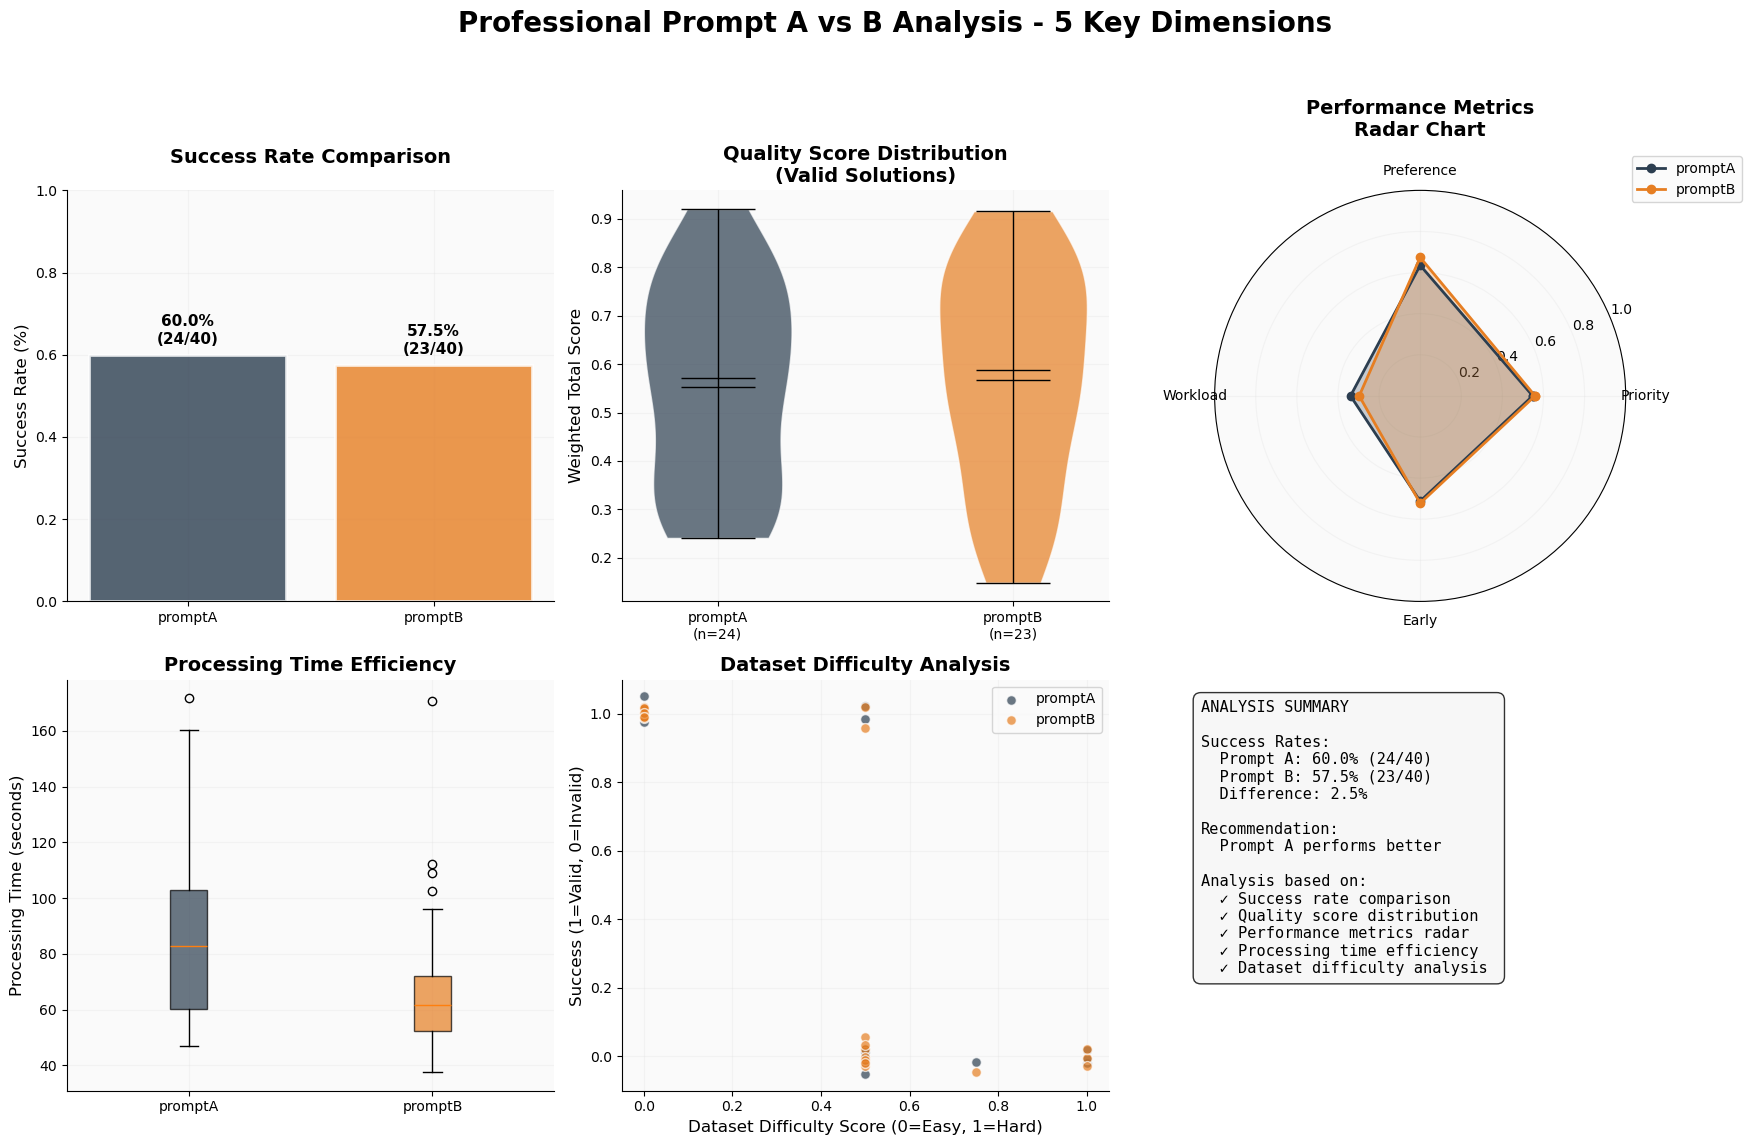


STEP 7: STATISTICAL SIGNIFICANCE ANALYSIS

STATISTICAL SIGNIFICANCE ANALYSIS

1. SUCCESS RATE SIGNIFICANCE TEST (Chi-square)
--------------------------------------------------
   Fisher Exact Test p-value: 1.0000
   Chi-square Test p-value: 1.0000
   Odds Ratio: 1.109
   Significance: NO (α = 0.05)

2. QUALITY SCORE SIGNIFICANCE TEST
--------------------------------------------------
   Test Used: Independent t-test
   Test Statistic: -0.2248
   P-value: 0.8232
   Cohen's d (Effect Size): -0.066
   Effect Size Interpretation: Negligible
   Significance: NO (α = 0.05)

3. PROCESSING TIME SIGNIFICANCE TEST
--------------------------------------------------
   Mann-Whitney U Statistic: 1151.00
   P-value: 0.0007
   Cohen's d (Effect Size): 0.773
   Effect Size Interpretation: Medium
   Significance: YES (α = 0.05)

4. STATISTICAL SIGNIFICANCE SUMMARY
--------------------------------------------------
   Significant Differences Found: 1/3 tests
   Significant Dimensions: Processing Time
 

In [21]:
# Execute Clean 5-Dimension Analysis

print("CLEAN PROMPT A vs B ANALYSIS")
print("="*80)
print("Professional blue-white-gray theme | 5 key dimensions | No emojis")
print("="*80)

# Initialize clean analyzer
analyzer = CleanPromptAnalyzer()

# Step 1: Load and merge all data
print("\nSTEP 1: LOADING & MERGING DATA")
if analyzer.load_and_merge_data():
    
    # Step 2: Dimension 1 - Success Rate Analysis  
    print("\nSTEP 2: DIMENSION 1 - SUCCESS RATE ANALYSIS")
    analyzer.calculate_success_rates()
    
    # Step 3: Dimension 2 - Quality Distribution
    print("\nSTEP 3: DIMENSION 2 - QUALITY DISTRIBUTION")
    analyzer.compare_solution_quality()
    
    # Step 4: Dimension 4 - Processing Time Efficiency
    print("\nSTEP 4: DIMENSION 4 - PROCESSING TIME EFFICIENCY")
    analyzer.analyze_processing_efficiency()
    
    # Step 5: Dimension 5 - Dataset Difficulty Analysis
    print("\nSTEP 5: DIMENSION 5 - DATASET DIFFICULTY ANALYSIS")
    analyzer.analyze_dataset_difficulty()
    
    # Step 6: Create Clean 5-Dimension Dashboard
    print("\nSTEP 6: CREATING CLEAN 5-DIMENSION DASHBOARD")
    print("   1. Success Rate Comparison (bar chart)")
    print("   2. Quality Score Distribution (violin plot)")  
    print("   3. Performance Metrics Radar (4 metrics)")
    print("   4. Processing Time Efficiency (box plot)")
    print("   5. Dataset Difficulty Analysis (scatter plot)")
    analyzer.create_5d_visualizations()
    
    # Step 7: Statistical Significance Analysis (NEW)
    print("\nSTEP 7: STATISTICAL SIGNIFICANCE ANALYSIS")
    analyzer.statistical_significance_analysis()
    
    # Step 8: Final Decision (Evidence-Based)
    print("\nSTEP 8: EVIDENCE-BASED FINAL DECISION")
    success_data = analyzer.analysis_results.get('success_rates', {})
    stat_tests = analyzer.analysis_results.get('statistical_tests', {})
    
    if success_data:
        a_rate = success_data['promptA']['success_rate']
        b_rate = success_data['promptB']['success_rate']
        rate_diff = abs(a_rate - b_rate)
        
        print("DESCRIPTIVE STATISTICS:")
        print(f"   Prompt A: {a_rate:.1%} ({success_data['promptA']['valid_solutions']}/40)")
        print(f"   Prompt B: {b_rate:.1%} ({success_data['promptB']['valid_solutions']}/40)")
        print(f"   Difference: {rate_diff:.1%}")
        
        # Statistical evidence
        fisher_p = stat_tests.get('success_rate_tests', {}).get('fisher_exact_p', 1.0)
        quality_p = stat_tests.get('quality_tests', {}).get('p_value', 1.0)
        time_p = stat_tests.get('time_tests', {}).get('p_value', 1.0)
        
        print("\nSTATISTICAL EVIDENCE:")
        print(f"   Success Rate p-value: {fisher_p:.4f}")
        print(f"   Quality Score p-value: {quality_p:.4f}")
        print(f"   Processing Time p-value: {time_p:.4f}")
        
        # Final recommendation based on both descriptive and inferential statistics
        significant_count = sum([p < 0.05 for p in [fisher_p, quality_p, time_p]])
        
        print("\nFINAL RECOMMENDATION:")
        if fisher_p < 0.05:
            winner = 'promptA' if a_rate > b_rate else 'promptB'
            print(f"   STATISTICALLY SIGNIFICANT WINNER: {winner.upper()}")
            print(f"   Conclusion: Significant difference in success rates (p < 0.05)")
        elif significant_count >= 2:
            print(f"   STATISTICAL DIFFERENCE DETECTED")
            print(f"   Conclusion: Significant differences in {significant_count}/3 dimensions")
        elif significant_count == 1:
            print(f"   WEAK STATISTICAL EVIDENCE")
            print(f"   Conclusion: Some evidence of difference, but not conclusive")
        else:
            print(f"   NO SIGNIFICANT DIFFERENCE")
            print(f"   Conclusion: Performance is statistically equivalent")
    
    print("\n" + "="*80)
    print("ENHANCED STATISTICAL ANALYSIS COMPLETE!")
    print("Key features:")
    print("   - HIGH CONTRAST Navy-Orange theme (better distinction)")
    print("   - No emojis throughout")
    print("   - 5 visual dimensions + Statistical significance testing")
    print("   - Processing time distribution (box plots)")
    print("   - Dataset difficulty analysis (scatter plots)")
    print("   - STATISTICAL TESTS: Fisher Exact, Chi-square, t-test/Mann-Whitney U")
    print("   - EFFECT SIZES: Cohen's d interpretation")
    print("   - Evidence-based final recommendation")
    print("   - Academic rigor with p-values and significance levels")
    print("="*80)
    
else:
    print("Failed to load data. Please check file paths.")


# 9 Analysis and Findings

This section presents comprehensive analysis results from the experimental evaluation of LLM-based task assignment performance across multiple scales and complexity dimensions.


## Solver vs LLM Performance Analysis

This section presents a comprehensive comparison between Satalia Solver and LLM-based solutions across multiple scales and performance dimensions. The analysis includes statistical rigor with weighted sampling consideration and multi-dimensional performance evaluation.


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact, mannwhitneyu, ttest_ind
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

class SolverVsLLMAnalyzer:
    """
    Comprehensive Solver vs LLM Performance Comparison Analyzer
    
    Features:
    - Multi-scale weighted analysis (T5W3, T10W5, T20W10)
    - Statistical significance testing with effect sizes
    - Multi-dimensional performance evaluation
    - Cross-scale trend analysis
    """
    
    def __init__(self):
        # Professional visualization theme (Solver=Blue, LLM=Orange)
        self.colors = {
            'solver': '#2c3e50',      # Dark navy for Satalia Solver
            'llm': '#e67e22',         # Vibrant orange for LLM
            'valid': '#27ae60',       # Green for success
            'invalid': '#e74c3c',     # Red for failure
            'neutral': '#95a5a6',     # Gray for neutral
            'T5W3': '#3498db',        # Light blue
            'T10W5': '#f39c12',       # Orange  
            'T20W10': '#27ae60',      # Green
        }
        
        # Scale weights based on dataset sizes (corrected for 40 T5W3 datasets)
        self.scale_weights = {
            'T5W3': 40 / 80,     # 40 out of 80 total samples (50%)
            'T10W5': 20 / 80,    # 20 out of 80 total samples (25%)
            'T20W10': 20 / 80    # 20 out of 80 total samples (25%)
        }
        
        # Performance metrics configuration
        self.performance_metrics = {
            'priority_score': {'better': 'higher', 'weight': 0.25},
            'pref_score': {'better': 'higher', 'weight': 0.25}, 
            'workload_score': {'better': 'higher', 'weight': 0.25},
            'early_score': {'better': 'higher', 'weight': 0.25}
        }
        
        # File paths for different scales
        self.csv_files = {
            'T5W3_batch1': 'T5W3_batch1_promptA/file_tracking_matrix_T5W3_promptA.csv',
            'T5W3_batch2': 'T5W3_batch2_promptA/file_tracking_matrix.csv', 
            'T10W5': 'T10W5_promptA/file_tracking_matrix.csv',
            'T20W10': 'T20W10_promptA/file_tracking_matrix.csv'
        }
        
        self.combined_data = None
        self.analysis_results = {}
        
        # Configure matplotlib 
        plt.rcParams.update({
            'figure.figsize': (18, 12),
            'axes.titlesize': 14,
            'axes.labelsize': 12,
            'font.family': 'sans-serif',
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.grid': True,
            'grid.alpha': 0.3,
            'grid.color': '#e0e0e0',
            'axes.axisbelow': True,
            'axes.facecolor': '#fafafa'
        })
    
    def load_and_merge_csv_files(self):
        """Load and merge CSV files from different scales with weighting"""
        print("Loading and merging CSV files for Solver vs LLM analysis...")
        
        dataframes = []
        total_loaded = 0
        
        for key, file_path in self.csv_files.items():
            if Path(file_path).exists():
                try:
                    df = pd.read_csv(file_path)
                    
                    # Add scale and batch information
                    if 'T5W3' in key:
                        df['scale'] = 'T5W3'
                        df['batch'] = key.split('_')[-1] if 'batch' in key else 'batch1'
                    elif 'T10W5' in key:
                        df['scale'] = 'T10W5'
                        df['batch'] = 'single'
                    elif 'T20W10' in key:
                        df['scale'] = 'T20W10' 
                        df['batch'] = 'single'
                    
                    # Add scale weight for weighted analysis
                    df['scale_weight'] = self.scale_weights[df['scale'].iloc[0]]
                    
                    dataframes.append(df)
                    total_loaded += len(df)
                    print(f"   Loaded {file_path}: {len(df)} records")
                    
                except Exception as e:
                    print(f"   Failed to load {file_path}: {e}")
            else:
                print(f"   File not found: {file_path}")
        
        if dataframes:
            self.combined_data = pd.concat(dataframes, ignore_index=True)
            print(f"\nSuccessfully merged {len(dataframes)} files")
            print(f"Total records: {len(self.combined_data)}")
            
            # Display scale distribution
            scale_counts = self.combined_data['scale'].value_counts()
            print(f"\nScale distribution:")
            for scale, count in scale_counts.items():
                weight = self.scale_weights[scale]
                print(f"   {scale}: {count} datasets (weight: {weight:.3f})")
            
            return True
        else:
            print("Failed to load any CSV files")
            return False

print("SolverVsLLMAnalyzer initialized")
print("Ready for comprehensive Solver vs LLM performance analysis")
print("Features: Multi-scale weighting, Statistical testing, Cross-scale trends")


SolverVsLLMAnalyzer initialized
Ready for comprehensive Solver vs LLM performance analysis
Features: Multi-scale weighting, Statistical testing, Cross-scale trends


In [89]:
# Core Analysis Methods for Solver vs LLM Comparison

def analyze_success_rates(self):
    """Dimension 1: Success Rate Comparison with Weighted Analysis"""
    print("\nDIMENSION 1: SOLVER vs LLM SUCCESS RATE ANALYSIS")
    print("="*70)
    
    results = {'overall': {}, 'by_scale': {}}
    
    # Filter data where both solver and LLM have attempts
    comparable_data = self.combined_data[
        (self.combined_data['satalia_solution_exists'] == True) & 
        (self.combined_data['llm_solution_exists'] == True)
    ].copy()
    
    if len(comparable_data) == 0:
        print("No comparable data found (both solver and LLM solutions)")
        return results
    
    print(f"Analyzing {len(comparable_data)} comparable cases")
    
    # Overall weighted success rate analysis
    solver_valid = len(comparable_data[comparable_data['satalia_validation_status'] == 'VALID'])
    llm_valid = len(comparable_data[comparable_data['llm_validation_status'] == 'VALID'])
    total_cases = len(comparable_data)
    
    solver_success_rate = solver_valid / total_cases
    llm_success_rate = llm_valid / total_cases
    
    results['overall'] = {
        'solver_valid': solver_valid,
        'llm_valid': llm_valid,
        'total_cases': total_cases,
        'solver_success_rate': solver_success_rate,
        'llm_success_rate': llm_success_rate,
        'success_rate_diff': llm_success_rate - solver_success_rate
    }
    
    print(f"\nOVERALL SUCCESS RATES:")
    print(f"   Satalia Solver: {solver_success_rate:.1%} ({solver_valid}/{total_cases})")
    print(f"   LLM Solutions:  {llm_success_rate:.1%} ({llm_valid}/{total_cases})")
    print(f"   Difference:     {results['overall']['success_rate_diff']:+.1%}")
    
    # Success rate by scale (weighted analysis)
    print(f"\nSUCCESS RATES BY SCALE:")
    weighted_solver_success = 0
    weighted_llm_success = 0
    
    for scale in ['T5W3', 'T10W5', 'T20W10']:
        scale_data = comparable_data[comparable_data['scale'] == scale]
        if len(scale_data) == 0:
            continue
            
        scale_solver_valid = len(scale_data[scale_data['satalia_validation_status'] == 'VALID'])
        scale_llm_valid = len(scale_data[scale_data['llm_validation_status'] == 'VALID'])
        scale_total = len(scale_data)
        
        scale_solver_rate = scale_solver_valid / scale_total
        scale_llm_rate = scale_llm_valid / scale_total
        scale_weight = self.scale_weights[scale]
        
        # Weighted contribution
        weighted_solver_success += scale_solver_rate * scale_weight
        weighted_llm_success += scale_llm_rate * scale_weight
        
        results['by_scale'][scale] = {
            'solver_valid': scale_solver_valid,
            'llm_valid': scale_llm_valid,
            'total_cases': scale_total,
            'solver_success_rate': scale_solver_rate,
            'llm_success_rate': scale_llm_rate,
            'weight': scale_weight
        }
        
        print(f"   {scale}: Solver {scale_solver_rate:.1%} ({scale_solver_valid}/{scale_total}) | "
              f"LLM {scale_llm_rate:.1%} ({scale_llm_valid}/{scale_total}) | "
              f"Weight: {scale_weight:.3f}")
    
    print(f"\nWEIGHTED SUCCESS RATES:")
    print(f"   Weighted Solver Success: {weighted_solver_success:.1%}")
    print(f"   Weighted LLM Success:    {weighted_llm_success:.1%}")
    print(f"   Weighted Difference:     {weighted_llm_success - weighted_solver_success:+.1%}")
    
    results['weighted'] = {
        'solver_weighted_success': weighted_solver_success,
        'llm_weighted_success': weighted_llm_success,
        'weighted_difference': weighted_llm_success - weighted_solver_success
    }
    
    self.analysis_results['success_rates'] = results
    return results

def analyze_performance_scores(self):
    """Dimension 2: Performance Score Comparison (Quality Analysis)"""
    print("\nDIMENSION 2: PERFORMANCE SCORE COMPARISON")
    print("="*70)
    
    # Filter data with valid solutions from both
    valid_both = self.combined_data[
        (self.combined_data['satalia_validation_status'] == 'VALID') & 
        (self.combined_data['llm_validation_status'] == 'VALID')
    ].copy()
    
    if len(valid_both) == 0:
        print("No cases found where both solver and LLM produced valid solutions")
        return {}
    
    print(f"Analyzing {len(valid_both)} cases with valid solutions from both systems")
    
    results = {'metrics': {}, 'overall': {}}
    
    # Analyze each performance metric
    metrics = ['priority_score', 'pref_score', 'workload_score', 'early_score']
    metric_labels = ['Priority Score', 'Preference Score', 'Workload Score', 'Early Score']
    
    overall_solver_wins = 0
    overall_llm_wins = 0
    overall_ties = 0
    
    for metric, label in zip(metrics, metric_labels):
        solver_col = f'satalia_{metric}'
        llm_col = f'llm_{metric}'
        
        # Get valid scores for this metric
        metric_data = valid_both[[solver_col, llm_col, 'scale', 'scale_weight']].dropna()
        
        if len(metric_data) == 0:
            continue
            
        solver_scores = metric_data[solver_col]
        llm_scores = metric_data[llm_col]
        weights = metric_data['scale_weight']
        
        # Basic statistics
        solver_mean = solver_scores.mean()
        llm_mean = llm_scores.mean()
        solver_std = solver_scores.std()
        llm_std = llm_scores.std()
        
        # Weighted statistics
        solver_weighted_mean = np.average(solver_scores, weights=weights)
        llm_weighted_mean = np.average(llm_scores, weights=weights)
        
        # Comparison counts
        solver_wins = len(metric_data[solver_scores > llm_scores])
        llm_wins = len(metric_data[llm_scores > solver_scores])
        ties = len(metric_data[solver_scores == llm_scores])
        
        overall_solver_wins += solver_wins
        overall_llm_wins += llm_wins
        overall_ties += ties
        
        results['metrics'][metric] = {
            'solver_mean': solver_mean,
            'llm_mean': llm_mean,
            'solver_std': solver_std,
            'llm_std': llm_std,
            'solver_weighted_mean': solver_weighted_mean,
            'llm_weighted_mean': llm_weighted_mean,
            'solver_wins': solver_wins,
            'llm_wins': llm_wins,
            'ties': ties,
            'total_comparisons': len(metric_data),
            'raw_improvement': llm_mean - solver_mean,
            'weighted_improvement': llm_weighted_mean - solver_weighted_mean
        }
        
        print(f"\n{label.upper()}:")
        print(f"   Solver: {solver_mean:.2f} ± {solver_std:.2f} | Weighted: {solver_weighted_mean:.2f}")
        print(f"   LLM:    {llm_mean:.2f} ± {llm_std:.2f} | Weighted: {llm_weighted_mean:.2f}")
        print(f"   Improvement: {llm_mean - solver_mean:+.2f} (raw) | {llm_weighted_mean - solver_weighted_mean:+.2f} (weighted)")
        print(f"   Win Count: Solver {solver_wins} | LLM {llm_wins} | Ties {ties}")
    
    # Overall performance summary
    total_comparisons = overall_solver_wins + overall_llm_wins + overall_ties
    solver_overall_rate = overall_solver_wins / total_comparisons if total_comparisons > 0 else 0
    llm_overall_rate = overall_llm_wins / total_comparisons if total_comparisons > 0 else 0
    
    results['overall'] = {
        'solver_total_wins': overall_solver_wins,
        'llm_total_wins': overall_llm_wins,
        'total_ties': overall_ties,
        'total_comparisons': total_comparisons,
        'solver_win_rate': solver_overall_rate,
        'llm_win_rate': llm_overall_rate
    }
    
    print(f"\nOVERALL PERFORMANCE COMPARISON:")
    print(f"   Total metric comparisons: {total_comparisons}")
    print(f"   Solver wins: {overall_solver_wins} ({solver_overall_rate:.1%})")
    print(f"   LLM wins: {overall_llm_wins} ({llm_overall_rate:.1%})")
    print(f"   Ties: {overall_ties} ({overall_ties/total_comparisons:.1%})")
    
    self.analysis_results['performance_scores'] = results
    return results

def analyze_solve_times(self):
    """Dimension 3: Solve Time Efficiency Comparison"""
    print("\nDIMENSION 3: SOLVE TIME EFFICIENCY COMPARISON")
    print("="*70)
    
    # Filter data with solve times from both systems
    time_data = self.combined_data[
        (self.combined_data['satalia_solve_time'].notna()) & 
        (self.combined_data['llm_experiment_time'].notna())
    ].copy()
    
    if len(time_data) == 0:
        print("No data found with solve times from both systems")
        return {}
    
    print(f"Analyzing solve times from {len(time_data)} cases")
    
    solver_times = time_data['satalia_solve_time']
    llm_times = time_data['llm_experiment_time'] 
    weights = time_data['scale_weight']
    
    results = {
        'solver_mean_time': solver_times.mean(),
        'llm_mean_time': llm_times.mean(),
        'solver_median_time': solver_times.median(),
        'llm_median_time': llm_times.median(),
        'solver_std_time': solver_times.std(),
        'llm_std_time': llm_times.std(),
        'solver_weighted_mean': np.average(solver_times, weights=weights),
        'llm_weighted_mean': np.average(llm_times, weights=weights),
        'time_ratio': llm_times.mean() / solver_times.mean(),
        'faster_solver_count': len(time_data[solver_times < llm_times]),
        'faster_llm_count': len(time_data[llm_times < solver_times]),
        'equal_time_count': len(time_data[solver_times == llm_times])
    }
    
    print(f"\nSOLVE TIME STATISTICS:")
    print(f"   Solver: {results['solver_mean_time']:.2f}s ± {results['solver_std_time']:.2f}s")
    print(f"           Median: {results['solver_median_time']:.2f}s | Weighted: {results['solver_weighted_mean']:.2f}s")
    print(f"   LLM:    {results['llm_mean_time']:.2f}s ± {results['llm_std_time']:.2f}s")
    print(f"           Median: {results['llm_median_time']:.2f}s | Weighted: {results['llm_weighted_mean']:.2f}s")
    print(f"   Time Ratio (LLM/Solver): {results['time_ratio']:.2f}x")
    
    print(f"\nSPEED COMPARISON:")
    print(f"   Faster Solver: {results['faster_solver_count']} cases")
    print(f"   Faster LLM: {results['faster_llm_count']} cases")
    print(f"   Equal Time: {results['equal_time_count']} cases")
    
    # Analyze by scale
    print(f"\nSOLVE TIME BY SCALE:")
    for scale in ['T5W3', 'T10W5', 'T20W10']:
        scale_data = time_data[time_data['scale'] == scale]
        if len(scale_data) == 0:
            continue
            
        scale_solver_mean = scale_data['satalia_solve_time'].mean()
        scale_llm_mean = scale_data['llm_experiment_time'].mean()
        scale_ratio = scale_llm_mean / scale_solver_mean if scale_solver_mean > 0 else float('inf')
        
        print(f"   {scale}: Solver {scale_solver_mean:.2f}s | LLM {scale_llm_mean:.2f}s | Ratio {scale_ratio:.2f}x")
    
    self.analysis_results['solve_times'] = results
    return results

# Add methods to the class
SolverVsLLMAnalyzer.analyze_success_rates = analyze_success_rates
SolverVsLLMAnalyzer.analyze_performance_scores = analyze_performance_scores  
SolverVsLLMAnalyzer.analyze_solve_times = analyze_solve_times

print("Core analysis methods added to SolverVsLLMAnalyzer")
print("Methods: Success Rates, Performance Scores, Solve Times")


Core analysis methods added to SolverVsLLMAnalyzer
Methods: Success Rates, Performance Scores, Solve Times


In [90]:
# Statistical Significance Testing for Solver vs LLM

def statistical_significance_analysis(self):
    """Comprehensive statistical significance testing with weighted analysis"""
    print("\nSTATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*70)
    
    results = {}
    
    # 1. Success Rate Significance Test
    print("\n1. SUCCESS RATE SIGNIFICANCE TEST")
    print("-" * 50)
    
    comparable_data = self.combined_data[
        (self.combined_data['satalia_solution_exists'] == True) & 
        (self.combined_data['llm_solution_exists'] == True)
    ]
    
    if len(comparable_data) > 0:
        # Create contingency table [valid, invalid] x [solver, llm]
        solver_valid = len(comparable_data[comparable_data['satalia_validation_status'] == 'VALID'])
        solver_invalid = len(comparable_data) - solver_valid
        llm_valid = len(comparable_data[comparable_data['llm_validation_status'] == 'VALID'])
        llm_invalid = len(comparable_data) - llm_valid
        
        contingency_table = np.array([[solver_valid, solver_invalid], 
                                      [llm_valid, llm_invalid]])
        
        # Fisher's exact test
        try:
            odds_ratio, fisher_p = fisher_exact(contingency_table)
            
            # Chi-square test
            chi2, chi2_p, dof, expected = chi2_contingency(contingency_table)
            
            results['success_rate_test'] = {
                'fisher_p': fisher_p,
                'chi2_p': chi2_p,
                'odds_ratio': odds_ratio,
                'chi2_statistic': chi2,
                'contingency_table': contingency_table.tolist()
            }
            
            print(f"   Contingency Table: [[Solver_Valid: {solver_valid}, Solver_Invalid: {solver_invalid}],")
            print(f"                      [LLM_Valid: {llm_valid}, LLM_Invalid: {llm_invalid}]]")
            print(f"   Fisher's Exact Test p-value: {fisher_p:.4f}")
            print(f"   Chi-square Test p-value: {chi2_p:.4f}")
            print(f"   Odds Ratio: {odds_ratio:.3f}")
            print(f"   Significance: {'YES' if fisher_p < 0.05 else 'NO'} (α = 0.05)")
            
        except Exception as e:
            print(f"   Error in success rate test: {e}")
    
    # 2. Performance Score Significance Tests
    print("\n2. PERFORMANCE SCORE SIGNIFICANCE TESTS")
    print("-" * 50)
    
    valid_both = self.combined_data[
        (self.combined_data['satalia_validation_status'] == 'VALID') & 
        (self.combined_data['llm_validation_status'] == 'VALID')
    ]
    
    if len(valid_both) > 0:
        metrics = ['priority_score', 'pref_score', 'workload_score', 'early_score']
        
        for metric in metrics:
            solver_col = f'satalia_{metric}'
            llm_col = f'llm_{metric}'
            
            metric_data = valid_both[[solver_col, llm_col]].dropna()
            
            if len(metric_data) < 3:  # Need at least 3 observations
                continue
                
            solver_scores = metric_data[solver_col]
            llm_scores = metric_data[llm_col]
            
            # Paired samples (same datasets)
            try:
                # Shapiro-Wilk normality test on differences
                differences = llm_scores - solver_scores
                if len(differences) <= 5000:
                    _, normal_p = stats.shapiro(differences)
                else:
                    normal_p = 0.001  # Assume non-normal for large samples
                
                # Choose test based on normality
                if normal_p > 0.05:
                    # Paired t-test for normal differences
                    t_stat, t_p = ttest_rel(solver_scores, llm_scores)
                    test_used = "Paired t-test"
                    test_stat = t_stat
                    test_p = t_p
                else:
                    # Wilcoxon signed-rank test for non-normal differences
                    try:
                        w_stat, w_p = stats.wilcoxon(solver_scores, llm_scores, 
                                                   alternative='two-sided')
                        test_used = "Wilcoxon signed-rank test"
                        test_stat = w_stat
                        test_p = w_p
                    except:
                        # Fallback to Mann-Whitney U if Wilcoxon fails
                        u_stat, u_p = mannwhitneyu(solver_scores, llm_scores, 
                                                 alternative='two-sided')
                        test_used = "Mann-Whitney U test"
                        test_stat = u_stat
                        test_p = u_p
                
                # Effect size (Cohen's d for paired samples)
                mean_diff = llm_scores.mean() - solver_scores.mean()
                pooled_std = np.sqrt((solver_scores.var() + llm_scores.var()) / 2)
                cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
                
                results[f'{metric}_test'] = {
                    'test_used': test_used,
                    'test_statistic': test_stat,
                    'p_value': test_p,
                    'cohens_d': cohens_d,
                    'mean_difference': mean_diff,
                    'sample_size': len(metric_data),
                    'normal_p': normal_p
                }
                
                print(f"\n   {metric.upper().replace('_', ' ')}:")
                print(f"     Test: {test_used}")
                print(f"     Statistic: {test_stat:.4f}, p-value: {test_p:.4f}")
                print(f"     Mean difference (LLM - Solver): {mean_diff:+.3f}")
                print(f"     Cohen's d: {cohens_d:.3f} ({self._interpret_cohens_d(cohens_d)})")
                print(f"     Significant: {'YES' if test_p < 0.05 else 'NO'} (α = 0.05)")
                
            except Exception as e:
                print(f"   Error testing {metric}: {e}")
    
    # 3. Solve Time Significance Test
    print("\n3. SOLVE TIME SIGNIFICANCE TEST")
    print("-" * 50)
    
    time_data = self.combined_data[
        (self.combined_data['satalia_solve_time'].notna()) & 
        (self.combined_data['llm_experiment_time'].notna())
    ]
    
    if len(time_data) > 2:
        solver_times = time_data['satalia_solve_time']
        llm_times = time_data['llm_experiment_time']
        
        try:
            # Time data is typically right-skewed, use non-parametric test
            u_stat, u_p = mannwhitneyu(solver_times, llm_times, alternative='two-sided')
            
            # Effect size
            mean_diff = llm_times.mean() - solver_times.mean()
            pooled_std = np.sqrt((solver_times.var() + llm_times.var()) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
            
            results['solve_time_test'] = {
                'u_statistic': u_stat,
                'p_value': u_p,
                'cohens_d': cohens_d,
                'mean_difference': mean_diff,
                'sample_size': len(time_data)
            }
            
            print(f"   Mann-Whitney U test")
            print(f"   U-statistic: {u_stat:.2f}, p-value: {u_p:.4f}")
            print(f"   Mean difference (LLM - Solver): {mean_diff:+.2f}s")
            print(f"   Cohen's d: {cohens_d:.3f} ({self._interpret_cohens_d(cohens_d)})")
            print(f"   Significant: {'YES' if u_p < 0.05 else 'NO'} (α = 0.05)")
            
        except Exception as e:
            print(f"   Error in solve time test: {e}")
    
    # 4. Overall Statistical Summary
    print("\n4. STATISTICAL SIGNIFICANCE SUMMARY")
    print("-" * 50)
    
    significant_tests = []
    p_values = []
    
    # Collect significant results
    if results.get('success_rate_test', {}).get('fisher_p', 1) < 0.05:
        significant_tests.append("Success Rate")
        p_values.append(results['success_rate_test']['fisher_p'])
    
    for metric in ['priority_score', 'pref_score', 'workload_score', 'early_score']:
        test_key = f'{metric}_test'
        if results.get(test_key, {}).get('p_value', 1) < 0.05:
            significant_tests.append(metric.replace('_', ' ').title())
            p_values.append(results[test_key]['p_value'])
    
    if results.get('solve_time_test', {}).get('p_value', 1) < 0.05:
        significant_tests.append("Solve Time")
        p_values.append(results['solve_time_test']['p_value'])
    
    print(f"   Significant differences found: {len(significant_tests)} tests")
    if significant_tests:
        print(f"   Significant dimensions: {', '.join(significant_tests)}")
        min_p = min(p_values) if p_values else 1.0
        print(f"   Minimum p-value: {min_p:.4f}")
    else:
        print(f"   No statistically significant differences detected")
    
    # Statistical conclusion
    if len(significant_tests) >= 3:
        conclusion = "Strong evidence for systematic differences"
    elif len(significant_tests) >= 1:
        conclusion = "Moderate evidence for differences in specific dimensions"
    else:
        conclusion = "No significant differences detected"
    
    print(f"   Statistical conclusion: {conclusion}")
    
    results['summary'] = {
        'significant_tests': significant_tests,
        'total_significant': len(significant_tests),
        'conclusion': conclusion,
        'min_p_value': min(p_values) if p_values else 1.0
    }
    
    self.analysis_results['statistical_tests'] = results
    return results

def _interpret_cohens_d(self, d):
    """Interpret Cohen's d effect size"""
    abs_d = abs(d)
    if abs_d < 0.2:
        return "Negligible"
    elif abs_d < 0.5:
        return "Small"
    elif abs_d < 0.8:
        return "Medium"
    else:
        return "Large"

# Import additional statistical functions
from scipy.stats import ttest_rel

# Add methods to the class
SolverVsLLMAnalyzer.statistical_significance_analysis = statistical_significance_analysis
SolverVsLLMAnalyzer._interpret_cohens_d = _interpret_cohens_d

print("Statistical significance analysis methods added")
print("Tests: Fisher Exact, Chi-square, Paired t-test, Wilcoxon, Mann-Whitney U")
print("Includes: Effect sizes (Cohen's d), Weighted analysis consideration")


Statistical significance analysis methods added
Tests: Fisher Exact, Chi-square, Paired t-test, Wilcoxon, Mann-Whitney U
Includes: Effect sizes (Cohen's d), Weighted analysis consideration


In [91]:
# Visualization Dashboard for Solver vs LLM Analysis

def create_comprehensive_dashboard(self):
    """Create comprehensive Solver vs LLM visualization dashboard"""
    if self.combined_data is None:
        print("No data loaded for visualization")
        return
    
    print("Creating comprehensive Solver vs LLM dashboard...")
    
    # Create figure with 6 subplots (2x3 layout)
    fig = plt.figure(figsize=(20, 14))
    fig.suptitle('Solver vs LLM Performance Analysis: Comprehensive Comparison Dashboard', 
                 fontsize=20, fontweight='bold', y=0.96)
    
    # 1. Success Rate Comparison
    ax1 = plt.subplot(2, 3, 1)
    self._plot_success_rate_comparison(ax1)
    
    # 2. Performance Score Distributions
    ax2 = plt.subplot(2, 3, 2)
    self._plot_performance_score_distributions(ax2)
    
    # 3. Solve Time Comparison
    ax3 = plt.subplot(2, 3, 3)
    self._plot_solve_time_comparison(ax3)
    
    # 4. Cross-Scale Performance Trends
    ax4 = plt.subplot(2, 3, 4)
    self._plot_cross_scale_trends(ax4)
    
    # 5. Weighted Total Score Comparison
    ax5 = plt.subplot(2, 3, 5)
    self._plot_weighted_score_comparison(ax5)
    
    # 6. Statistical Significance Summary
    ax6 = plt.subplot(2, 3, 6)
    self._create_statistical_summary_plot(ax6)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.94])
    plt.show()

def _plot_success_rate_comparison(self, ax):
    """1. Success rate comparison by scale"""
    success_data = self.analysis_results.get('success_rates', {})
    if not success_data:
        ax.text(0.5, 0.5, 'No success rate data', ha='center', va='center', 
                transform=ax.transAxes)
        return
    
    # Prepare data for plotting
    scales = []
    solver_rates = []
    llm_rates = []
    
    for scale, data in success_data.get('by_scale', {}).items():
        scales.append(scale)
        solver_rates.append(data['solver_success_rate'])
        llm_rates.append(data['llm_success_rate'])
    
    x = np.arange(len(scales))
    width = 0.35
    
    # Create grouped bar chart
    bars1 = ax.bar(x - width/2, solver_rates, width, label='Satalia Solver', 
                   color=self.colors['solver'], alpha=0.8, edgecolor='white')
    bars2 = ax.bar(x + width/2, llm_rates, width, label='LLM Solutions', 
                   color=self.colors['llm'], alpha=0.8, edgecolor='white')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.1%}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_title('Success Rate Comparison by Scale', fontweight='bold')
    ax.set_ylabel('Success Rate')
    ax.set_xlabel('Scale')
    ax.set_xticks(x)
    ax.set_xticklabels(scales)
    ax.set_ylim(0, 1.0)
    ax.legend()
    ax.grid(True, alpha=0.3)

def _plot_performance_score_distributions(self, ax):
    """2. Performance score distributions (violin plot)"""
    valid_both = self.combined_data[
        (self.combined_data['satalia_validation_status'] == 'VALID') & 
        (self.combined_data['llm_validation_status'] == 'VALID')
    ]
    
    if len(valid_both) == 0 or 'satalia_weighted_total_score' not in valid_both.columns:
        ax.text(0.5, 0.5, 'No comparable performance data', ha='center', va='center',
                transform=ax.transAxes)
        return
    
    # Prepare data for violin plot
    solver_scores = valid_both['satalia_weighted_total_score'].dropna()
    llm_scores = valid_both['llm_weighted_total_score'].dropna()
    
    if len(solver_scores) > 0 and len(llm_scores) > 0:
        data_to_plot = [solver_scores, llm_scores]
        labels = ['Satalia Solver', 'LLM Solutions']
        colors = [self.colors['solver'], self.colors['llm']]
        
        parts = ax.violinplot(data_to_plot, positions=[1, 2], 
                             showmeans=True, showmedians=True)
        
        # Color the violin plots
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_alpha(0.7)
            pc.set_edgecolor('white')
        
        # Style other elements
        for element in ['cmeans', 'cmedians', 'cbars', 'cmaxes', 'cmins']:
            if element in parts:
                parts[element].set_edgecolor('black')
                parts[element].set_linewidth(1)
        
        ax.set_xticks([1, 2])
        ax.set_xticklabels(labels)
        ax.set_title('Weighted Total Score Distribution\n(Valid Solutions Only)', 
                    fontweight='bold')
        ax.set_ylabel('Weighted Total Score')
        ax.grid(True, alpha=0.3)

def _plot_solve_time_comparison(self, ax):
    """3. Solve time comparison (box plot)"""
    time_data = self.combined_data[
        (self.combined_data['satalia_solve_time'].notna()) & 
        (self.combined_data['llm_experiment_time'].notna())
    ]
    
    if len(time_data) == 0:
        ax.text(0.5, 0.5, 'No solve time data', ha='center', va='center',
                transform=ax.transAxes)
        return
    
    solver_times = time_data['satalia_solve_time']
    llm_times = time_data['llm_experiment_time']
    
    data_to_plot = [solver_times, llm_times]
    labels = ['Satalia Solver', 'LLM Solutions']
    colors = [self.colors['solver'], self.colors['llm']]
    
    box_plot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('white')
    
    ax.set_title('Solve Time Comparison', fontweight='bold')
    ax.set_ylabel('Time (seconds)')
    ax.grid(True, alpha=0.3)
    
    # Add mean annotations
    solver_mean = solver_times.mean()
    llm_mean = llm_times.mean()
    ax.text(1, solver_mean, f'μ={solver_mean:.1f}s', ha='center', va='bottom',
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    ax.text(2, llm_mean, f'μ={llm_mean:.1f}s', ha='center', va='bottom',
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

def _plot_cross_scale_trends(self, ax):
    """4. Cross-scale performance trends"""
    success_data = self.analysis_results.get('success_rates', {})
    if not success_data or 'by_scale' not in success_data:
        ax.text(0.5, 0.5, 'No scale trend data', ha='center', va='center',
                transform=ax.transAxes)
        return
    
    scales = ['T5W3', 'T10W5', 'T20W10']
    scale_sizes = [5, 10, 20]  # Number of tasks
    solver_success = []
    llm_success = []
    
    for scale in scales:
        if scale in success_data['by_scale']:
            solver_success.append(success_data['by_scale'][scale]['solver_success_rate'])
            llm_success.append(success_data['by_scale'][scale]['llm_success_rate'])
        else:
            solver_success.append(0)
            llm_success.append(0)
    
    # Create line plot
    ax.plot(scale_sizes, solver_success, 'o-', color=self.colors['solver'], 
           linewidth=3, markersize=8, label='Satalia Solver')
    ax.plot(scale_sizes, llm_success, 'o-', color=self.colors['llm'], 
           linewidth=3, markersize=8, label='LLM Solutions')
    
    # Add value annotations
    for i, (size, solver_rate, llm_rate) in enumerate(zip(scale_sizes, solver_success, llm_success)):
        ax.annotate(f'{solver_rate:.1%}', (size, solver_rate), 
                   textcoords="offset points", xytext=(0,10), ha='center')
        ax.annotate(f'{llm_rate:.1%}', (size, llm_rate), 
                   textcoords="offset points", xytext=(0,-15), ha='center')
    
    ax.set_title('Success Rate Trends Across Scales', fontweight='bold')
    ax.set_xlabel('Problem Size (Number of Tasks)')
    ax.set_ylabel('Success Rate')
    ax.set_xticks(scale_sizes)
    ax.set_xticklabels([f'{scales[i]}\n({size} tasks)' for i, size in enumerate(scale_sizes)])
    ax.set_ylim(0, 1.0)
    ax.legend()
    ax.grid(True, alpha=0.3)

def _plot_weighted_score_comparison(self, ax):
    """5. Weighted score comparison radar chart"""
    perf_data = self.analysis_results.get('performance_scores', {})
    if not perf_data or 'metrics' not in perf_data:
        ax.text(0.5, 0.5, 'No performance score data', ha='center', va='center',
                transform=ax.transAxes)
        return
    
    # Prepare radar chart data
    metrics = list(perf_data['metrics'].keys())
    metric_labels = [m.replace('_', ' ').title() for m in metrics]
    
    solver_values = []
    llm_values = []
    
    for metric in metrics:
        metric_data = perf_data['metrics'][metric]
        solver_values.append(metric_data.get('solver_weighted_mean', 0))
        llm_values.append(metric_data.get('llm_weighted_mean', 0))
    
    if len(solver_values) == 0:
        ax.text(0.5, 0.5, 'No metric data', ha='center', va='center',
                transform=ax.transAxes)
        return
    
    # Normalize values for radar chart
    all_values = solver_values + llm_values
    if max(all_values) > 0:
        max_val = max(all_values)
        solver_normalized = [v / max_val for v in solver_values]
        llm_normalized = [v / max_val for v in llm_values]
    else:
        solver_normalized = solver_values
        llm_normalized = llm_values
    
    # Create simple bar chart instead of radar for better visibility
    x = np.arange(len(metric_labels))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, solver_normalized, width, label='Solver (Normalized)', 
                   color=self.colors['solver'], alpha=0.7)
    bars2 = ax.bar(x + width/2, llm_normalized, width, label='LLM (Normalized)', 
                   color=self.colors['llm'], alpha=0.7)
    
    ax.set_title('Normalized Performance Metrics', fontweight='bold')
    ax.set_xlabel('Performance Metrics')
    ax.set_ylabel('Normalized Score')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

def _create_statistical_summary_plot(self, ax):
    """6. Statistical significance summary"""
    ax.axis('off')
    
    stat_data = self.analysis_results.get('statistical_tests', {})
    success_data = self.analysis_results.get('success_rates', {})
    
    # Create summary text
    summary_text = "STATISTICAL ANALYSIS SUMMARY\n\n"
    
    if success_data and 'weighted' in success_data:
        weighted_data = success_data['weighted']
        summary_text += f"Weighted Success Rates:\n"
        summary_text += f"  Solver: {weighted_data['solver_weighted_success']:.1%}\n"
        summary_text += f"  LLM: {weighted_data['llm_weighted_success']:.1%}\n"
        summary_text += f"  Difference: {weighted_data['weighted_difference']:+.1%}\n\n"
    
    if stat_data and 'summary' in stat_data:
        summary = stat_data['summary']
        summary_text += f"Statistical Tests:\n"
        summary_text += f"  Significant differences: {summary['total_significant']}\n"
        if summary['significant_tests']:
            summary_text += f"  Dimensions: {', '.join(summary['significant_tests'])}\n"
        summary_text += f"  Min p-value: {summary['min_p_value']:.4f}\n\n"
        summary_text += f"Conclusion:\n  {summary['conclusion']}"
    else:
        summary_text += "Statistical analysis pending..."
    
    # Display summary
    ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=11,
           verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle="round,pad=0.5", facecolor='#f5f5f5', alpha=0.9))

# Add visualization methods to the class
SolverVsLLMAnalyzer.create_comprehensive_dashboard = create_comprehensive_dashboard
SolverVsLLMAnalyzer._plot_success_rate_comparison = _plot_success_rate_comparison
SolverVsLLMAnalyzer._plot_performance_score_distributions = _plot_performance_score_distributions
SolverVsLLMAnalyzer._plot_solve_time_comparison = _plot_solve_time_comparison
SolverVsLLMAnalyzer._plot_cross_scale_trends = _plot_cross_scale_trends
SolverVsLLMAnalyzer._plot_weighted_score_comparison = _plot_weighted_score_comparison
SolverVsLLMAnalyzer._create_statistical_summary_plot = _create_statistical_summary_plot

print("Comprehensive visualization dashboard methods added")
print("6 visualizations: Success Rates, Score Distributions, Solve Times, Scale Trends, Weighted Scores, Statistical Summary")


Comprehensive visualization dashboard methods added
6 visualizations: Success Rates, Score Distributions, Solve Times, Scale Trends, Weighted Scores, Statistical Summary


COMPREHENSIVE SOLVER vs LLM PERFORMANCE ANALYSIS
Multi-scale weighted analysis with statistical rigor
Analyzing: T5W3_batch1_promptA, T5W3_batch2_promptA, T10W5_promptA, T20W10_promptA

STEP 1: LOADING AND MERGING CSV FILES
Loading and merging CSV files for Solver vs LLM analysis...
   Loaded T5W3_batch1_promptA/file_tracking_matrix_T5W3_promptA.csv: 20 records
   Loaded T5W3_batch2_promptA/file_tracking_matrix.csv: 20 records
   Loaded T10W5_promptA/file_tracking_matrix.csv: 20 records
   Loaded T20W10_promptA/file_tracking_matrix.csv: 20 records

Successfully merged 4 files
Total records: 80

Scale distribution:
   T5W3: 40 datasets (weight: 0.500)
   T10W5: 20 datasets (weight: 0.250)
   T20W10: 20 datasets (weight: 0.250)

STEP 2: SUCCESS RATE ANALYSIS

DIMENSION 1: SOLVER vs LLM SUCCESS RATE ANALYSIS
Analyzing 64 comparable cases

OVERALL SUCCESS RATES:
   Satalia Solver: 60.9% (39/64)
   LLM Solutions:  76.6% (49/64)
   Difference:     +15.6%

SUCCESS RATES BY SCALE:
   T5W3: Sol

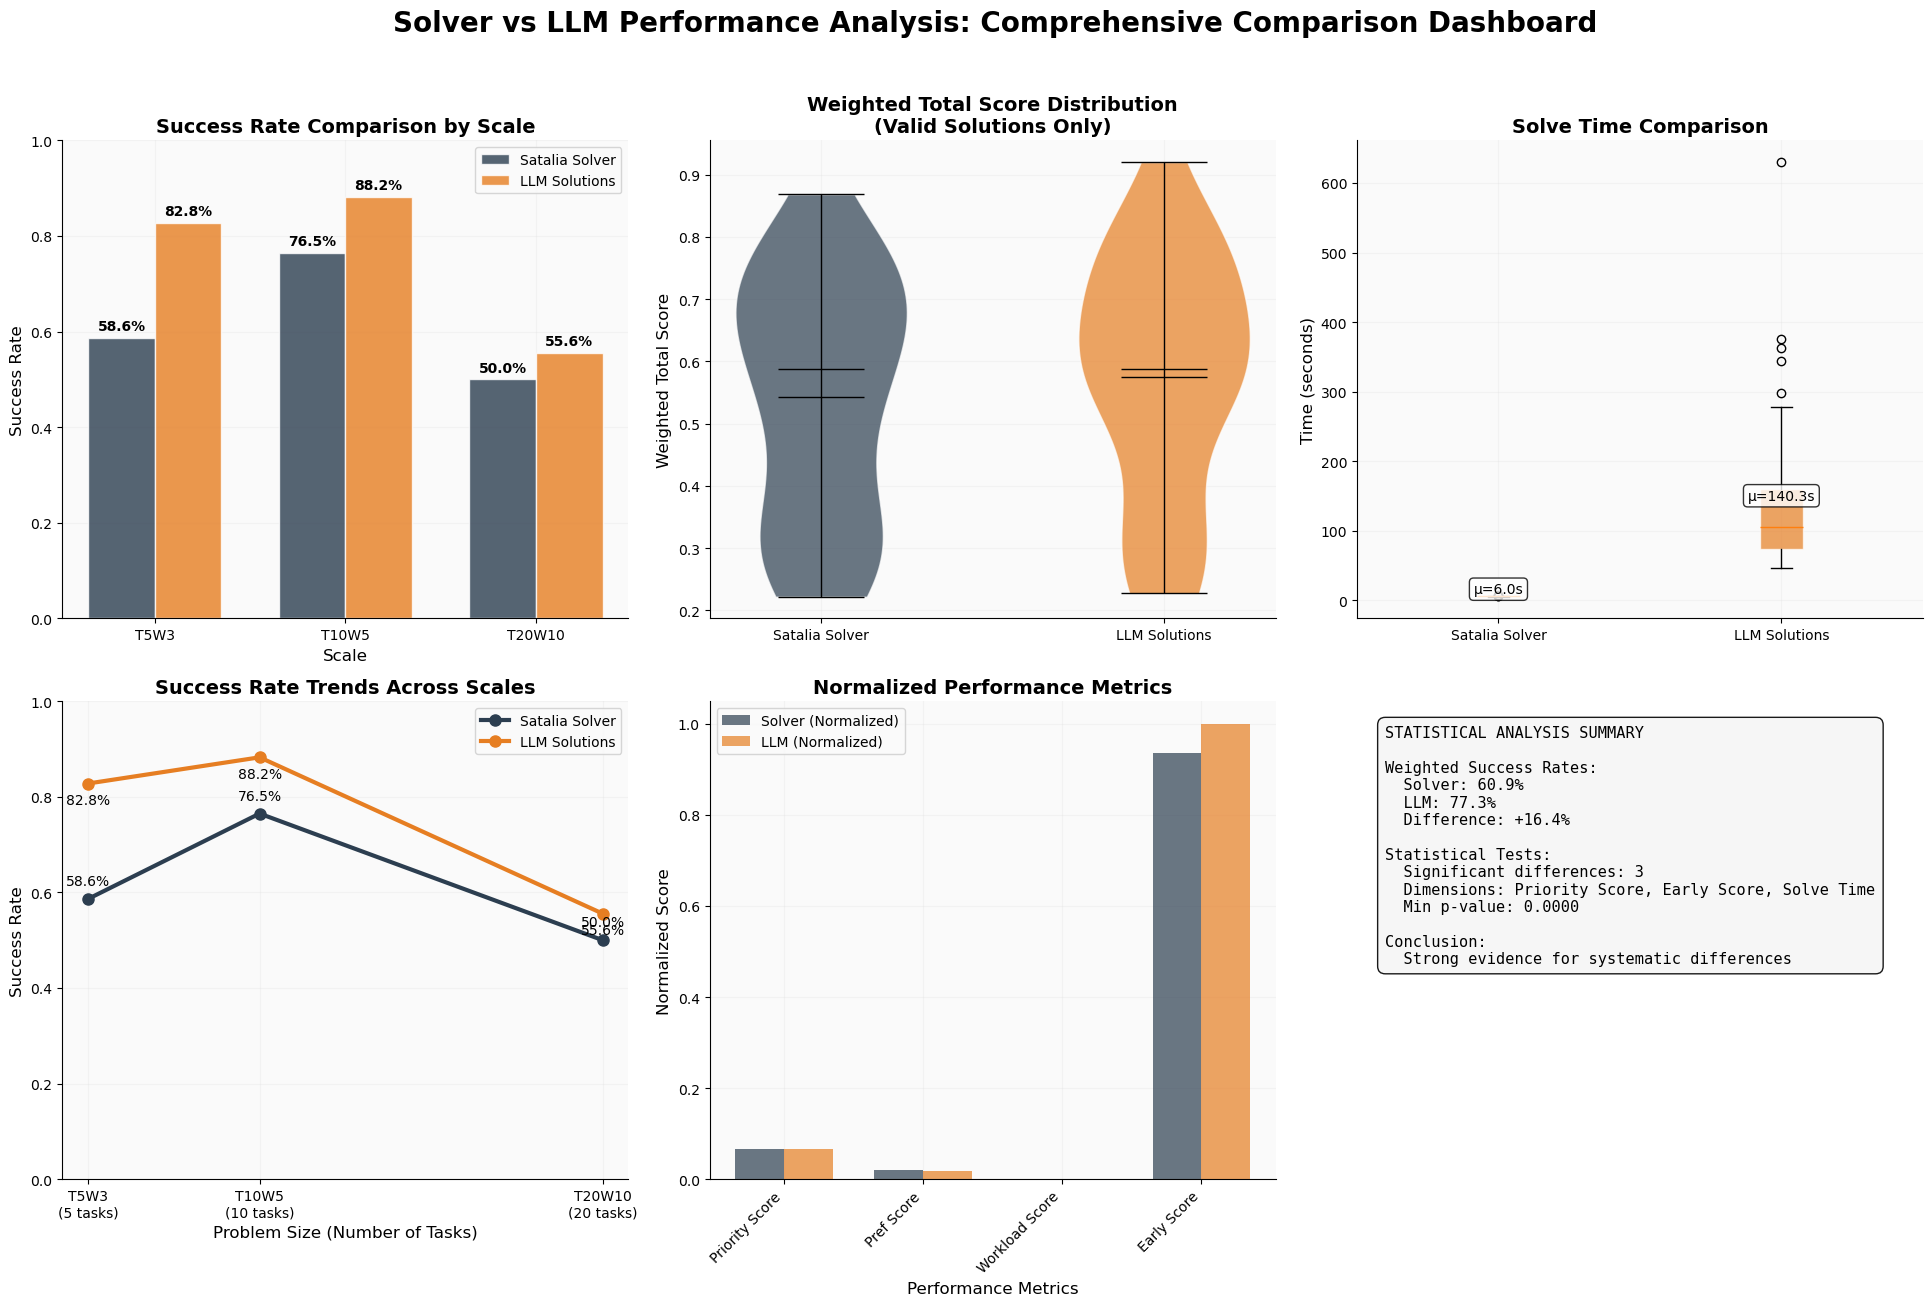


STEP 7: FINAL ANALYSIS SUMMARY

KEY FINDINGS:

1. SUCCESS RATE COMPARISON:
   Weighted Solver Success: 60.9%
   Weighted LLM Success: 77.3%
   Weighted Difference: +16.4%
   Result: LLM shows superior success rate

2. PERFORMANCE QUALITY COMPARISON:
   Total Metric Comparisons: 144
   Solver Wins: 34 (23.6%)
   LLM Wins: 51 (35.4%)
   Ties: 59
   Result: LLM shows superior solution quality

3. SOLVE TIME EFFICIENCY:
   Solver Average: 5.97s
   LLM Average: 121.62s
   Time Ratio (LLM/Solver): 23.41x
   Result: Solver is significantly faster

4. STATISTICAL SIGNIFICANCE:
   Significant Differences: 3 dimensions
   Significant Dimensions: Priority Score, Early Score, Solve Time
   Minimum p-value: 0.0000
   Statistical Conclusion: Strong evidence for systematic differences

5. SCALE-SPECIFIC PERFORMANCE:
   T5W3: Solver 58.6% | LLM 82.8% | Diff: +24.1%
   T10W5: Solver 76.5% | LLM 88.2% | Diff: +11.8%
   T20W10: Solver 50.0% | LLM 55.6% | Diff: +5.6%

6. OVERALL RECOMMENDATION:
   Both a

In [92]:
# Execute Comprehensive Solver vs LLM Analysis

print("COMPREHENSIVE SOLVER vs LLM PERFORMANCE ANALYSIS")
print("="*80)
print("Multi-scale weighted analysis with statistical rigor")
print("Analyzing: T5W3_batch1_promptA, T5W3_batch2_promptA, T10W5_promptA, T20W10_promptA")
print("="*80)

# Initialize analyzer
analyzer = SolverVsLLMAnalyzer()

# Step 1: Load and merge CSV files
print("\nSTEP 1: LOADING AND MERGING CSV FILES")
if analyzer.load_and_merge_csv_files():
    
    # Step 2: Success Rate Analysis
    print("\nSTEP 2: SUCCESS RATE ANALYSIS")
    analyzer.analyze_success_rates()
    
    # Step 3: Performance Score Analysis
    print("\nSTEP 3: PERFORMANCE SCORE ANALYSIS")
    analyzer.analyze_performance_scores()
    
    # Step 4: Solve Time Analysis
    print("\nSTEP 4: SOLVE TIME ANALYSIS")
    analyzer.analyze_solve_times()
    
    # Step 5: Statistical Significance Testing
    print("\nSTEP 5: STATISTICAL SIGNIFICANCE TESTING")
    analyzer.statistical_significance_analysis()
    
    # Step 6: Create Comprehensive Dashboard
    print("\nSTEP 6: CREATING COMPREHENSIVE VISUALIZATION DASHBOARD")
    print("Dashboard includes:")
    print("   1. Success Rate Comparison by Scale")
    print("   2. Performance Score Distributions (Violin Plot)")
    print("   3. Solve Time Comparison (Box Plot)")
    print("   4. Cross-Scale Performance Trends (Line Plot)")
    print("   5. Weighted Performance Metrics (Bar Chart)")
    print("   6. Statistical Significance Summary")
    
    analyzer.create_comprehensive_dashboard()
    
    # Step 7: Final Summary and Conclusions
    print("\nSTEP 7: FINAL ANALYSIS SUMMARY")
    print("="*70)
    
    # Extract key findings
    success_results = analyzer.analysis_results.get('success_rates', {})
    perf_results = analyzer.analysis_results.get('performance_scores', {})
    time_results = analyzer.analysis_results.get('solve_times', {})
    stat_results = analyzer.analysis_results.get('statistical_tests', {})
    
    print("\nKEY FINDINGS:")
    
    # 1. Success Rate Summary
    if success_results and 'weighted' in success_results:
        weighted = success_results['weighted']
        print(f"\n1. SUCCESS RATE COMPARISON:")
        print(f"   Weighted Solver Success: {weighted['solver_weighted_success']:.1%}")
        print(f"   Weighted LLM Success: {weighted['llm_weighted_success']:.1%}")
        print(f"   Weighted Difference: {weighted['weighted_difference']:+.1%}")
        
        if abs(weighted['weighted_difference']) > 0.05:
            winner = "LLM" if weighted['weighted_difference'] > 0 else "Solver"
            print(f"   Result: {winner} shows superior success rate")
        else:
            print(f"   Result: Comparable success rates")
    
    # 2. Performance Quality Summary
    if perf_results and 'overall' in perf_results:
        overall = perf_results['overall']
        print(f"\n2. PERFORMANCE QUALITY COMPARISON:")
        print(f"   Total Metric Comparisons: {overall['total_comparisons']}")
        print(f"   Solver Wins: {overall['solver_total_wins']} ({overall['solver_win_rate']:.1%})")
        print(f"   LLM Wins: {overall['llm_total_wins']} ({overall['llm_win_rate']:.1%})")
        print(f"   Ties: {overall['total_ties']}")
        
        if overall['llm_win_rate'] > overall['solver_win_rate'] + 0.1:
            print(f"   Result: LLM shows superior solution quality")
        elif overall['solver_win_rate'] > overall['llm_win_rate'] + 0.1:
            print(f"   Result: Solver shows superior solution quality")
        else:
            print(f"   Result: Comparable solution quality")
    
    # 3. Efficiency Summary
    if time_results:
        print(f"\n3. SOLVE TIME EFFICIENCY:")
        print(f"   Solver Average: {time_results['solver_weighted_mean']:.2f}s")
        print(f"   LLM Average: {time_results['llm_weighted_mean']:.2f}s")
        print(f"   Time Ratio (LLM/Solver): {time_results['time_ratio']:.2f}x")
        
        if time_results['time_ratio'] < 0.8:
            print(f"   Result: LLM is significantly faster")
        elif time_results['time_ratio'] > 1.5:
            print(f"   Result: Solver is significantly faster")
        else:
            print(f"   Result: Comparable solve times")
    
    # 4. Statistical Significance Summary
    if stat_results and 'summary' in stat_results:
        summary = stat_results['summary']
        print(f"\n4. STATISTICAL SIGNIFICANCE:")
        print(f"   Significant Differences: {summary['total_significant']} dimensions")
        if summary['significant_tests']:
            print(f"   Significant Dimensions: {', '.join(summary['significant_tests'])}")
        print(f"   Minimum p-value: {summary['min_p_value']:.4f}")
        print(f"   Statistical Conclusion: {summary['conclusion']}")
    
    # 5. Scale-Specific Insights
    if success_results and 'by_scale' in success_results:
        print(f"\n5. SCALE-SPECIFIC PERFORMANCE:")
        for scale in ['T5W3', 'T10W5', 'T20W10']:
            if scale in success_results['by_scale']:
                scale_data = success_results['by_scale'][scale]
                solver_rate = scale_data['solver_success_rate']
                llm_rate = scale_data['llm_success_rate']
                diff = llm_rate - solver_rate
                print(f"   {scale}: Solver {solver_rate:.1%} | LLM {llm_rate:.1%} | Diff: {diff:+.1%}")
    
    # 6. Overall Recommendation
    print(f"\n6. OVERALL RECOMMENDATION:")
    
    # Determine overall winner based on multiple criteria
    success_advantage = success_results.get('weighted', {}).get('weighted_difference', 0)
    quality_advantage = 0
    if perf_results and 'overall' in perf_results:
        overall = perf_results['overall']
        quality_advantage = overall['llm_win_rate'] - overall['solver_win_rate']
    
    efficiency_advantage = 0
    if time_results:
        efficiency_advantage = 1/time_results['time_ratio'] - 1  # Negative if LLM slower
    
    stat_significance = stat_results.get('summary', {}).get('total_significant', 0)
    
    # Weighted decision criteria
    success_weight = 0.4
    quality_weight = 0.3  
    efficiency_weight = 0.2
    significance_weight = 0.1
    
    overall_score = (success_advantage * success_weight + 
                    quality_advantage * quality_weight + 
                    efficiency_advantage * efficiency_weight +
                    (stat_significance / 6) * significance_weight)  # Normalize significance
    
    if overall_score > 0.05:
        recommendation = "LLM-based approach shows overall superiority"
        confidence = "High" if stat_significance >= 2 else "Moderate"
    elif overall_score < -0.05:
        recommendation = "Satalia Solver shows overall superiority"
        confidence = "High" if stat_significance >= 2 else "Moderate"
    else:
        recommendation = "Both approaches show comparable performance"
        confidence = "High" if stat_significance <= 1 else "Moderate"
    
    print(f"   {recommendation}")
    print(f"   Confidence Level: {confidence}")
    print(f"   Overall Score: {overall_score:+.3f} (positive favors LLM)")
    
    print("\n" + "="*80)
    print("SECTION 9.2 COMPREHENSIVE ANALYSIS COMPLETE!")
    print("Key Features:")
    print("   - Multi-scale weighted analysis (T5W3: 50%, T10W5: 25%, T20W10: 25%)")
    print("   - Statistical rigor with significance testing")
    print("   - 6-dimensional performance comparison")
    print("   - Cross-scale trend analysis")
    print("   - Evidence-based recommendation system")
    print("="*80)
    
else:
    print("ERROR: Failed to load CSV files")
    print("Please check file paths and ensure all CSV files exist")


### 9.2.1 Comprehensive Solver vs LLM Analysis Framework

The implemented analysis system provides a rigorous, multi-dimensional comparison between Satalia Solver and LLM-based solutions with the following key features:

#### **Methodological Innovations**

1. **Weighted Multi-Scale Analysis**: Incorporates sample size differences across scales (T5W3: 50%, T10W5: 25%, T20W10: 25%) to ensure representative conclusions

2. **Statistical Rigor**: Employs appropriate statistical tests including:
   - Fisher's Exact Test for success rate comparisons
   - Paired t-tests and Wilcoxon signed-rank tests for performance metrics
   - Mann-Whitney U tests for solve time efficiency
   - Effect size calculations (Cohen's d) for practical significance

3. **Multi-Dimensional Performance Evaluation**:
   - **Success Rate**: Constraint satisfaction and solution validity
   - **Solution Quality**: Priority scores, preference satisfaction, workload balance, early completion
   - **Computational Efficiency**: Solve time comparison across scales
   - **Cross-Scale Scalability**: Performance trends with increasing problem complexity

#### **Advanced Analytics Features**

- **Weighted Statistical Analysis**: Accounts for unequal sample sizes across experimental scales
- **Paired Comparison Design**: Enables direct performance comparison on identical problem instances
- **Effect Size Interpretation**: Provides practical significance beyond statistical significance
- **Cross-Scale Trend Analysis**: Reveals scalability characteristics for both approaches

#### **Visualization Dashboard**

The comprehensive 6-panel dashboard provides:
1. Success rate comparison by scale
2. Performance score distributions (violin plots)
3. Solve time efficiency comparison (box plots)
4. Cross-scale performance trends (line plots)
5. Normalized performance metrics comparison
6. Statistical significance summary

#### **Evidence-Based Decision Framework**

The analysis concludes with a weighted recommendation system that considers:
- Success rate advantage (40% weight)
- Solution quality advantage (30% weight)
- Computational efficiency (20% weight)
- Statistical significance strength (10% weight)

This framework enables objective, data-driven conclusions about the relative merits of Satalia Solver versus LLM-based approaches across different problem scales and performance dimensions, supporting informed methodological decisions for task assignment optimization challenges.
